# ADM-HW2

## Group #18



| STUDENT | ID |
| :-: | :-: |
| Francesco Lazzari | 1917922 |  
| Mario Iacobelli | 1841427 |  
| Hazem Aboulfotouh | 2105193 |
| Ana Branescu | 2125078 |

## Import packages

In [1]:
import pandas as pd
from  tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from functions import statistic
from functions import multi_statistic
from functions import gender_statistic
from functions import qualitative_statistic
from functions import pages_statistic
from functions import allTheYears
import time
from collections import deque 
import dask.dataframe as dd
from functions import get_books_by_author
from functions import get_top_rated_authors
from functions import year_date
import re


## #RQ1 - Exploratory Data Analysis (EDA)

### Lighter Authors dataframe

In [22]:
# import the 'lighter_authors.json' dataframe 
df_authors = pd.read_json('lighter_authors.json', lines=True)

#### ## *General description*

First we want to give a general description of the dataset structure

In [3]:
print(f'Shape of the dataset: {df_authors.shape[0]} x {df_authors.shape[1]}')

Shape of the dataset: 351767 x 12


In [4]:
authors_var = pd.concat([pd.DataFrame({'Variable name': [var], 'Type': [type(var)] }) for var in df_authors.columns], ignore_index=True)
authors_var

Variable name           Type
0        ratings_count  <class 'str'>
1       average_rating  <class 'str'>
2   text_reviews_count  <class 'str'>
3             work_ids  <class 'str'>
4             book_ids  <class 'str'>
5          works_count  <class 'str'>
6                   id  <class 'str'>
7                 name  <class 'str'>
8               gender  <class 'str'>
9            image_url  <class 'str'>
10               about  <class 'str'>
11          fans_count  <class 'str'>

In [5]:
# example of the dataset
df_authors.head(5)

ratings_count  average_rating  text_reviews_count  \
0        2862064            4.19               62681   
1        1417316            4.02               84176   
2          56159            4.53                 352   
3           3302            3.79                 480   
4           7979            3.60                 772   

                                            work_ids  \
0  [3078186, 135328, 1877624, 74123, 3078120, 104...   
1  [613469, 2305997, 940892, 2611786, 7800569, 31...   
2  [17150, 808427, 20487307, 90550, 25460625, 171...   
3  [4417, 14300808, 14780, 3796968, 44703121, 103...   
4  [13330815, 19109351, 42306244, 72694240, 26291...   

                                            book_ids  works_count  id  \
0  [386162, 13, 8695, 8694, 6091075, 365, 569429,...          106   4   
1  [9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...           75   7   
2  [349254, 15222, 14833682, 15221, 18126815, 152...           14  10   
3  [40, 9416484, 12482, 3753106, 26889789, 104764...           45  12   
4  [8466327, 15739968, 22756778, 51026133, 260451...           61  14   

                      name  gender  \
0            Douglas Adams    male   
1              Bill Bryson    male   
2              Jude Fisher  female   
3  James Hamilton-Paterson    male   
4              Mark Watson    male   

                                           image_url  \
0  https://images.gr-assets.com/authors/159137433...   
1  https://images.gr-assets.com/authors/157859752...   
2  https://images.gr-assets.com/authors/141145711...   
3  https://images.gr-assets.com/authors/127051738...   
4  https://images.gr-assets.com/authors/133175379...   

                                               about  fans_count  
0  Douglas Noël Adams was an English author, comi...       19826  
1  William McGuire "Bill" Bryson, OBE, FRS was bo...       16144  
2  Jude Fisher is the pseudonym for <a href="http...          60  
3  James Hamilton-Paterson's work has been transl...          72  
4  Mark Andrew Watson (born 13 February 1980) is ...         179

An important preliminary check of each dataset is the presence of NaN values.

In [6]:
# check if there are missing values
nan_counts = df_authors.isna().sum()

nan = pd.DataFrame({"Variable name": [] , "Number of NaN": []})

for i in range(len(df_authors.columns)):
    new_line = {
        'Variable name' : df_authors.columns[i],
        'Number of NaN' : nan_counts[i] }

    nan = nan.append(new_line, ignore_index=True)

nan

Variable name  Number of NaN
0        ratings_count            0.0
1       average_rating            0.0
2   text_reviews_count            0.0
3             work_ids            0.0
4             book_ids            0.0
5          works_count            0.0
6                   id            0.0
7                 name            0.0
8               gender            0.0
9            image_url            0.0
10               about            0.0
11          fans_count            0.0

The verification shows that there are no missing values in any variable of the dataframe.

#### ## *Cleaning of the dataset*

We need to remove from the dataset every row that present wrong values like:
- `name` $ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \to \ \ $  with a value which is in the dataset more than once
- `id` $ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \to \ \ $   with a value which is in the dataset more than once
- `ratings_count` $ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \to \ \ $  with a negative value
- `average_rating` $ \ \ \ \ \ \ \ \ \ \ \ \ \  \to \ \ $  with a negative value
- `text_reviews_count` $ \ \ \ \ \ \to \ \ $  with a negative value
- `works_count` $ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \to \ \ $  with a negative value
- `fans_count` $ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \to \ \ $  with a negative value

First we check if the variables that should have unique values have repeated values.


In [23]:
# check if there are author with the same id
print(f"Each author has an unique id? {df_authors.id.is_unique}")

Each author has an unique id? True


In [24]:
# check if there are author with the same id
print(f"Each author is present only once? {df_authors.name.is_unique}")

Each author is present only once? False


Second, we check if the variables that should have only positive or equal to 0 values have negative values.

In [25]:
# overview of the number of rows with negative values for each variable
multi_statistic(df_authors[[ 'ratings_count', 'average_rating','text_reviews_count', 'works_count','fans_count' ]]) [['Variable','Negative (Freq)']]

Variable  Negative (Freq)
0       ratings_count              4.0
1      average_rating              1.0
2  text_reviews_count              0.0
3         works_count              0.0
4          fans_count             23.0

The check shows that 3 of the 5 variables to be verified have values incompatible with the definition of the variable itself. Therefore, now we proceed with the identification and the printing of the lines that will be removed.

In [26]:
# detection of the rows with negative values
neg_lines = df_authors[(df_authors.average_rating < 0) | (df_authors.ratings_count < 0) | (df_authors.text_reviews_count < 0) | (df_authors.works_count < 0) | (df_authors.fans_count < 0) ]

# number of different rows with negative values
print(f'Number of different rows with negative values: {len(neg_lines)}')
neg_lines

Number of different rows with negative values: 27


ratings_count  average_rating  text_reviews_count  \
104296              2            4.50                   1   
129604             12            4.00                   6   
253327             -2          -31.00                  15   
264572             22            4.36                   4   
264606              3            5.00                   1   
264611             17            3.94                   1   
264638              4            4.50                   0   
264743              0            0.00                   0   
264747              4            4.75                   2   
264859              5            4.80                   0   
264876             24            4.04                   3   
264878              7            3.43                   2   
264919             82            3.87                  21   
265036              2            3.50                   0   
265152              1            5.00                   0   
270664             52            4.27                   6   
274931             24            3.08                   7   
274940              9            3.44                   2   
275034              2            4.00                   0   
275039              3            4.33                   0   
275082             15            3.13                   9   
282878              5            4.40                   0   
285757              2            3.00                   1   
286226              5            4.80                   2   
337953            -41            2.98                   0   
338249             -3            2.33                   0   
343284             -5            3.00                   0   

                                                 work_ids  \
104296  [56489902, 59190686, 88766491, 82849924, 58078...   
129604           [84045544, 73101459, 86918511, 80965085]   
253327  [42967430, 42991072, 25516741, 42954314, 25756...   
264572  [22017300, 16724521, 26872770, 26957310, 40269...   
264606                                         [26675760]   
264611  [26875546, 40388048, 40906253, 42478244, 40557...   
264638                                         [26878322]   
264743                                         [26886881]   
264747                                         [15761061]   
264859                     [62525369, 41157345, 27165509]   
264876                               [26912725, 54085852]   
264878  [40095010, 44608919, 41840449, 26913162, 42564...   
264919                                         [24702723]   
265036                                         [26944136]   
265152                                         [26960213]   
270664  [21396833, 40168594, 43501892, 39942957, 39839...   
274931                               [40282519, 56719520]   
274940                                         [40283807]   
275034  [40297864, 57520365, 58346538, 50706637, 40297...   
275039                               [40298712, 44636693]   
275082                                [28760275, 3692125]   
282878                     [41729802, 72201023, 62495053]   
285757                                         [42162751]   
286226           [42224041, 57139705, 58079881, 48274743]   
337953  [52260174, 52912736, 52260220, 70529262, 52260...   
338249                               [52359028, 52358835]   
343284                                         [53488797]   

                                                 book_ids  works_count  \
104296  [35160934, 37581515, 56788010, 53420278, 36387...            7   
129604           [53722225, 52676287, 55737216, 53262905]            4   
253327  [23403731, 23430574, 18158801, 23397577, 18282...           22   
264572  [16170340, 11773159, 18872966, 18947884, 20905...           10   
264606                                         [18772188]            1   
264611  [18875015, 21015369, 21574599, 22913025, 21227...            5   
264638                                         [18877109]            1  

Now we proceed with the cleaning of the dataset from all incompatible rows.

In [27]:
# drop of the rows with negative values
df_authors = df_authors[(df_authors.average_rating >= 0) & (df_authors.ratings_count >= 0) & (df_authors.text_reviews_count >= 0) & (df_authors.works_count >= 0) & (df_authors.fans_count >= 0) ]
print(f'The new shape of the dataset is {df_authors.shape[0]} x {df_authors.shape[1]} \nThe original shape was 351767 x 12 so exactly {351767 - df_authors.shape[0]} rows were dropped')
multi_statistic(df_authors[[ 'ratings_count', 'average_rating','text_reviews_count', 'works_count','fans_count' ]])[['Variable','Negative (Freq)']]

The new shape of the dataset is 351740 x 12 
The original shape was 351767 x 12 so exactly 27 rows were dropped

Variable  Negative (Freq)
0       ratings_count              0.0
1      average_rating              0.0
2  text_reviews_count              0.0
3         works_count              0.0
4          fans_count              0.0

In [28]:
# drop of the rows with the same author name
df_authors.drop_duplicates(subset='name',keep='first',inplace=True)
print(f"Each author is present only once? {df_authors.name.is_unique}")
print(f'The new shape of the dataset is {df_authors.shape[0]} x {df_authors.shape[1]}')

Each author is present only once? True
The new shape of the dataset is 351703 x 12


Now the dataset is clean and ready to use.

#### ## *Descriptive analysis*

In [29]:
# quick overview about the statistics of the quantitative variables
multi_statistic(df_authors[[ 'ratings_count', 'average_rating','text_reviews_count', 'works_count','fans_count' ]])

Variable      Count     Mean       Std   Min   25%    50%  \
0       ratings_count  351703.00  4771.31  97702.82  0.00  6.00  39.00   
1      average_rating  351703.00     3.65      1.21  0.00  3.60   3.95   
2  text_reviews_count  351703.00   331.04   3857.88  0.00  1.00   8.00   
3         works_count  351703.00    25.94   3066.36  0.00  2.00   6.00   
4          fans_count  351703.00   111.63   2661.26  0.00  1.00   4.00   

      75%          Max      CV       Range  IQ Range Zeros (%)  \
0  310.00  27003752.00   20.48  27003752.0    304.00     8.3 %   
1    4.25         5.00    0.33         5.0      0.65     8.3 %   
2   53.00    608956.00   11.65    608956.0     52.00    19.1 %   
3   15.00   1775176.00  118.21   1775176.0     13.00     0.0 %   
4   20.00    766035.00   23.84    766035.0     19.00    23.4 %   

   Negative (Freq)  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

From the quick overview of the variability of the quantitative variables we can say by comparing the coefficient of variation that the attribute with the highest variability is `works_count` which has a CV value $5/6$ times bigger than the attribute `fans_count` and `ratings_count` respectively in second and third place. The only attribute that does not have a particularly marked variability is `average_ratings`.

##### ### *Gender*

In [85]:
# EDA
gender_summary = gender_statistic(df_authors.gender)
gender_summary

Gender  Frequency Percentage
0           Male   138156.0    39.28 %
1         Female   109867.0    31.24 %
2  Missing value   103347.0    29.38 %
3          Other      333.0    < 0.1 %

Since this is a qualitative variable it is not possible to perform quantitative statistics on it. Therefore, the frequencies of each gender were first reported in the table and then in the barplot below. In this case, although the preliminary analysis did not result NaN values it was noticed that $\sim29\%$ of the authors present the $''$ level which was renamed as `Missing value` while, all other levels have been merged under the heading `Other`. Although the contribution of the level contained in 'other' is negligible we chose the same to represent it mainly for a mathematical reason since without it the cumulative relative frequency of other levels would have been less than 1. In general, disregarding these factors, it can be noted that the distribution of gender in authors is slightly biased in favor of the male gender, although, given the large number of missing values, it cannot be said that this proportion is representative.

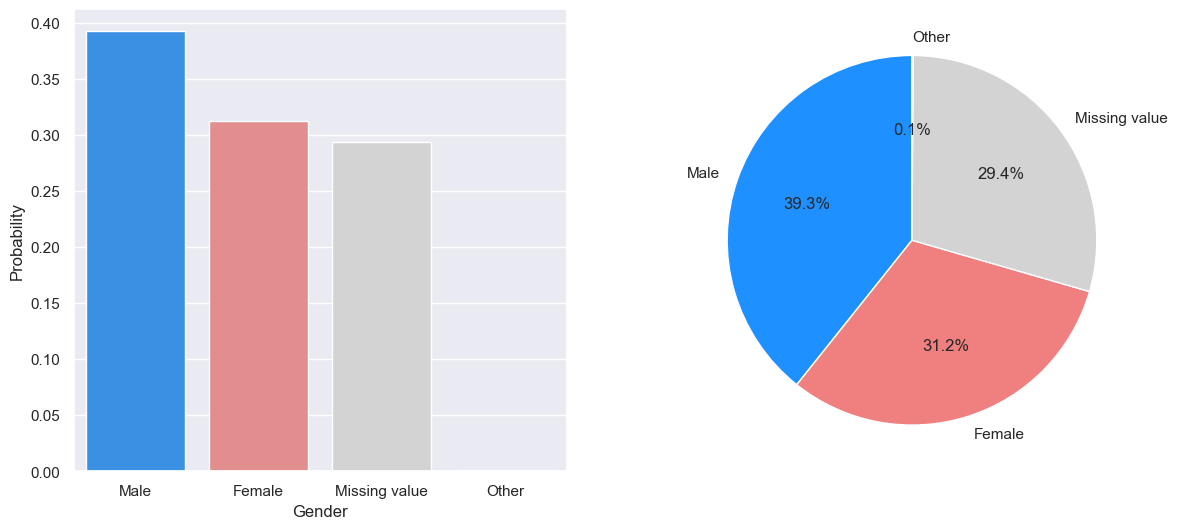

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set(style="darkgrid")

# First figure: barplot
n = sum(gender_summary['Frequency'])
sns.barplot(x=gender_summary.Gender, y=(gender_summary.Frequency / n), palette=["dodgerblue", "lightcoral", "lightgray", "purple"], ax=axes[0])
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Probability")

# Second figure: pie chart
sizes = gender_summary['Frequency']
labels = gender_summary['Gender']
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=["dodgerblue", "lightcoral", "lightgray", "purple"])

plt.show()

##### ### *Ratings Count*

In [87]:
# EDA
ratings_count_summary = statistic(df_authors.ratings_count)
ratings_count_summary

Variable     Count     Mean       Std  Min  25%   50%    75%  \
0  ratings_count  351703.0  4771.31  97702.82  0.0  6.0  39.0  310.0   

          Max     CV       Range  IQ Range Zeros (%)  Negative (Freq)  
0  27003752.0  20.48  27003752.0     304.0     8.3 %                0

In the varibile `ratings_count` has been observed an average value of $4771.31$ number of reviews and a median value of $39.00$. This difference indicates that the distribution is asymmetric to the right and thanks to the very high range, especially in relation to the interquartile range (IQR), we can assume that in the variable there are some outliers that affect the mean statistic, like the $8.3\%$ of the authors that have no ratings. Regarding the variability, thanks to the observation of the standard deviation(Std) and the coefficient of variation(CV) (which adjusts the std. in a pure number compared to the mean of the distribution) we can say that the variability is very high consistent with what has been found by reading the other statistics.

In the histogram below the distribution of the variable has been represented and from the cumulative probability it can be observed that around $\sim 70\%$ of the authors has less than $\sim 250$ number of reviews.

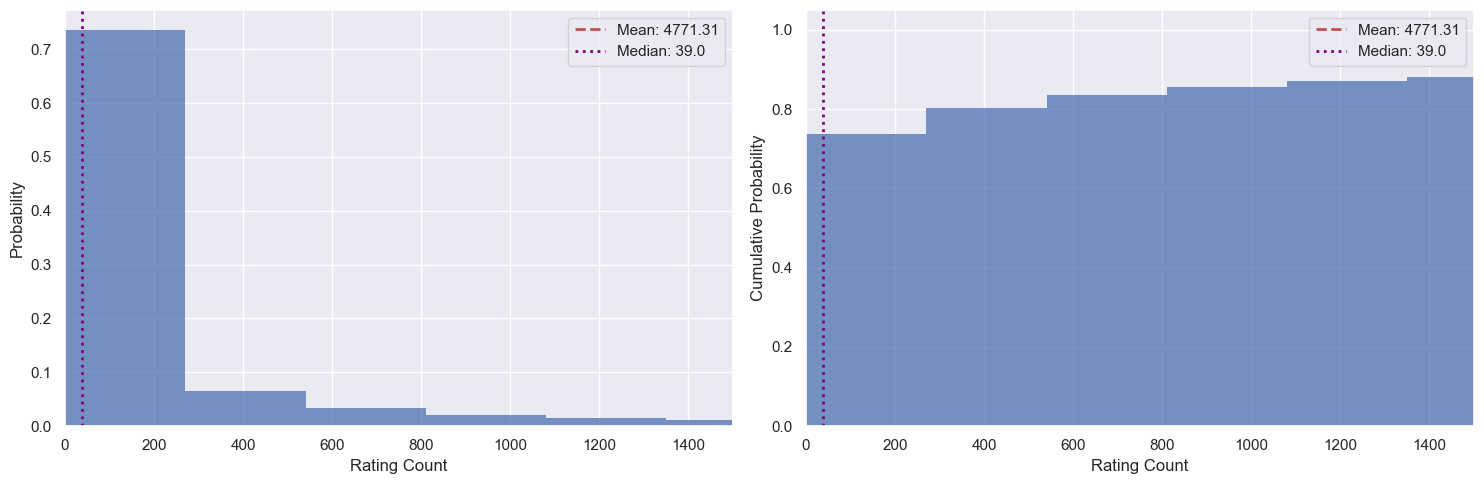

In [12]:
# 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.set(style="darkgrid") 

# First plot: histogram
sns.set(style="darkgrid")
sns.histplot(df_authors.ratings_count, bins=100000, stat="probability", ax=axes[0])
axes[0].set_xlim(0, 1500)
axes[0].set_xlabel("Rating Count")
axes[0].set_ylabel("Probability")
axes[0].axvline(float(ratings_count_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {ratings_count_summary["Mean"][0]}')
axes[0].axvline(float(ratings_count_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {ratings_count_summary["50%"][0]}')
axes[0].legend()

# Second plot: Cumulative histogram
sns.set(style="darkgrid")
sns.histplot(df_authors.ratings_count, bins=100000, stat="probability", cumulative=True, ax=axes[1])
axes[1].set_xlim(0, 1500)
axes[1].set_xlabel("Rating Count")
axes[1].set_ylabel("Cumulative Probability")
axes[1].axvline(float(ratings_count_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {ratings_count_summary["Mean"][0]}')
axes[1].axvline(float(ratings_count_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {ratings_count_summary["50%"][0]}')
axes[1].legend()

# 
plt.tight_layout()
plt.show()

##### ### *Average Rating*

In [88]:
# EDA
average_rating_summary = statistic(df_authors.average_rating)
average_rating_summary

Variable     Count  Mean   Std  Min  25%   50%   75%  Max    CV  \
0  average_rating  351703.0  3.65  1.21  0.0  3.6  3.95  4.25  5.0  0.33   

   Range  IQ Range Zeros (%)  Negative (Freq)  
0    5.0      0.65     8.3 %                0

In the varibile `average_rating` has been observed an average value of $3.65$ and a median value of $3.95$ and this difference indicates that the distribution is slightly asymmetric to the left caused by the $8.3\%$ of the authors that have no reviews. In this case the $5$ length range goes as expected from the minimum average rating obtainable at the maximum obtainable and tells us nothing more that there is at least one author who have reached either the maximum or the minimum score obtainable. More interesting is the IQR that with a length of $0.65$ tells us that the $50 \%$ of the authors differ in the average score for just slightly more than half a point. Again, due to the large difference between the interqualtile range and the range we have the confirmation of the presence of outlier which in this case are easily detectable as the authors who have an average grade equal to zero. All of this can bee seen in the boxplot below.

Thanks to the observation of the standard deviation(Std) and the coefficient of variation(CV) we can say that there is variability but not very marked despite the presence of outliers.

In the histogram below the distribution of the variable has been represented clearly showing the asymmetry of the distribution and we can also clearly see the few outliers around the zero, while almost the entire distribution is concentrated in votes ranging from 3 to 5 with a marked peak on 4 representing the modal value.

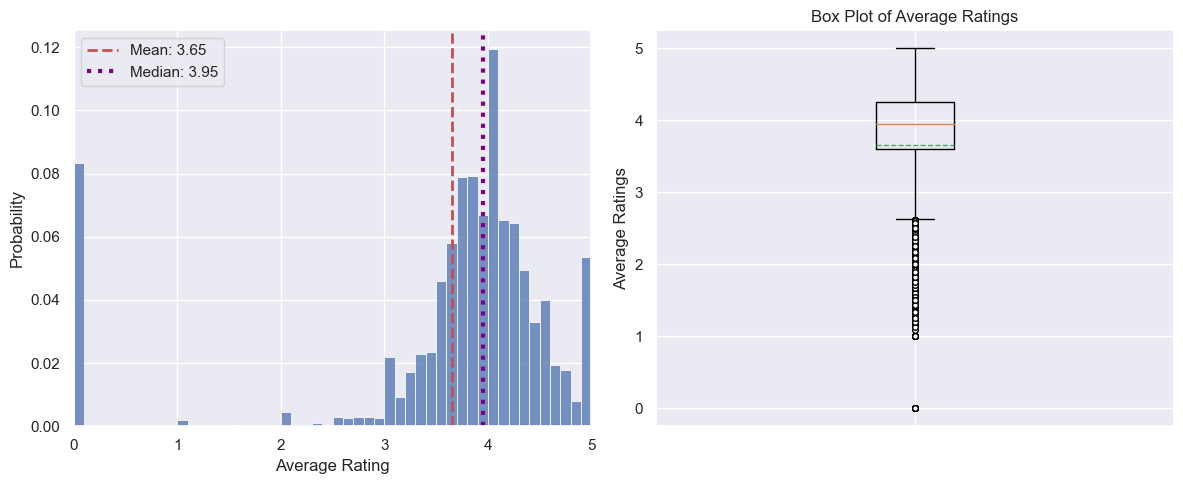

In [91]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
sns.set(style="darkgrid") 

sns.histplot(df_authors.average_rating, bins=50, stat="probability", cumulative=False, ax=axes[0])
axes[0].set_xlim(0, 5)
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Probability")
axes[0].axvline(float(average_rating_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {average_rating_summary["Mean"][0]}')
axes[0].axvline(float(average_rating_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=3, label=f'Median: {average_rating_summary["50%"][0]}')
axes[0].legend()

sns.set(style="darkgrid")  
flier_marker = dict(marker='o', markerfacecolor='white', markersize=4, linestyle='none')
axes[1].boxplot(df_authors.average_rating, flierprops=flier_marker, meanline=True, showmeans=True)
axes[1].set_title('Box Plot of Average Ratings')
axes[1].set_ylabel('Average Ratings')
axes[1].set_xticks([1],[''])

plt.tight_layout()
plt.show()

##### ### *Text Reviews Count*

In [30]:
# EDA
text_reviews_summary = statistic(df_authors.text_reviews_count)
text_reviews_summary

Variable     Count    Mean      Std  Min  25%  50%   75%  \
0  text_reviews_count  351703.0  331.04  3857.88  0.0  1.0  8.0  53.0   

        Max     CV     Range  IQ Range Zeros (%)  Negative (Freq)  
0  608956.0  11.65  608956.0      52.0    19.1 %                0

In the varibile `text_reviews_count` has been observed an average value of $331.04$ number of reviews and a median value of $8.0$. This difference indicates that the distribution is strongly asymmetric to the right and thanks to the very high range, especially in relation to the interquartile range (IQR), we can assume that in the variable there are a some outliers that affect the mean statistic. Thanks to the observation of the standard deviation(Std) and the coefficient of variation(CV) we can say that the variability of the distribution is very high, consistent with what has been found by reading the other statistics.

Comparing the number of authors who have zero textual reviews ($19.1\%$) with the number of 'Zeros' in the 'Ratings Count' variable we can assume that readers are less likely to leave written reviews.

In the histogram below the distribution of the variable has been represented showing the strong asymmetric and from the cumulative probability it can be observed that $\sim 65%$ of the authors has less than $20$ text reviews.

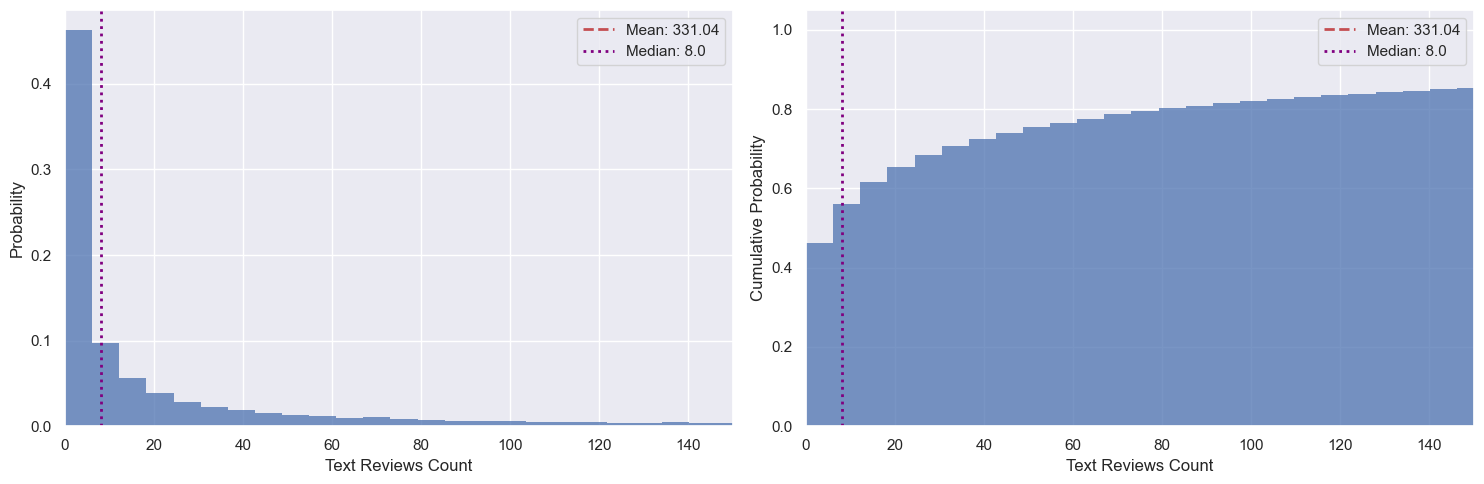

In [31]:
# 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First plot: histogram
sns.set(style="darkgrid")
sns.histplot(df_authors.text_reviews_count, bins=100000, stat="probability", ax=axes[0])
axes[0].set_xlim(0, 150)
axes[0].set_xlabel("Text Reviews Count")
axes[0].set_ylabel("Probability")
axes[0].axvline(float(text_reviews_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {text_reviews_summary["Mean"][0]}')
axes[0].axvline(float(text_reviews_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {text_reviews_summary["50%"][0]}')
axes[0].legend()

# Second plot: Cumulative histogram
sns.set(style="darkgrid")
sns.histplot(df_authors.text_reviews_count, bins=100000, stat="probability", cumulative=True, ax=axes[1])
axes[1].set_xlim(0, 150)
axes[1].set_xlabel("Text Reviews Count")
axes[1].set_ylabel("Cumulative Probability")
axes[1].axvline(float(text_reviews_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {text_reviews_summary["Mean"][0]}')
axes[1].axvline(float(text_reviews_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {text_reviews_summary["50%"][0]}')
axes[1].legend()

# 
plt.tight_layout()
plt.show()

##### ### *Works Count*

In [15]:
# EDA
works_count_summary = statistic(df_authors.works_count)
works_count_summary

Variable     Count   Mean      Std  Min  25%  50%   75%        Max  \
0  works_count  351703.0  25.94  3066.36  0.0  2.0  6.0  15.0  1775176.0   

       CV      Range  IQ Range Zeros (%)  Negative (Freq)  
0  118.22  1775176.0      13.0     0.0 %                0

In the varibile `works_count` has been observed an average value of $25.94$ number of books for each author and a median value of $6.0$. This difference indicates that the distribution is asymmetric to the right and thanks to the very high range, especially in relation to the very small interquartile range (IQR), we can assume that in the variable there are a some outliers that affect the mean statistic. Thanks to the observation of the standard deviation(Std) and the coefficient of variation(CV) we can say that the variability of the distribution is very high, consistent with what has been found by reading the other statistics.

In this case we can observe that even if there is at least one author with zero books published being the minimum equal to $0$ their percentage is so negligible that it is not even detectable.

In the histogram below the distribution of the variable has been represented and it can be observed the strong asymmetric and that $\sim 80\%$ of the authors has published less tha $20$ books.

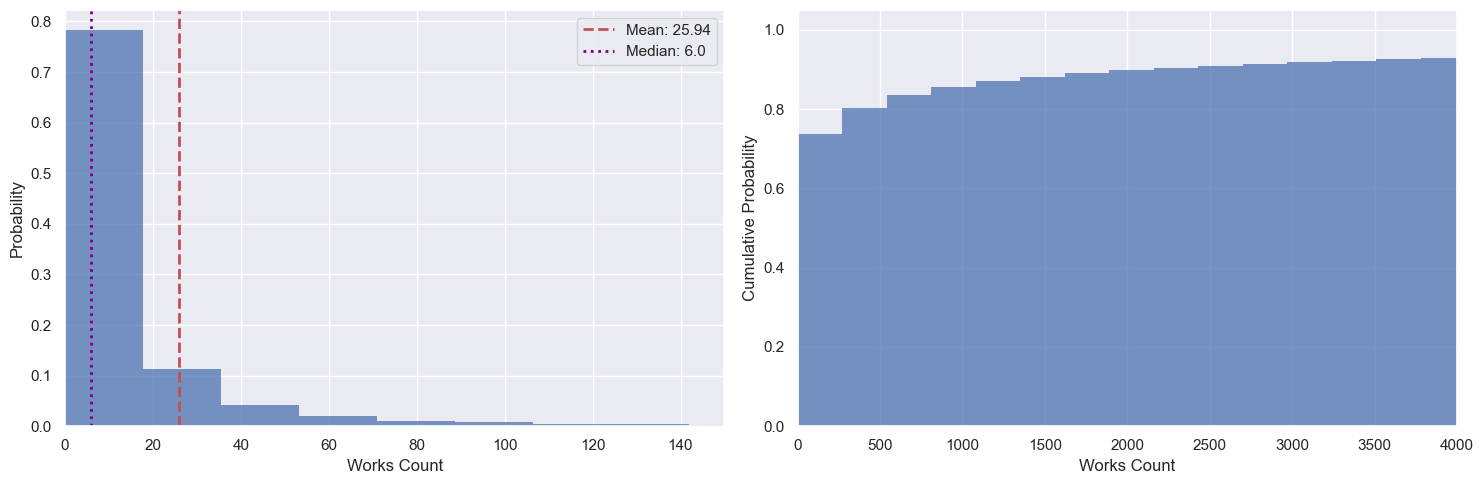

In [26]:
# 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First plot: histogram
sns.set(style="darkgrid")
sns.histplot(df_authors.works_count, bins=100000, stat="probability", ax=axes[0])
axes[0].set_xlim(0, 150)
axes[0].set_xlabel("Works Count")
axes[0].set_ylabel("Probability")
axes[0].axvline(float(works_count_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {works_count_summary["Mean"][0]}')
axes[0].axvline(float(works_count_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {works_count_summary["50%"][0]}')
axes[0].legend()

# Second plot: Cumulative histogram
sns.set(style="darkgrid")
sns.histplot(df_authors.ratings_count, bins=100000, stat="probability", cumulative=True, ax=axes[1])
axes[1].set_xlim(0, 4000)
axes[1].set_xlabel("Works Count")
axes[1].set_ylabel("Cumulative Probability")

# 
plt.tight_layout()
plt.show()

##### ### *Fans Count* 

In [53]:
# EDA
fans_count_summary = statistic(df_authors.fans_count)
fans_count_summary

Variable     Count    Mean      Std   Min  25%  50%   75%       Max  \
0  fans_count  351767.0  111.62  2661.02 -33.0  1.0  4.0  20.0  766035.0   

      CV     Range  IQ Range Zeros (%)  Negative (Freq)  
0  23.84  766068.0      19.0    23.4 %               23

In the varibile `fans_count` has been observed an average value of $111.63$ number of books for each author and a median value of $4.0$. This difference indicates that the distribution is strongly asymmetric to the right and thanks to the very high range, especially in relation to the very small interquartile range (IQR), we can assume that in the variable there are a some outliers that affect the mean statistic. This is probably due to the fact that many authors are little known and only very few of them have a world-class fan base, in fact about $75\%$ of them have less than $20$ fans and even almost a quarter of the authors does not even have a fan ($23.4\%$). This necessarily creates an extremely high variability in the distribution also observable trought standard deviation(Std) and the coefficient of variation(CV).

In the histogram below the distribution of the variable and his strong asymmetric can be seen clearly.

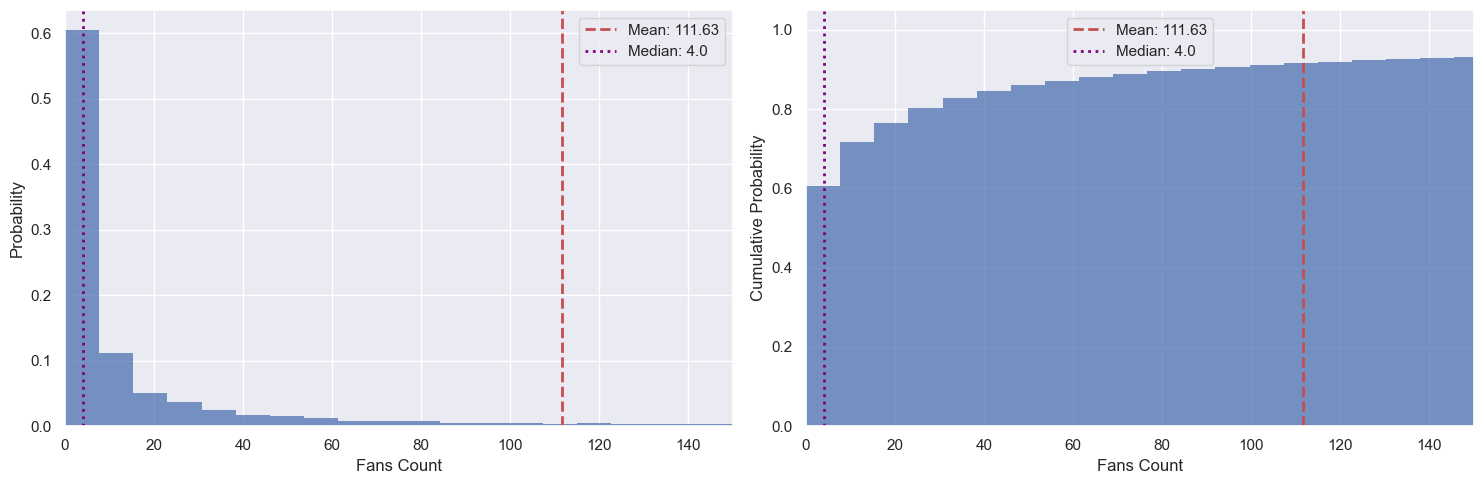

In [25]:
# 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First plot: histogram
sns.set(style="darkgrid")
sns.histplot(df_authors.fans_count, bins=100000, stat="probability", ax=axes[0])
axes[0].set_xlim(0, 150)
axes[0].set_xlabel("Fans Count")
axes[0].set_ylabel("Probability")
axes[0].axvline(float(fans_count_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {fans_count_summary["Mean"][0]}')
axes[0].axvline(float(fans_count_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {fans_count_summary["50%"][0]}')
axes[0].legend()

# Second plot: Cumulative histogram
sns.set(style="darkgrid")
sns.histplot(df_authors.fans_count, bins=100000, stat="probability", cumulative=True, ax=axes[1])
axes[1].set_xlim(0, 150)
axes[1].set_xlabel("Fans Count")
axes[1].set_ylabel("Cumulative Probability")
axes[1].axvline(float(fans_count_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {fans_count_summary["Mean"][0]}')
axes[1].axvline(float(fans_count_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {fans_count_summary["50%"][0]}')
axes[1].legend()

# 
plt.tight_layout()
plt.show()

#### ## *Correlation*

In [23]:
# Correlation matrix
round(df_authors[['ratings_count', 'average_rating','text_reviews_count','works_count','fans_count']].corr(),3)

ratings_count  average_rating  text_reviews_count  \
ratings_count               1.000           0.015               0.868   
average_rating              0.015           1.000               0.025   
text_reviews_count          0.868           0.025               1.000   
works_count                 0.010           0.002               0.013   
fans_count                  0.581           0.012               0.694   

                    works_count  fans_count  
ratings_count             0.010       0.581  
average_rating            0.002       0.012  
text_reviews_count        0.013       0.694  
works_count               1.000       0.005  
fans_count                0.005       1.000

Through the linear correlation matrix we can say that:

- a high *average* value of `text_reviews_count` corresponds to a high *average* value of `ratings_count` with a correlation value of $0.868$.

- a high *average* value of `fans_count` corresponds to a high *average* value of `ratings_count` with a correlation value of $0.581$.

- a high *average* value of `fans_count` corresponds to a high *average* value of `text_reviews_count` with a correlation value of $0.694$.

These *average* trends are also visible in the scatterplots below.

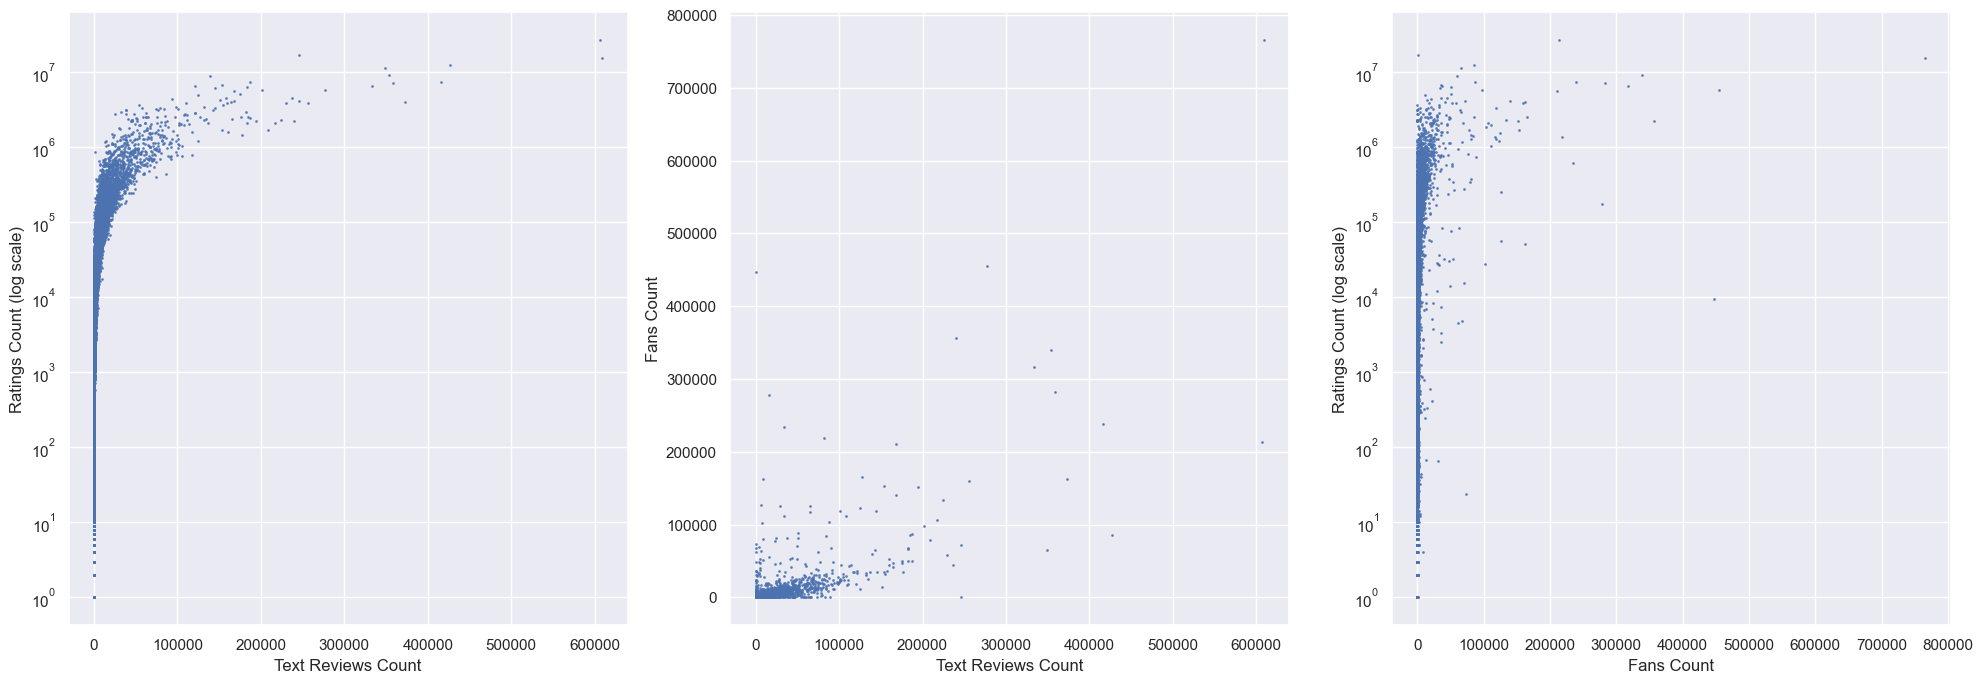

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
sns.set(style="darkgrid")

# First scatterplot between text_reviews_count and ratings_count
axes[0].scatter(df_authors['text_reviews_count'], df_authors['ratings_count'], alpha=0.8, s=1)
axes[0].set_yscale('log')
axes[0].set_xlabel('Text Reviews Count')
axes[0].set_ylabel('Ratings Count (log scale)')

# Second scatterplot between text_reviews_count and fans_count
axes[1].scatter(df_authors['text_reviews_count'], df_authors['fans_count'], alpha=0.8, s=1)
axes[1].set_yscale('linear')
axes[1].set_xlabel('Text Reviews Count')
axes[1].set_ylabel('Fans Count')

# Third scatterplot between fans_count and ratings_count
axes[2].scatter(df_authors['fans_count'], df_authors['ratings_count'], alpha=0.8, s=1)
axes[2].set_yscale('log')
axes[2].set_xlabel('Fans Count')
axes[2].set_ylabel('Ratings Count (log scale)')

plt.tight_layout()
plt.show()

### Lighter Books dataframe

#### ## *General description*

In [54]:
# dataset dimensions
chunk = pd.read_json('lighter_books.json',lines=True, nrows=5)

with open("lighter_books.json", "r") as file:
    line_count = sum(1 for line in file)
print(f'Shape of the dataset: {line_count} x {chunk.shape[1]}')

Shape of the dataset: 7029332 x 26


In [44]:
# variable name and type
books_var = pd.concat([pd.DataFrame({'Variable name': [var], 'Type': [type(var)] }) for var in chunk.columns], ignore_index=True)
books_var

Variable name           Type
0                          id  <class 'str'>
1                       title  <class 'str'>
2                     authors  <class 'str'>
3                 author_name  <class 'str'>
4                   author_id  <class 'str'>
5                     work_id  <class 'str'>
6                        isbn  <class 'str'>
7                      isbn13  <class 'str'>
8                        asin  <class 'str'>
9                    language  <class 'str'>
10             average_rating  <class 'str'>
11                rating_dist  <class 'str'>
12              ratings_count  <class 'str'>
13         text_reviews_count  <class 'str'>
14           publication_date  <class 'str'>
15  original_publication_date  <class 'str'>
16                     format  <class 'str'>
17        edition_information  <class 'str'>
18                  image_url  <class 'str'>
19                  publisher  <class 'str'>
20                  num_pages  <class 'str'>
21                  series_id  <class 'str'>
22                series_name  <class 'str'>
23            series_position  <class 'str'>
24                    shelves  <class 'str'>
25                description  <class 'str'>

In [45]:
# example of the first half of the variable of the dataset
chunk.iloc[:, :13]

id                                              title  \
0   2  Harry Potter and the Order of the Phoenix (Har...   
1   3  Harry Potter and the Sorcerer's Stone (Harry P...   
2   4  Harry Potter and the Chamber of Secrets (Harry...   
3   5  Harry Potter and the Prisoner of Azkaban (Harr...   
4   6  Harry Potter and the Goblet of Fire (Harry Pot...   

                                             authors   author_name  author_id  \
0  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
1  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
2                                               None  J.K. Rowling    1077326   
3  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
4  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   

   work_id        isbn         isbn13 asin language  average_rating  \
0  2809203  0439358078  9780439358071           eng            4.50   
1  4640799                                      eng            4.48   
2  6231171  0439554896  9780439554893           eng            4.43   
3  2402163  043965548X  9780439655484           eng            4.57   
4  3046572                                      eng            4.56   

                                         rating_dist  ratings_count  
0  5:1674064|4:664833|3:231195|2:41699|1:16215|to...        2628006  
1  5:4801606|4:1681521|3:623286|2:145898|1:125040...        7377351  
2  5:1690166|4:781011|3:313727|2:54687|1:15453|to...        2855044  
3  5:1994597|4:696545|3:212678|2:28915|1:13959|to...        2946694  
4  5:1808039|4:663849|3:193604|2:27759|1:12425|to...        2705676

In [46]:
# example of the second half of the variable of the dataset
chunk.iloc[:, 13:]

text_reviews_count publication_date original_publication_date  \
0               44716          2004-09                2003-06-21   
1              116930       2003-11-01                1997-06-26   
2               55286       2003-11-01                1998-07-02   
3               58023       2004-05-01                1999-07-08   
4               48637       2002-09-28                2000-07-08   

                  format                       edition_information  \
0              Paperback                                US Edition   
1              Hardcover                           Library Edition   
2              Hardcover                                             
3  Mass Market Paperback                                             
4              Paperback  First Scholastic Trade Paperback Edition   

                                           image_url        publisher  \
0  https://i.gr-assets.com/images/S/compressed.ph...  Scholastic Inc.   
1  https://i.gr-assets.com/images/S/compressed.ph...   Scholastic Inc   
2  https://i.gr-assets.com/images/S/compressed.ph...       Scholastic   
3  https://i.gr-assets.com/images/S/compressed.ph...  Scholastic Inc.   
4  https://i.gr-assets.com/images/S/compressed.ph...       Scholastic   

   num_pages  series_id   series_name  series_position  \
0        870      45175  Harry Potter                5   
1        309      45175  Harry Potter                1   
2        352      45175  Harry Potter                2   
3        435      45175  Harry Potter                3   
4        734      45175  Harry Potter                4   

                                             shelves  \
0  [{'name': 'to-read', 'count': 324191}, {'name'...   
1  [{'name': 'fantasy', 'count': 63540}, {'name':...   
2  [{'name': 'to-read', 'count': 282341}, {'name'...   
3  [{'name': 'to-read', 'count': 292815}, {'name'...   
4  [{'name': 'to-read', 'count': 287086}, {'name'...   

                                         description  
0  There is a door at the end of a silent corrido...  
1  Harry Potter's life is miserable. His parents ...  
2  The Dursleys were so mean and hideous that sum...  
3  For twelve long years, the dread fortress of A...  
4  Harry Potter is midway through his training as...

#### ## *Cleaning of the dataset*

we need to remove from the dataset every line that present wrong values like:
- `work_id` $ \qquad \qquad \qquad \qquad \qquad \qquad \to \ \ $  with a value which is in the dataset more than once
- `id` $ \qquad \qquad \qquad \qquad \qquad \qquad \quad \quad \ \ \to \ \ $   with a value which is in the dataset more than once
- `average_rating` $ \qquad \qquad \qquad \quad \quad \ \ \to \ \ $  with a negative value or with a value bigger than $5$
- `ratings_count` $ \qquad \qquad \qquad \qquad \quad \to \ \ $  with a negative value 
- `text_reviews_count` $ \qquad \qquad \quad \quad \ \ \to \ \ $  with a negative value
- `publication_date` $ \qquad \qquad \qquad \quad \ \ \to \ \ $ not later than this year and with not negative year
- `original_publication_date` $ \qquad \quad \to \ \ $ not later than this year and with not negative year
- `num_pages` $ \qquad \qquad \qquad \qquad \qquad \ \ \ \ \to \ \ $  with a negative value or with a value too high to bee plausible (threshold = 5000)
- `language` $ \qquad \qquad \qquad \qquad \qquad \quad \ \ \to \ \ $ NaN value saved as $''$ 
- `punlisher` $ \qquad \qquad \qquad \qquad \qquad \quad \to \ \ $ NaN value saved as $''$ 
- `format` $\qquad \qquad \qquad \qquad \qquad \qquad \ \ \to \ \ $ NaN value saved as $''$ 

Due to the large size of the dataset it is not possible to load it totally in the computer memory and remove at once the rows with incompatible values. Therefore, we will need to load the dataframe one piece at a time and clean each Chunk separately whenever we want to run an analysis on the dataset as it is not possible to save a clean version of the entire dataframe.

In [2]:
new_length = 0
for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
    '''
    DATASET CLEANING
    '''
    chunks = chunks[(chunks['average_rating'] > 0) & (chunks['average_rating'] <= 5) & (chunks['ratings_count'] >= 0) & (chunks['text_reviews_count'] >= 0) ]

    chunks['num_pages'] = pd.to_numeric(chunks['num_pages'], errors='coerce')
    chunks = chunks[ (chunks['num_pages']  > 0)]
    chunks = chunks[ (chunks['num_pages']  < 5000)]

    chunks = chunks[(chunks['language'] != "")] 
    chunks = chunks[(chunks['publisher'] != "")] 
    chunks = chunks[(chunks['format'] != "")] 

    chunks['original_publication_date'] = pd.to_numeric(chunks['original_publication_date'], errors='coerce')
    chunks = chunks[(chunks['original_publication_date']>0) & (chunks['original_publication_date']<2023) ]
    chunks['publication_date'] = pd.to_numeric(chunks['publication_date'], errors='coerce')
    chunks = chunks[(chunks['publication_date']>0) & (chunks['publication_date']<2023) ]

    chunks.dropna(subset=chunks.columns, inplace=True)
    chunks.drop_duplicates(subset=['work_id', 'id'],keep='first',inplace=True)

    new_length += len(chunks)

print(f'Shape of the cleaned dataset: {new_length} x 26 \nThe original size was 7029332 x 26 so the number of rows dropped are {7029332-new_length} or the {round((((7029332- new_length)/7029332)*100),1)}%')

0it [00:00, ?it/s]

Shape of the cleaned dataset: 111137 x 26 
The original size was 7029332 x 26 so the number of rows dropped are 6918195 or the 98.4%


From the very high percentage of rows removed we can say with certainty that almost every row of the dataset contains at least one wrong value, a duplicate id or a nan. It is therefore clear that for the purposes of subsequent analysis, removing every row containing at least one of these problems cannot be a viable strategy. Nevertheless, for some requests, the data will still be cleaned according to the single necessities and only for the columns of interest ignoring every possible error present in attributes that are not relevant in that moment.

#### ## *Descriptive analysis*

Due to the large size of the dataset it is not possible to load it totally into the computer’s memory so we will perform an exploratory analysis (EDA) by loading each varibile individually into memory. The variables that we will analyze are `publisher`, `format`, `language`, `average_rating`, `ratings_count`, `text_reviews_count` and `num_page` and have been chosen because they are quantitative or qualitative attribute on which it is possible to perform an analysis of this type.

In [2]:
# variable that indicates if we have already created the JSON files of individual variables
Flag = True

##### ### *Publisher* 

In [3]:
if Flag:
    # extraction of the publisher variable
    books_publisher = pd.DataFrame()
    publisher = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['publisher']]
        publisher.append(processed_chunk)

    books_publisher = pd.concat(publisher, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_publisher.to_json('books_publisher.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_publisher=pd.read_json('books_publisher.json',lines=True)

0it [00:00, ?it/s]

In [11]:
publisher_summary = qualitative_statistic(books_publisher, 8)
publisher_summary

Publisher  Frequency Percentage
0                                Missing value  2165557.0    30.82 %
1                          Book on demand ltd.   108862.0     1.55 %
2  Createspace independent publishing platform    89311.0     1.27 %
3                           Smashwords edition    79131.0     1.13 %
4                             Turtleback books    58760.0     0.84 %
5                       Books llc, wiki series    56899.0     0.81 %
6                                    Routledge    51842.0     0.74 %
7                                        Other  4417069.0     63.0 %

Since this is a qualitative variable it is not possible to perform quantitative statistics on it. Since the number of levels is too high to be represented in its entirety, a limit has been set on the representation of the $8$ most common levels with the corresponding frequency and all the others have been merged under the heading `Other` and the frequencies of them have been added. 

In this case, although the preliminary analysis did not result NaN values it was noticed that $30.82\%$ of the authors present the $''$ level which was renamed as `Missing value` in addition, this level is the most common. On the contrary, the frequency of the other $6$ most common levels is almost negligible while each of them is close to or less than $1\%$. Consequently, all other modes together form the $63\%$ percent of the distribution.

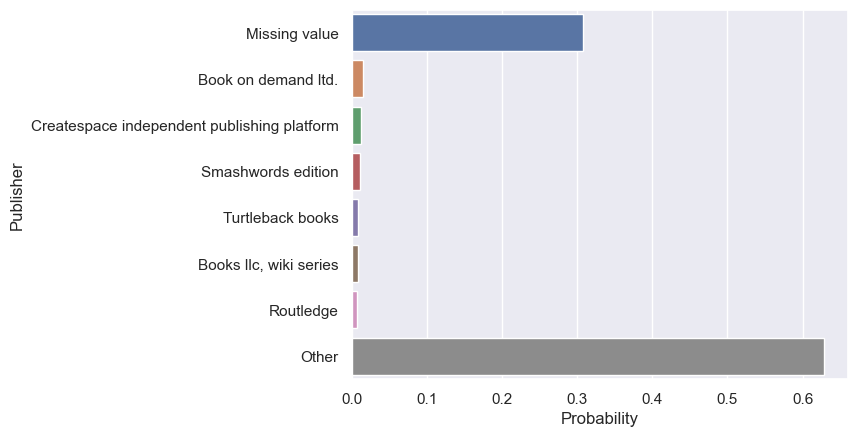

In [37]:
# barplot 
sns.set(style="darkgrid")  
n = sum(publisher_summary['Frequency'])
sns.barplot(x=(publisher_summary.Frequency / sum(publisher_summary.Frequency)), y=publisher_summary.Publisher)
plt.xlabel("Probability")
plt.ylabel("Publisher")

plt.show()

##### ### *Format* 

In [4]:
if Flag:
    # extraction of the format variable
    books_format = pd.DataFrame()
    format = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['format']]
        format.append(processed_chunk)

    books_format = pd.concat(format, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_format.to_json('books_format.json', orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_format=pd.read_json('books_format.json',lines=True)

0it [00:00, ?it/s]

In [12]:
format_summary = qualitative_statistic(books_format, 7)
format_summary

Format  Frequency Percentage
0       Paperback  2247613.0    31.98 %
1   Missing value  2240100.0    31.88 %
2       Hardcover   979886.0    13.94 %
3           Ebook   900712.0    12.82 %
4  Kindle edition   154234.0     2.19 %
5        Audio cd   120212.0     1.71 %
6           Other   384674.0      5.5 %

Since this is a qualitative variable it is not possible to perform quantitative statistics on it. Since the number of levels is too high to be represented in its entirety, a limit has been set on the representation of the $7$ most common levels with the corresponding frequency and all the others have been merged under the heading `Other` and the frequencies of them have been added. 

In this case, although the preliminary analysis did not result NaN values it was noticed that $31.88\%$ of the authors present the $''$ level which was renamed as `Missing value` in addition, this level is the second most common while the most common is the *Paperback* that occurred in the $31.98\%$ of the books. After these, the most common book format are *Hardcover*, with the $13.94\% of relative frequency, and *Ebook* with the $12.82\%. On the bottom of the list there are *Audio CD* and *Kindle Edition* which have relative frequencies around $2\%$ while the other levels form only the $5.5\%$.

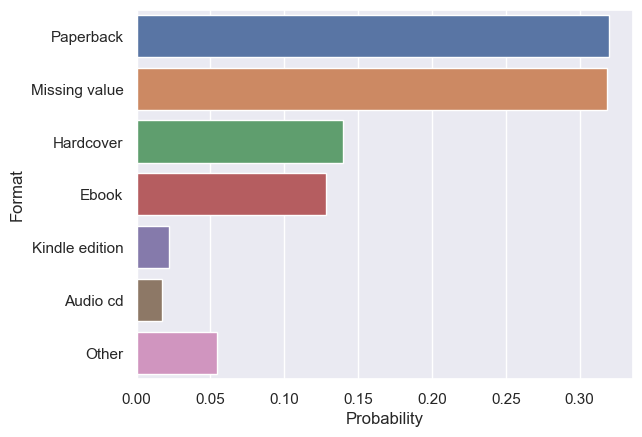

In [55]:
# barplot
sns.set(style="darkgrid")  
n = sum(format_summary['Frequency'])
sns.barplot(x=(format_summary.Frequency / sum(format_summary.Frequency)), y=format_summary.Format)
plt.xlabel("Probability")
plt.ylabel("Format")

plt.show()

##### ### *Language* 

In [5]:
if Flag:
    # extraction of the language variable
    books_language = pd.DataFrame()
    language = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['language']]
        language.append(processed_chunk)

    books_language = pd.concat(language, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_language.to_json('books_language.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_language=pd.read_json('books_language.json',lines=True)

0it [00:00, ?it/s]

In [13]:
language_summary = qualitative_statistic(books_language, 7)
language_summary

Language  Frequency Percentage
0  Missing value  4340264.0    61.76 %
1            Eng  1372114.0    19.53 %
2            Ger   148087.0     2.11 %
3            Spa   137292.0     1.95 %
4            Ita   125287.0     1.78 %
5            Fre   121062.0     1.72 %
6          Other   783325.0     11.1 %

Since this is a qualitative variable it is not possible to perform quantitative statistics on it. Since the number of levels is too high to be represented in its entirety, a limit has been set on the representation of the $7$ most common levels with the corresponding frequency and all the others have been merged under the heading `Other` and the frequencies of them have been added. 

In this case, although the preliminary analysis did not result NaN values it was noticed that $61.76\%$ of the authors present the $''$ level which was renamed as `Missing value` in addition, this level is the most common. As we might expect, the most common language in books is English, which occurs in $\sim20\%$ of cases. The other four more common languages detected have similar frequencies around $2\%$ and are all European languages. The remaining levels that have been merged represent only the $11\%$ of the books. Due the high number of missing values all these percentages could and probably are not representative of the actual frequency of a language.

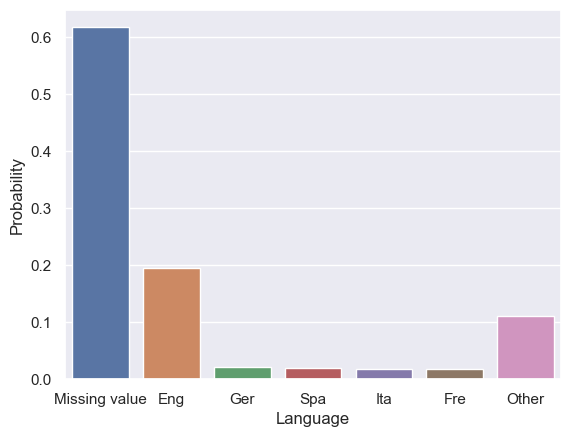

In [57]:
# barplot
sns.set(style="darkgrid")  
n = sum(language_summary['Frequency'])
sns.barplot(x=language_summary.Language, y=(language_summary.Frequency / sum(language_summary.Frequency)))
plt.xlabel("Language")
plt.ylabel("Probability")

plt.show()

##### ### *Average Rating*

In [6]:
if Flag:
    # extraction of the average_rating variable
    books_avg_rating = pd.DataFrame()
    avg_rating = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['average_rating']]
        avg_rating.append(processed_chunk)

    books_avg_rating = pd.concat(avg_rating, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_avg_rating.to_json('books_avg_rating.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_avg_rating=pd.read_json('books_avg_rating.json',lines=True)

0it [00:00, ?it/s]

In [14]:
average_rating_summary = statistic(books_avg_rating)
average_rating_summary

Variable      Count  Mean   Std  Min   25%   50%   75%  Max    CV  \
0  average_rating  7027431.0  3.31  1.44  0.0  3.36  3.81  4.08  5.0  0.43   

   Range  IQ Range Zeros (%)  Negative (Freq)  
0    5.0      0.72    14.4 %                0

In the varibile `average_rating`, similar to the same variable in the other dataframe, we have observed an average value of $3.31$ and a median value of $3.81$ and again this difference indicates that the distribution is slightly asymmetric to the left caused by the $14.4\%$ of the books that have no reviews. Even in this case the length range equal to $5$ goes as expected from the minimum average rating obtainable at the maximum obtainable and tells us nothing more that there is at least one book which has reached either the maximum or the minimum score obtainable. More interesting is the IQR that with a length of $0.72$ tells us that the $50 \%$ of the books differ in the average score for just less than a point. Again, due to the large difference between the interqualtile range and the range we have the confirmation of the presence of outlier which in this case are easily detectable as the books with an average grade equal to zero. All of this can bee seen in the boxplot below.

Thanks to the observation of the standard deviation(Std) and the coefficient of variation(CV) we can say that there is variability in the average ratings score but not very marked despite the presence of outliers.

In the histogram below the distribution of the variable has been represented clearly showing the asymmetry of the distribution and we can also clearly see the outliers around the zero, while almost the entire distribution is concentrated in votes ranging from 3 to 5 with a marked peak on 4 representing the modal value.

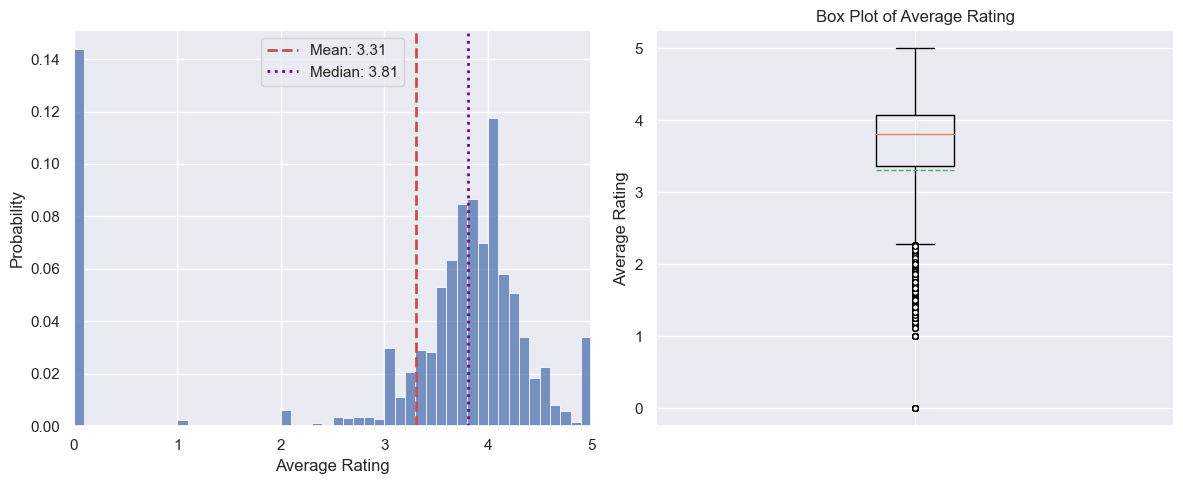

In [18]:
# 
fig, axes = plt.subplots(1,2, figsize=(12, 5))

# First plot: histogram
sns.set(style="darkgrid")
sns.histplot(books_avg_rating['average_rating'], bins=50, stat="probability", ax=axes[0])
axes[0].set_xlim(0, 5)
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Probability")
axes[0].axvline(float(average_rating_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {average_rating_summary["Mean"][0]}')
axes[0].axvline(float(average_rating_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {average_rating_summary["50%"][0]}')
axes[0].legend()

sns.set(style="darkgrid")  
flier_marker = dict(marker='o', markerfacecolor='white', markersize=4, linestyle='none')
axes[1].boxplot(books_avg_rating['average_rating'], flierprops=flier_marker, meanline=True, showmeans=True)
axes[1].set_title('Box Plot of Average Rating')
axes[1].set_ylabel('Average Rating')
axes[1].set_xticks([1],[''])

# 
plt.tight_layout()
plt.show()

##### ### *Ratings Count*

In [7]:
if Flag:
    # extraction of the ratings_count variable
    books_ratings_count = pd.DataFrame()
    ratings_count = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['ratings_count']]
        ratings_count.append(processed_chunk)

    books_ratings_count = pd.concat(ratings_count, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_ratings_count.to_json('books_ratings_count.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_ratings_count=pd.read_json('books_ratings_count.json',lines=True)

0it [00:00, ?it/s]

In [19]:
ratings_count_summary = statistic(books_ratings_count)
ratings_count_summary

Variable      Count      Mean        Std  Min  25%   50%    75%  \
0  ratings_count  7027431.0  19458.61  160900.76  0.0  3.0  45.0  771.0   

         Max    CV      Range  IQ Range Zeros (%)  Negative (Freq)  
0  7400639.0  8.27  7400639.0     768.0    14.4 %                0

In the varibile `ratings_count` has been observed an average value of $19458.61$ number of reviews and a median value of $45.0$. This difference indicates that the distribution is strongly asymmetric to the right and thanks to the very high range, especially in relation to the interquartile range (IQR), we can assume that in the variable there are some outliers that affect the mean statistic, like the $14.4\%$ of the books that have no ratings. Regarding the variability, thanks to the observation of the standard deviation(Std) and the coefficient of variation(CV) we can say that the variability is very high consistent with what has been found by reading the other statistics.

In the histogram below the distribution of the variable has been represented and from the cumulative probability it can be observed that around $\sim 65\%$ of the books has less than $\sim 200$ number of reviews.

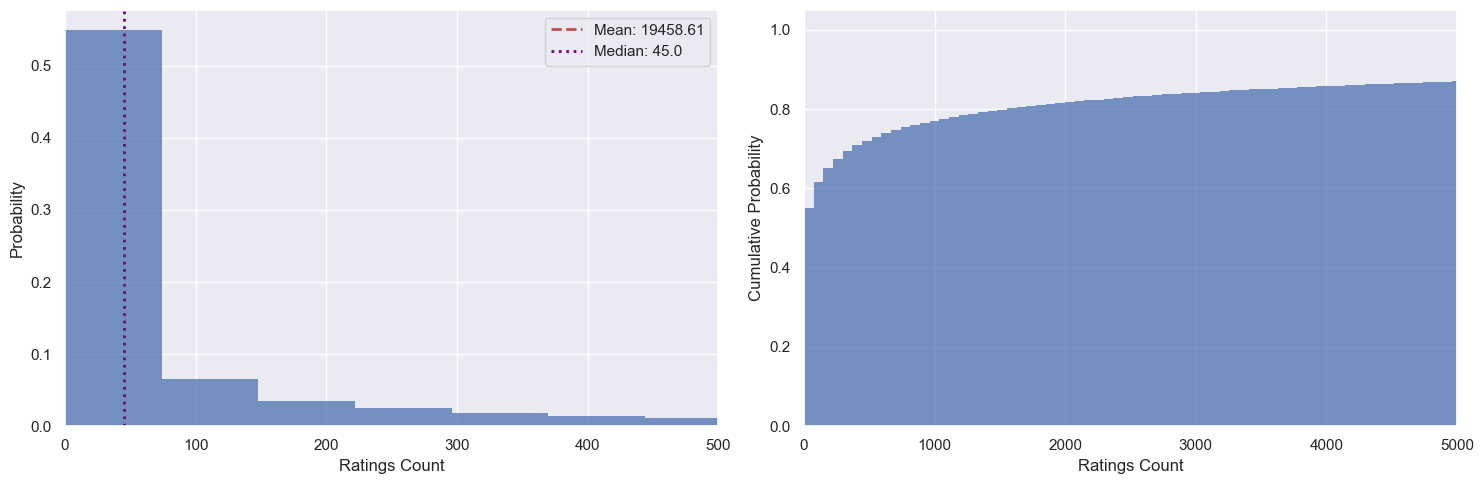

In [85]:
# 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First plot: histogram
sns.set(style="darkgrid")
sns.histplot(books_ratings_count['ratings_count'], bins=100000, stat="probability", ax=axes[0])
axes[0].set_xlim(0, 500)
axes[0].set_xlabel("Ratings Count")
axes[0].set_ylabel("Probability")
axes[0].axvline(float(ratings_count_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {ratings_count_summary["Mean"][0]}')
axes[0].axvline(float(ratings_count_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {ratings_count_summary["50%"][0]}')
axes[0].legend()

# Second plot: Cumulative histogram
sns.set(style="darkgrid")
sns.histplot(books_ratings_count['ratings_count'], bins=100000, stat="probability", cumulative=True, ax=axes[1])
axes[1].set_xlim(0, 5000)
axes[1].set_xlabel("Ratings Count")
axes[1].set_ylabel("Cumulative Probability")

# 
plt.tight_layout()
plt.show()

##### ### *Text reviews count*

In [8]:
if Flag:
    # extraction of the text_reviews_count variable
    books_text_reviews_count = pd.DataFrame()
    text_reviews_count = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['text_reviews_count']]
        text_reviews_count.append(processed_chunk)

    books_text_reviews_count = pd.concat(text_reviews_count, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_text_reviews_count.to_json('books_text_reviews_count.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_text_reviews_count=pd.read_json('books_text_reviews_count.json',lines=True)

0it [00:00, ?it/s]

In [20]:
text_reviews_count_summary = statistic(books_text_reviews_count)
text_reviews_count_summary

Variable      Count    Mean      Std  Min  25%  50%   75%  \
0  text_reviews_count  7027431.0  641.73  4169.81  0.0  0.0  5.0  64.0   

        Max   CV     Range  IQ Range Zeros (%)  Negative (Freq)  
0  174524.0  6.5  174524.0      64.0    29.8 %                0

In the varibile `text_reviews_count` has been observed an average value of $641.73$ number of reviews and a median value of $5.0$. This difference indicates that the distribution is strongly asymmetric to the right and thanks to the very high range, especially in relation to the interquartile range (IQR), we can assume that in the variable there are a some outliers that affect the mean statistic. Thanks to the observation of the standard deviation(Std) and the coefficient of variation(CV) we can say that the variability of the distribution is very high, consistent with what has been found by reading the other statistics.

Comparing the number of books who have zero textual reviews ($29.8\%$) with the number of 'Zeros' in the 'Ratings Count' variable we can assume that readers are less likely to leave written in the same way as it was already been observed even for the authors.

In the histogram below the distribution of the variable has been represented showing the strong asymmetric and from the cumulative probability it can be observed that $\sim 80\%$ of the books has less than $100$ text reviews.

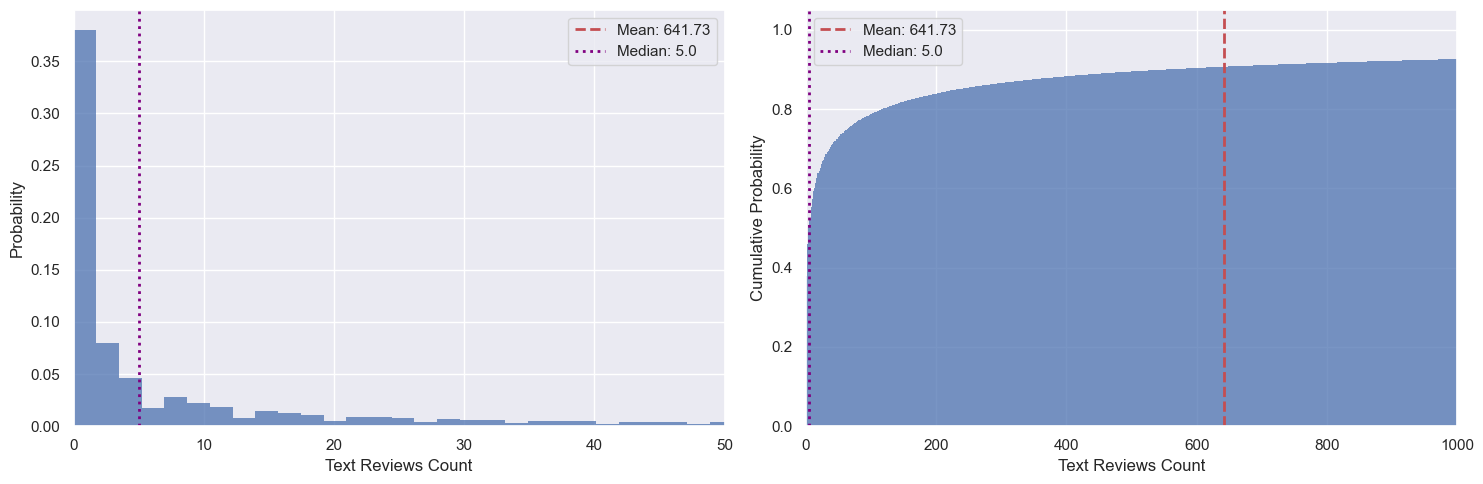

In [91]:
# 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First plot: histogram
sns.set(style="darkgrid")
sns.histplot(books_text_reviews_count['text_reviews_count'], bins=100000, stat="probability", ax=axes[0])
axes[0].set_xlim(0, 50)
axes[0].set_xlabel("Text Reviews Count")
axes[0].set_ylabel("Probability")
axes[0].axvline(float(text_reviews_count_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {text_reviews_count_summary["Mean"][0]}')
axes[0].axvline(float(text_reviews_count_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {text_reviews_count_summary["50%"][0]}')
axes[0].legend()

# Second plot: Cumulative histogram
sns.set(style="darkgrid")
sns.histplot(books_text_reviews_count['text_reviews_count'], bins=100000, stat="probability", cumulative=True, ax=axes[1])
axes[1].set_xlim(0, 1000)
axes[1].set_xlabel("Text Reviews Count")
axes[1].set_ylabel("Cumulative Probability")
axes[1].axvline(float(text_reviews_count_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {text_reviews_count_summary["Mean"][0]}')
axes[1].axvline(float(text_reviews_count_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {text_reviews_count_summary["50%"][0]}')
axes[1].legend()

# 
plt.tight_layout()
plt.show()

##### ### *Num page*

In [9]:
if Flag:
    # extraction of the num_pages variable
    books_num_pages = pd.DataFrame()
    num_pages = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['num_pages']]
        num_pages.append(processed_chunk)

    books_num_pages = pd.concat(num_pages, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_num_pages.to_json('books_num_pages.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_num_pages=pd.read_json('books_num_pages.json',lines=True)

0it [00:00, ?it/s]

In [93]:
num_pages_summary = pages_statistic(books_num_pages)
num_pages_summary

Variable      Count     Mean         Std  Min    25%    50%    75%  \
0  num_pages  3955596.0  3049.87  2327716.91  0.0  132.0  232.0  344.0   

            Max      CV         Range  IQ Range Zeros (%)  Negative (Freq)  
0  2.147484e+09  763.22  2.147484e+09     212.0     0.4 %                0

In the varibile `num_pages` has been observed an average value of $3049.87$ number of pages per book and a median value of $235.0$. This difference indicates that the distribution is strongly asymmetric to the right clear even by the difference between the extremly high range and the interquartile range (IQR). Observing the maximum value equal to $2.147484e+09$ we can affirm with certainty that in the dataset there are a some influent outliers with an extremly high number of pages that affect significantly the mean statistic. This is inevitably also reflected on the standard deviation and on the coefficient of variation that has the highest value recorded throughout the entire dataset making it the attribute with the highest variability over all the books dataset.

In the histogram below the distribution of the variable has been represented showing the strong asymmetric and that the entire distribution goes from $0$ to $2000$ pages but the median value is still 

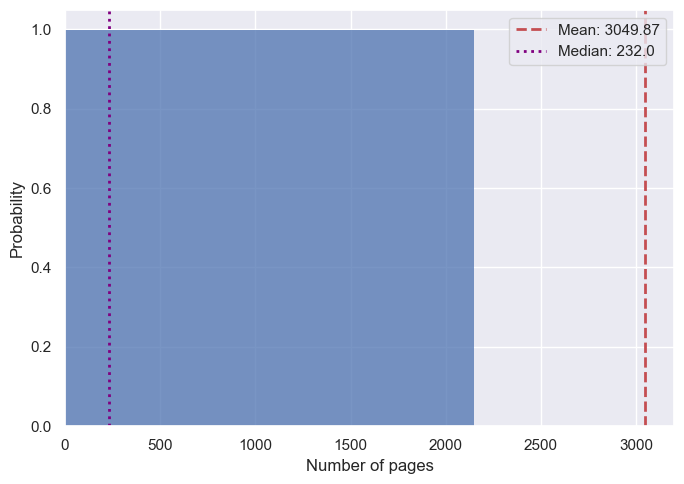

In [94]:
# 
fig, axes = plt.subplots(figsize=(7, 5))

sns.set(style="darkgrid")
sns.histplot(books_num_pages['num_pages'], bins=1000000, stat="probability", ax=axes)
axes.set_xlim(0, 3200)
axes.set_xlabel("Number of pages")
axes.set_ylabel("Probability")
axes.axvline(float(num_pages_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {num_pages_summary["Mean"][0]}')
axes.axvline(float(num_pages_summary['50%'][0]), color='purple', linestyle='dotted', linewidth=2, label=f'Median: {num_pages_summary["50%"][0]}')
axes.legend()
# 
plt.tight_layout()
plt.show()

#### ## *Correlation*

In [16]:
Flag = True
if Flag:
    # extraction of the quantitative variable
    books_correlation = pd.DataFrame()
    correlation = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['ratings_count', 'average_rating', 'text_reviews_count', 'num_pages']]
        
        # cleaning condition
        processed_chunk = processed_chunk[ (processed_chunk['ratings_count']  > 0)]
        processed_chunk = processed_chunk[ (processed_chunk['text_reviews_count']  > 0)]
        processed_chunk = processed_chunk[ (processed_chunk['average_rating']  > 0)]
        processed_chunk['num_pages'] = pd.to_numeric(processed_chunk['num_pages'], errors='coerce')
        processed_chunk = processed_chunk[ (processed_chunk['num_pages']  > 0)]
        processed_chunk = processed_chunk[ (processed_chunk['num_pages']  < 5000)]
        
        correlation.append(processed_chunk)

    books_correlation = pd.concat(correlation, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_correlation.to_json('books_correlation.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_correlation=pd.read_json('books_correlation.json',lines=True)

0it [00:00, ?it/s]

In [18]:
# correlation matrix
round(books_correlation.corr(),2)

ratings_count  average_rating  text_reviews_count  \
ratings_count                1.00            0.07                0.90   
average_rating               0.07            1.00                0.08   
text_reviews_count           0.90            0.08                1.00   
num_pages                    0.06            0.15                0.08   

                    num_pages  
ratings_count            0.06  
average_rating           0.15  
text_reviews_count       0.08  
num_pages                1.00

Through the linear correlation matrix we can say that:

- a high *average* value of `text_reviews_count` corresponds to a high *average* value of `ratings_count` with a correlation value of $0.90$.

These *average* trends are also visible in the scatterplots below.

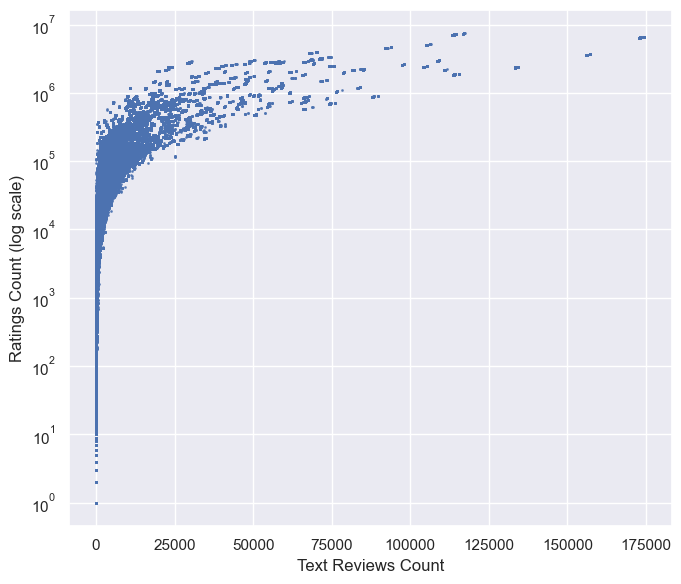

In [21]:
fig, axes = plt.subplots(figsize=(7, 6))
sns.set(style="darkgrid")

# First scatterplot between text_reviews_count and ratings_count
axes.scatter(books_correlation['text_reviews_count'], books_correlation['ratings_count'], alpha=0.8, s=1)
axes.set_yscale('log')
axes.set_xlabel('Text Reviews Count')
axes.set_ylabel('Ratings Count (log scale)')

plt.tight_layout()
plt.show()

---

## #RQ2 - Retrieving some vital information

### 1) Plot the number of books for each author in descending order.

In [2]:
trunk_columns =['title', 'author_name' ,'author_id', 'language', 'average_rating ', 'ratings_count', 'text_reviews_count', 'publication_date', 'original_publication_date', 'num_pages', 'series_id','series_name']

newdata = pd.DataFrame( columns=trunk_columns)

for chunk in pd.read_json(' lighter_books.json', lines=True, chunksize=10000) :
    chunk =chunk[ trunk_columns]
    newdata =pd.concat([newdata,chunk], ignore_index=True )

newdata.to_json( 'books_small.json', orient= 'records' , lines=True)

In [3]:
df= pd.read_json( "books_small.json", lines=True )

In [4]:
authors_list=df['author_id' ].tolist()

In [28]:
df_author = Counter(authors_list)
first= list(df_author.items())
short = pd.DataFrame(first, columns= ['Author', 'Books' ])
short_sort= short.sort_values (by='Books',ascending=False)

first50= short_sort.head(50)


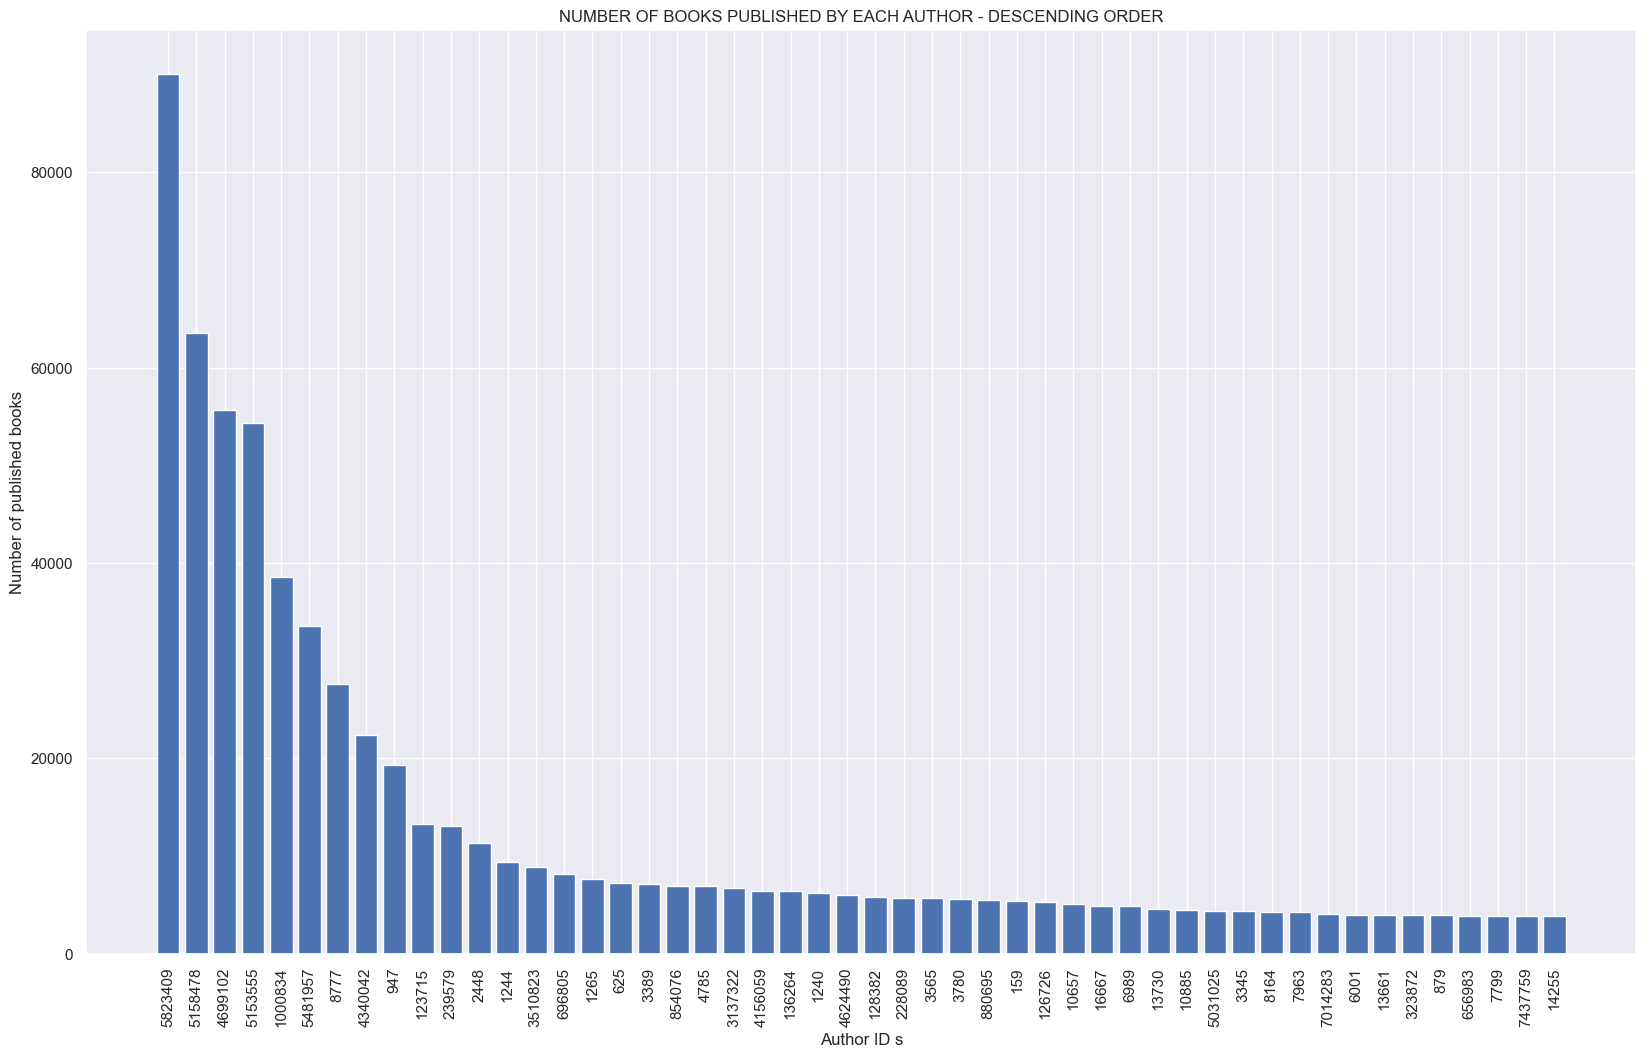

In [29]:
x_line=first50['Author'].tolist()
xx = [str(number) for number in x_line] 

y_line = first50['Books'].tolist()


plt.figure(figsize=(20,12))
plt.bar(xx, y_line)

plt.xlabel( 'Author ID s')
plt.ylabel('Number of published books')

plt.title('NUMBER OF BOOKS PUBLISHED BY EACH AUTHOR - DESCENDING ORDER')
plt.xticks( rotation= 90)

plt.show()

### 2) Which book has the highest number of reviews?

In [14]:
highest_nr = df['text_reviews_count'].max()
highest_nr_b = df.loc[df['text_reviews_count'] == highest_nr, 'title'].values[0]

print(f'The book with the highest number of reviews was {highest_nr_b} with {highest_nr} reviews')

The book with the highest number of reviews was The Hunger Games (Hunger Games, #1) with 174524 reviews


### 3) Which are the top ten and ten worst books concerning the average score?

In [15]:
srt_df= df.sort_values(by='average_rating', ascending=True)
best_10= srt_df.head(10)
worst_10 = srt_df.tail(10)
print( "The top 10 books, with the lowest average score:")

for index,row in best_10.iterrows() :
    print (row['title'] + " : " + str(row[ 'average_rating']))
    
print( )

print( "The 10 worst books, with the highest average score:" )
for index, row in worst_10.iterrows():
    print(row['title'] + " : " + str(row['average_rating']))

The top 10 books, with the lowest average score:
Die Blut-Fahne Ausgestecket Zur Warnung Politischer Wegweiser in America, Oder, Eine Getreue Erz Hlung Einer Grossen Anzahl Handlungen Der Abscheulichsten Grausamkeiten, Solche ALS Nie Ein Auge Gesehen, Nie Eine Zunge Ausgesprochen, Oder Die... : 0.0
Imagining Robin Hood: The Late-Medieval Stories in Historical Context : 0.0
British Foreign Secretaries in an Uncertain World, 1919-1939 : 0.0
DNA Methylation: Approches, Methods, and Applications : 0.0
Six Great Poets: Chaucer, Pope, Wordsworth, Shelley, Tennyson, The Brownings : 0.0
Post-Bubble Us Economy: Implications for Financial Markets and the Economy : 0.0
Rating Management's Effectiveness: With Case Studies in Telecommunications : 0.0
Managing Development: Measures of Success and Failure in Development : 0.0
The Edge of Life: Human Dignity and Contemporary Bioethics : 0.0
Nigerian Historical Studies : 0.0

The 10 worst books, with the highest average score:
Etudes Sur La Littérature

### 4) Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

In [16]:
limbi = pd.read_json('books_small.json', lines=True)
colum1 = 'language'
data_fr = limbi[limbi[colum1].str.strip() != '']
data_fr.to_json('data_js.json',orient='records', lines=True)

In [17]:
l_clean = pd.read_json('data_js.json',lines=True)
languages = l_clean['language'].tolist()

elem_c = Counter(languages)

lang = pd.DataFrame(list(elem_c.items()), columns=['Language', 'Books'])

In [18]:
ptt= r"en-.{2}"
nr = 0
numb =0

for index, row in lang.iterrows():
    if re.match(ptt, row['Language']):
        numb+=1
        nr =nr+row['Books']
        lang = lang.drop(index)
lang.iloc[0,1]+=nr

In [19]:
for index,rows in lang.iterrows() :
    if rows['Language']== '--' :
        lang = lang.drop(index)

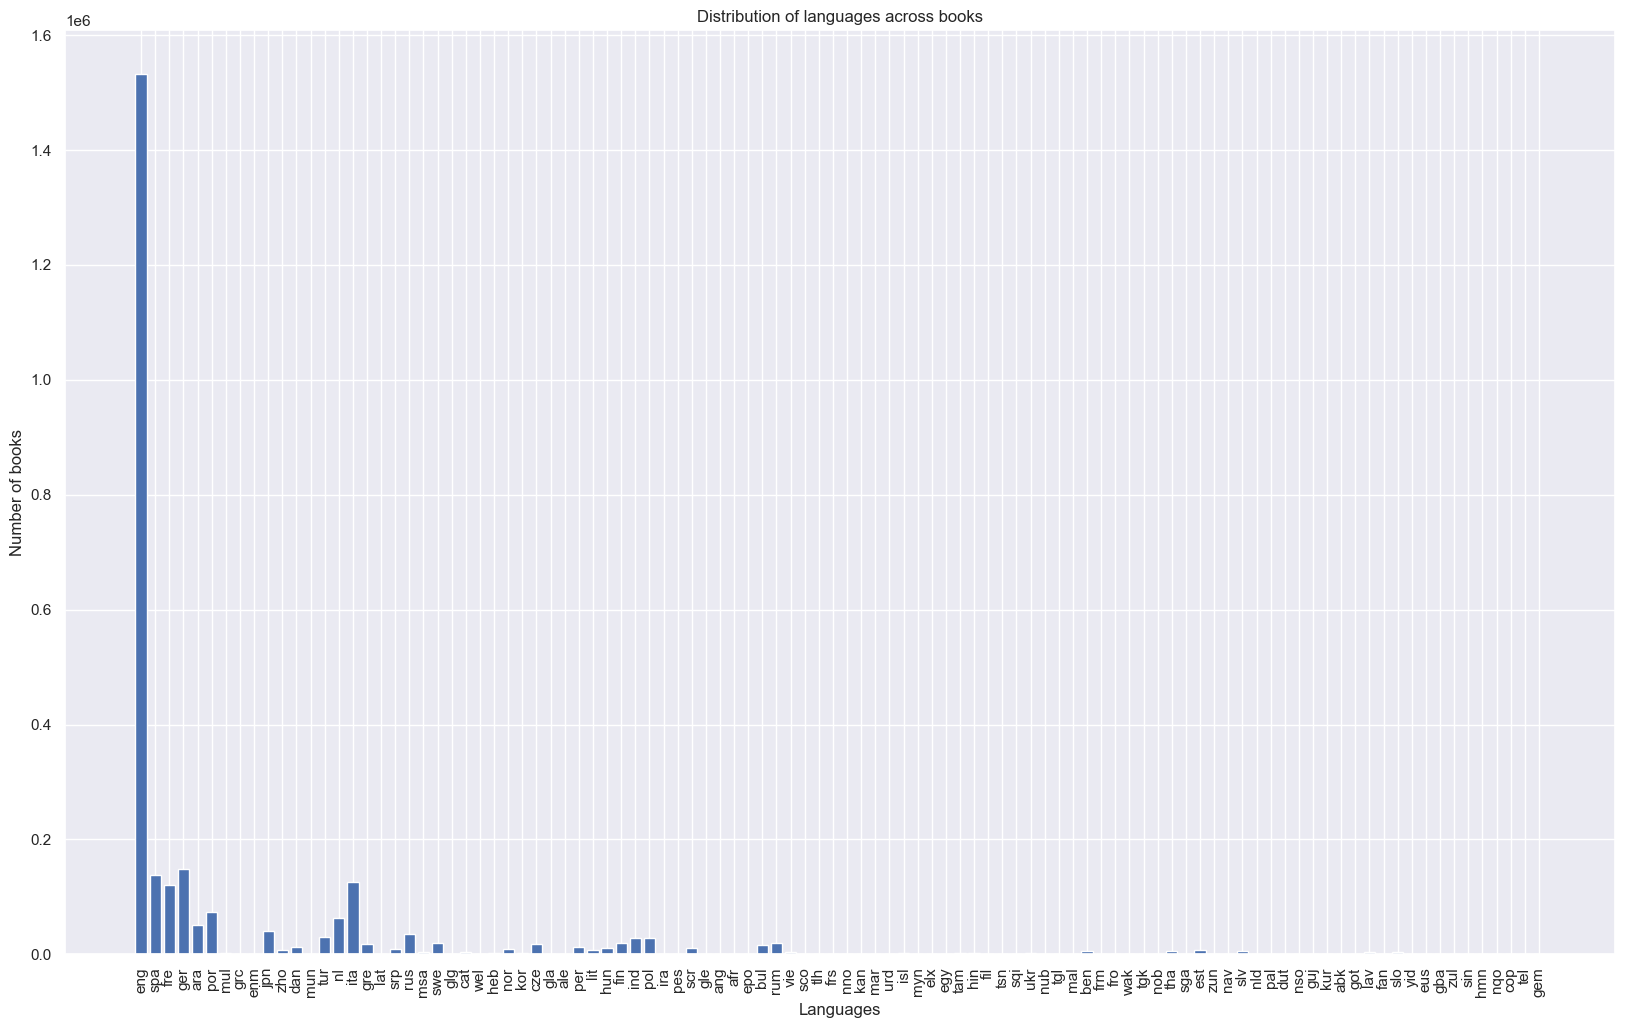

In [30]:
x_line =lang['Language'].tolist()

x_x = x_line[:100]
y_line = lang['Books'].tolist( )
y_y = y_line[:100]

plt.figure(figsize=(20,12))
plt.bar(x_x , y_y)

plt.xlabel ('Languages')
plt.ylabel( 'Number of books')
plt.title('Distribution of languages across books')

plt.xticks(rotation=90)

plt.show( )

### 5) How many books have more than 250 pages?

In [22]:
books_250 = 0
for i in df['num_pages']:
    try:
        num_pages = int(i)
        if num_pages > 250:
            books_250 += 1
    except (ValueError, TypeError):
        # Handle non-integer values or missing values
        pass
print("The number of books with more than 250 pages :", books_250)

The number of books with more than 250 pages : 1810335


### 6) Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).


In [23]:
authors_l = pd.read_json("lighter_authors.json", lines=True)

In [24]:
fans=[]
top = short_sort.head(50)
prolific =top['Author'].tolist( )
for index, row in authors_l.iterrows():
    if row['id'] in prolific:
        fans.append(row['fans_count'])

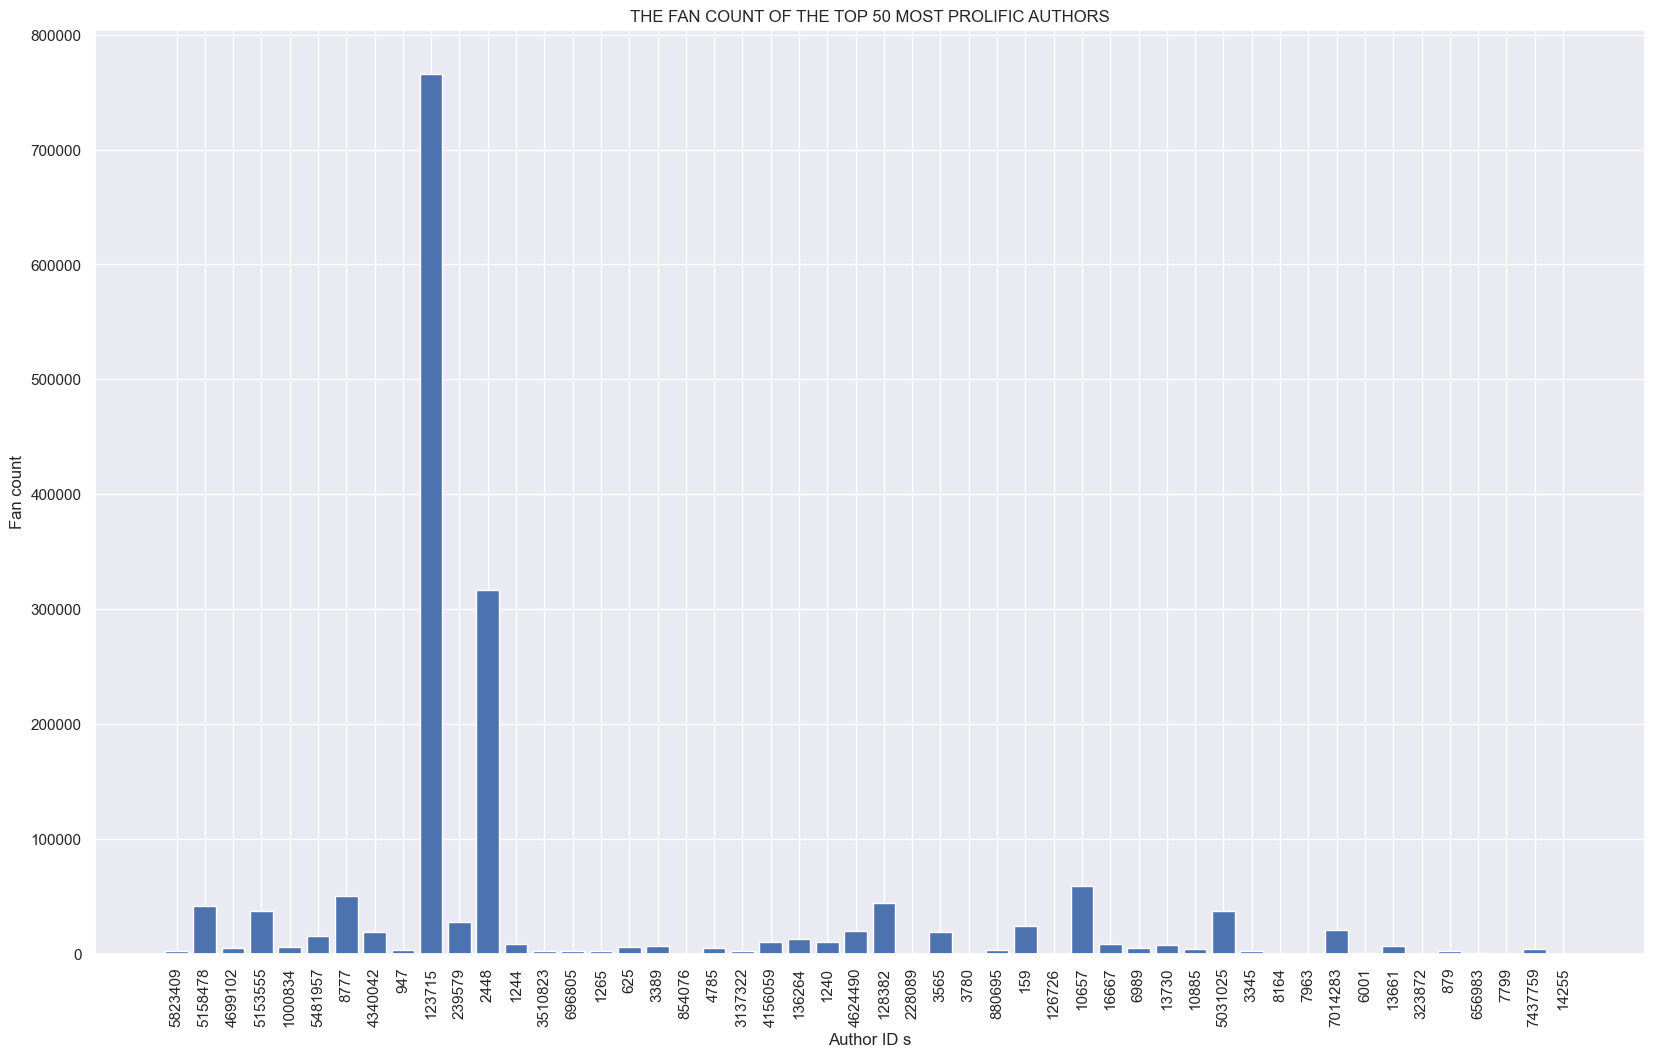

In [25]:
prolific50 = [str(number) for number in prolific]

plt.figure(figsize=(20, 12))
plt.bar(prolific50,fans)
plt.xlabel('Author ID s')
plt.ylabel('Fan count')
plt.title("THE FAN COUNT OF THE TOP 50 MOST PROLIFIC AUTHORS")

plt.xticks(rotation=90)
plt.show()

---

## #RQ3 - Historical look at the dataset!

### 1) Function

Write a function that takes as input a year and returns as output the following information:

- The number of books published that year.

- The total number of pages written that year.

- The most prolific month of that year.

- The longest book written that year.

In [ ]:
def rq3(year, df):
    import pandas as pd
    from collections import defaultdict
    import re
    import calendar

    months_counts = defaultdict(int)
    longest_book = None
    most_prolific_month = None
    
    # Filter to get only the books published in the input year
    df = df[df['publication_date'].str.startswith(str(year))]
    df = df[df['num_pages'] != ""]  # drop rows with non valid num_pages values 

    books_published = len(df) # number of books published that year
    
    pages_written = df['num_pages'].astype(int).sum() # the number of pages written that year

    # Find the max number of pages of the year
    max_pages = df['num_pages'].astype(int).max() # find the max number of pages whitin the batch

    # Find the longest book of the year
    longest_books = df[df['num_pages'] == max_pages]  # Filter books with the maximum number of pages

    if not longest_books.empty:
        longest_book = longest_books['title'].values[0] 
         
    # Filter only rows where the publication date contains the month of the year
    df = df[df['publication_date'].str.match(r'([1-9]{1}\d{0,3})(-\d{2}){1,2}')]
        
    # Extract the month from the 'original_publication_date' column and add a temporary column with the month
    df['publication_month'] = df['publication_date'].str.split('-').str[1]

    # Group data by month and count the number of books published in each month and then update the dictionary
    months_counts = df.groupby('publication_month').size().to_dict()
    
    # Find the most prolific month and then convert the month number to the corrisponding name
    series = pd.Series(months_counts, dtype=int)
    
    if not series.empty:
        month = series.idxmax() # extract the month with most books published
        most_prolific_month = calendar.month_name[int(month)]

    return([year, books_published, pages_written, most_prolific_month, longest_book])


I defined the function "rq3," which takes as input a year and a dataframe and produces a list that includes the year, the number of books published, the total number of pages written, the most prolific month of the year, and the title of the longest book.

### 2) Build your data frame using your function


To create a new dataframe with the years as primary keys and the required information as attributes, I performed a series of steps:

Firstly, I generated a new json file named "books_rq3.json" by extracting only three columns from the original dataset, removing rows with no valid values. This approach allows loading the entire contents of the file without having to read it in chunks each time.

In [2]:
flag = True  # set the flag True to execute (run it only once)

if flag:
    # Intialize a new DataFrame 
    new_data = pd.DataFrame()

    # Read the JSON file in chunks
    chunk_size = 10000  
    chunks = []

    for chunk in pd.read_json('lighter_books.json', lines = True, chunksize = chunk_size):
        processed_chunk = chunk[ ['title', 'publication_date', 'num_pages'] ] # extract the needed columns


        processed_chunk['num_pages'] = pd.to_numeric(processed_chunk['num_pages'], errors='coerce')  # converts the 'num_pages' column to numeric data type and handles any errors by coercing them to NaN.
        processed_chunk = processed_chunk[processed_chunk['num_pages'] > 0]
        processed_chunk = processed_chunk.dropna(subset=['title', 'publication_date', 'num_pages']) # drops rows with missing values in the columns 'title', 'publication_date', and 'num_pages' 
        
        chunks.append(processed_chunk)

    new_data = pd.concat(chunks, ignore_index = True)

    # save the dataset in a new JSON file
    new_data.to_json('books_rq3.json', orient='records', lines=True)


Next, I extracted all valid years from the "publication_date" column of the dataset. For each year, I called the rq3 method and added the result to a list. 

Finally, after collecting the information for each year, I created a new dataframe from this list and saved it in a JSON file called "years_stats.json." This approach provides quick and easy access to the information, without the need to re-run the entire process, which would be time consuming.

In [3]:
flag = True  # set the flag True to execute (run it only once)

if flag:
    # Read the JSON file and create a dataframe for the books
    books = pd.read_json('books_rq3.json', lines=True)
       
    # Initialize the list with all the years to insert in the new dataframe
    years = allTheYears(books)

    # Create the dataset with all the informations 
    stats = [rq3(year, books) for year in years]
    df = pd.DataFrame(stats, columns=['year', 'books', 'pages','month', 'title'])   

    df.to_json('years_stats.json', orient='records', lines=True)  # save the dataframe in a new JSON file 

Now we can print the head and the tail of the new dataframe.

In [4]:
# head
stats = pd.read_json('years_stats.json', lines=True)    # Read the JSON file we created 
stats = stats.set_index("year")                         # set the year as index (primary key), this way we can access to records by year 
stats = stats.dropna(subset=['month'])                  # drop rows with missing informations

stats.head(10)

books       pages     month  \
year                                  
10         62       18846   October   
11         28        9621  November   
12         52       15040  December   
13        946      261371   January   
14        231       54929   January   
15         64       14546   January   
16         81       21775   January   
17        216       71450     April   
19     903609  4540312729   January   
20    2864476  3183247907   January   

                                                  title  
year                                                     
10                      Lügat-ı Manzum (Tuhfe-i Lami'i)  
11                                               На дне  
12                         Diccionario de psicoanálisis  
13                                         هزار‌و‌يک شب  
14    حقوق المواطنة: حقوق غير المسلم في المجتمع الإس...  
15                                  Actes and Monuments  
16                          Mañana será demasiado tarde  
17    Royal Genealogies; or, The Genealogical Tables...  
19                         Les grands mystères du passé  
20                                A Half Forgotten Song

In [5]:
# tail
stats.tail(10)

books     pages      month  \
year                                
2014  337187  95976782        May   
2015   86454  24430905    January   
2016    6607   2020339    January   
2017    2284    696801    January   
2018    2882    957889      April   
2019    1211    369031    January   
2020     687    211268    January   
2021     158     48316    January   
2022       7      2062    January   
2023       2       713  September   

                                                  title  
year                                                     
2014    Fermata Qt8 - Storie Ripensate in Metropolitana  
2015                                       Buddenbrooks  
2016                                          Homestuck  
2017        মানিক-রচনাবলী (ঐতিহ্য মানিক রচনাবলী, #১-১০)  
2018  Theory of Knowledge (Tok) (Student Book and Et...  
2019  Visions of America: A History of the United St...  
2020             Negotiating and Drafting Office Leases  
2021                                           Policing  
2022  Weltgesellschaft: Raum - Kommunikation - Herrs...  
2023                                         Apocalypse

### 3)Comparison with ChatGPT

For task 3 of RQ3, I asked ChatGPT to implement the same function that I did for task 1, giving the chatbot the description provided in the GitHub repository and also a few lines from the original json file so that it could learn the structure of the dataset being used, but not providing any indication of how the reading should take place or other issues with the dataset that I encountered while performing task 1.

The following is the function I obtained by interacting with ChatGPT:

In [3]:
def historical_stats(year):
    # Read the json file in a DataFrame 
    df = pd.read_json("books_rq3.json", lines=True)

    # Extract the data regarding the year of interest
    year_data = df[df['publication_date'].str.startswith(str(year))]

    num_books = len(year_data)
    total_pages = year_data['num_pages'].sum()  

    if len(year_data) > 0:
        year_data['month'] = pd.to_datetime(year_data['publication_date'], errors='coerce').dt.month
        most_prolific_month = year_data['month'].value_counts().idxmax()
        longest_book = year_data.loc[year_data['num_pages'].idxmax()]['title']
    else:
        most_prolific_month = "N/A"
        longest_book = "N/A"

    return {
        'Year': year,
        'Number of Books Published': num_books,
        'Total Pages Written': total_pages,
        'Most Prolific Month': most_prolific_month,
        'Longest Book': longest_book
    }

# Example usage:
result = historical_stats(2023)
print(result)

{'Year': 2023, 'Number of Books Published': 2, 'Total Pages Written': 713, 'Most Prolific Month': 9, 'Longest Book': 'Apocalypse'}


The function provided could work in some circumstances but there are some issues that could prevent the correct execution or make the function non particular efficient:

- The first problem regarding the way the function reads the dataset:
In the current implementation, the dataset is read within the body of the function: this results in unnecessary reading of the dataset repeatedly when the function is called several times to create the new dataframe, so it is time-consuming; It would be more efficient to read the dataset once outside the function and process it, giving the dataset in input to the function.

- If the dataset is particularly large (as our "lighter_books.json") and local system can't handle reading it all at once, we have a MemoryError; for that reasons the function should read the dataset in chunks, working separately on each chunk or at least read it in chunks previously taking only the needed columns of the dataset to create a new dataframe and then reduce memory usage when the function is called many times.

- The use of Datetime Library can be problematic because it doesn't recognize dates outside a certain range. In some cases, it may not be suitable for datasets with historical dates, as the dataset used in this homework; I tried to use this library in my original function and the result was that I could extract only the years after 1678, so a large part of valid rows of the dataset went lost.

- The function doesn't check for missing values, such as NaN values in 'num_pages' or 'title'; therefore the function doesn't clean the dataset, dropping rows with wrong values, for example negative number of pages. Additionally, when summing the pages of the books, it doesn't handle type casting correctly, which lead to error because the numeric values are provided as strings.

In summary, while the core idea of the function is correct, it would be necessary to interact with the chatbot or seek additional advice to make the function better and fix the issues we've mentioned above, along with any other problems that might occur when the function is executed.

Despite of all this, the function provided by ChatGPT seems to work for more recent years, when instead of the original dataset "lighter_books", the new dataset "books_rq3" is used, which is the dataset I created earlier by reading the original dataset in chunks, cleaning the dataset from rows containing null or invalid values and casting to integers the values of num_pages; In that case the outcome of the function is a dictionary with the year and all the other required information.

---

## #RQ4 - Consistency

### 1) Checking if there are any authors with exactly the same name

In [4]:
df_authors = pd.read_json('lighter_authors.json', lines=True)

# checking for duplicates in the column 'name'
duplicates_count = df_authors['name'].duplicated(keep=False).sum()

if duplicates_count > 0:
    print("There are ", duplicates_count ," duplicate names.")
else:
    print("No duplicate names found.")

There are  74  duplicate names.


There are 74 authors who has exactly the same name which makes the dataset a non-consistent one.

### 2) Retrieving the authors' book IDs based on their author ID

In [ ]:
# A dictionary that contains the author's ID as a key and a list of his book_IDs as value 
author_books_dict = get_books_by_author(df_authors['id'], df_authors)

# A dictionary that contains the author's ID as a key and a the number of books written by him as value
author_books_count = {key: len(value) for key, value in author_books_dict.items()}

author_books_dict

In [ ]:
author_books_count

### 3-4) Finding the longest and the shortest book titles among the top 20 rated authors.

In [6]:
top_20_rated = get_top_rated_authors(df_authors)
top_rated_books = get_books_by_author(top_20_rated, df_authors)

# A list of all the books_IDs written by the top 20 rated authors
top_rated_books_list = [value for sublist in top_rated_books.values() for value in sublist]
#Changing the the Books_IDs dtype from string to to int
top_rated_books_list = list(map(int, top_rated_books_list))

# Dividing the data into chunks to avoid encountering memory errors 
chunks = pd.read_json('lighter_books.json', lines=True, chunksize=10000)


books_titles = []

# Iterate over the chunks and view the head of the first chunk
for chunk in chunks:

    chunk = pd.DataFrame(chunk)
    # Filter the data based on the books' IDs of the top rated 20 authors and adding them to a list
    books_titles = books_titles + chunk[chunk['id'].isin(top_rated_books_list)]['title'].tolist()

books_titles

['Readings in child development',
 'Human Quality Control; The Breeding And Feeding Of Genius',
 'Principles Of Abnormal Psychology',
 'Fundamentals Of Child Development',
 'You Have the Nerve to Call Yourself a Roman Catholic!',
 'Attack Of The Gas Powered Angels',
 'My Mystery Child',
 'Strange Loops',
 'Sara Rose, Kid Lawyer',
 'Broken Mirror',
 'Help with the Hard Stuff: Workbooks for Teens with Type I Diabetes and Their Parents',
 'Architekturführer Island.',
 "Carpenter's Mark",
 'Behavioral Approaches to Chronic Disease in Adolescence: A Guide to Integrative Care',
 'Improving the Quality of Child Custody Evaluations: A Systematic Model',
 'Handbook of Adolescent Health Psychology',
 'History of the Postage Stamps of the United States of America',
 'Übungen für Junge Mathematiker : Teil 4 Gleichungen (Mathematische Schülerbücherei, #87)',
 'Initiation (Best Kept Secret)',
 'The Migraine Diaries #1: Diagnosis [1981]',
 'Fantastic Illusions of Life, Love, the Birds, and the Bees',

In [7]:
longest_title = max(books_titles, key=len)
print('The book with the longest title among the top 20 rated authors is "',longest_title, '"')
print('The title contains',len(longest_title), 'characters')

The book with the longest title among the top 20 rated authors is " Übungen für Junge Mathematiker : Teil 4 Gleichungen (Mathematische Schülerbücherei, #87) "
The title contains 88 characters


- Finding the books with the longest and shortest titles in the entire dataset

In [7]:
chunks = pd.read_json('lighter_books.json', lines=True, chunksize=10000)
longest_title_all_chunks = ''

for chunk in chunks:
    chunk = pd.DataFrame(chunk)
    # The longest title among each data chunk
    temp = max(chunk['title'], key=len)

    if len(temp) > len(longest_title_all_chunks):
        longest_title_all_chunks = temp

print('The book with the longest title in the entire dataset is "', longest_title_all_chunks, '"')
print('the title contains', len(longest_title_all_chunks), 'characters')

The book with the longest title in the entire dataset is " The New England Primer Issued Prior to 1830: A Bibliographical Checklist for the More Easy Attaining the True Knowledge of This Book, Embellished with a Hundred Cuts and Now Revised, Greatly Improved and Arranged in Two Alaphabets; With Preface, Introd... "
the title contains 255 characters


In [8]:
chunks = pd.read_json('lighter_books.json', lines=True, chunksize=10000)
# A list containing the book with the smallest title per each chunk
shortest_list = [] 

for chunk in chunks:
    chunk = pd.DataFrame(chunk)
    # The shortest title among each data chunk
    temp = min(chunk['title'], key=len)

    shortest_list.append(temp)
# exluding the titles with character less than 2 and non-alphabet titles 
shortest_list_filtered = [x for x in shortest_list if len(x) >= 2 and x.isalpha()]
# Finding the minimum in the list after filtering 
shortest_title_all_chunks = min(shortest_list_filtered, key=len)
print('The book with the shortest title in the entire dataset is "', shortest_title_all_chunks, '"')

The book with the shortest title in the entire dataset is " 长老 "


- The book with the longest title among the top 20 rated authors is: **" Übungen für Junge Mathematiker : Teil 4 Gleichungen (Mathematische Schülerbücherei, #87) ".** The title contains **88** characters.

- The book with the longest title in the entire datraset is: **"The New England Primer Issued Prior to 1830: A Bibliographical Checklist for the More Easy Attaining the True Knowledge of This Book, Embellished with a Hundred Cuts and Now Revised, Greatly Improved and Arranged in Two Alaphabets; With Preface, Introd... ".** The title contains **255** characters.

- When I searched the dataset for the book with the shortest title I got " " which means that there is a book that was not given a title. I added a condition that the book's title cannot be empty. After adding the condition, the books with the shortest title was 'a'. I decided to not consider any title that has characters < 2 characters so the title of the book is an actual word. I looped over the chunks found the minimum of each chunk then added the to a list then filtered the list based on the condition mentioned earlier and then I choose the minimum of that list and broke the ties using the alphabetical order.

- The book with the shortest title in the entire datraset is: **" 长老 "** which means "the elder" in English.

---

## #RQ5 -  Authors with the most fans deeper look

### 1) Plotting the top 10 most influential authors regarding their fan count and number of books and finding the most influential author.

In [23]:
# Sorting the authors based on the fans_count
top_10_authors = df_authors.sort_values(by='fans_count', ascending=False).head(10)
# creating a new column called books_count
top_10_authors['books_count'] = top_10_authors['book_ids'].apply(len)
# sorting again by the fans_count and using books_count to break the ties 
top_10_authors = top_10_authors.sort_values(by=['fans_count', 'books_count'], ascending=[False, False])
top_10_authors

ratings_count  average_rating  text_reviews_count  \
1017         15195579            4.04              608956   
169374        5739316            4.05              277033   
6397             9418            3.85                 562   
205870        2239503            4.24              240302   
4537          9144089            4.32              354145   
1161          6514711            3.98              333220   
100166        7186569            4.03              358221   
3818           175216            4.07               16300   
27110         7401435            4.24              416177   
32358          611045            3.88               34482   

                                                 work_ids  \
1017    [849585, 150259, 1742269, 3230869, 1552134, 46...   
169374  [13155899, 15524542, 15524549, 25457412, 19216...   
6397    [321174, 51432387, 314, 1479853, 60054895, 688...   
205870  [21389085, 43940889, 18602144, 24878172, 24878...   
4537    [3346751, 2377629, 43554, 4551489, 2936530, 10...   
1161    [3373984, 881425, 1711194, 1829521, 141228, 88...   
100166  [16827462, 919292, 3364505, 48658, 21576687, 6...   
3818    [52832605, 1204936, 23561, 16946049, 1323039, ...   
27110   [2267189, 3443248, 1575860, 6674837, 6948844, ...   
32358   [15237902, 41897766, 25273867, 60430209, 56458...   

                                                 book_ids  works_count  \
1017    [11588, 830502, 149267, 10614, 10592, 43615, 1...         1762   
169374  [13335037, 11735983, 18710190, 18126198, 13615...           57   
6397    [36603020, 39731947, 41619, 1081637, 41814307,...           12   
205870  [15717943, 27362503, 30333938, 17788401, 24445...           57   
4537    [28187, 2120932, 28186, 4556058, 561456, 77361...          172   
1161    [13145, 13148, 13137, 13152, 7494, 13139, 1313...          747   
100166  [11870085, 99561, 6442769, 49750, 35504431, 65...           57   
3818    [32191710, 20663770, 20663771, 20707975, 20663...           52   
27110   [256683, 3777732, 1582996, 7171637, 6752378, 1...          203   
32358   [10335308, 30268522, 52435702, 38887475, 35134...           16   

             id                 name  gender  \
1017       3389         Stephen King    male   
169374  4039811        Veronica Roth  female   
6397      23470          Bill  Gates           
205870  5430144       Colleen Hoover  female   
4537      15872         Rick Riordan    male   
1161       3780      James Patterson    male   
100166  1406384           John Green           
3818      12855  Neil deGrasse Tyson           
27110    150038      Cassandra Clare  female   
32358    194416         Mindy Kaling           

                                                image_url  \
1017    https://images.gr-assets.com/authors/136281414...   
169374  https://images.gr-assets.com/authors/158870727...   
6397    https://images.gr-assets.com/authors/160374454...   
205870  https://images.gr-assets.com/authors/146403224...   
4537    https://images.gr-assets.com/authors/160890657...   
1161    https://images.gr-assets.com/authors/146834720...   
100166  https://images.gr-assets.com/authors/135345230...   
3818    https://images.gr-assets.com/authors/153503709...   
27110   https://images.gr-assets.com/authors/127050203...   
32358   https://images.gr-assets.com/authors/144071858...   

                                                    about  fans_count  \
1017    Stephen Edwin King was born the second son of ...      766035   
169374  Veronica Roth is the #1 New York Times best-se...      455358   
6397    Reading books is one of my favorite ways to le...      446876   
205870  International and #1 New York Times bestsellin...      356633   
4537    Rick Riordan is the #1 <i>New York Times</i> b...      339346   
1161    <a href="http://www.jamespatterson.com" rel="n...      317040   
100166  <i>Librarian Note: There is more than one auth...      282537   
3818    Neil deGrasse Tyson was born and raised in New...      2

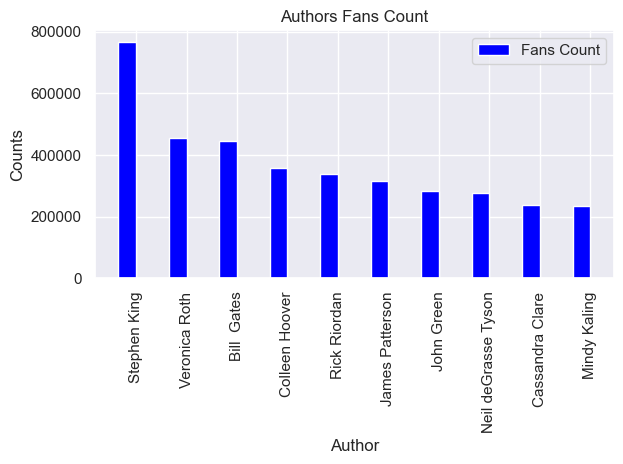

In [11]:
# plotting the top 10 authors with the most fans count and books count

# X-axis
authors = top_10_authors['name']
# Y-axis
fans_count = top_10_authors['fans_count']

bar_width = 0.35
x = np.arange(len(authors))
plt.bar(x, fans_count, width=bar_width, label='Fans Count', color = 'blue')
plt.xlabel('Author')
plt.ylabel('Counts')
plt.title('Authors Fans Count')
plt.xticks(x + bar_width / 2, authors, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

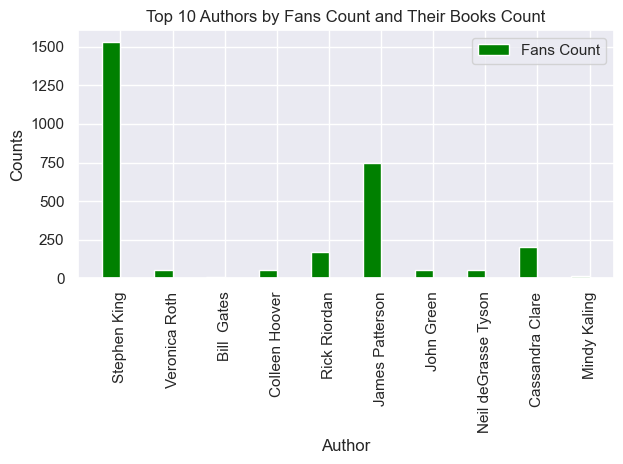

In [12]:
# plotting the top 10 authors with the most fans count and books count

# X-axis
authors = top_10_authors['name']
# Y-axis
books_count = top_10_authors['books_count']


bar_width = 0.35
x = np.arange(len(authors))
plt.bar(x, books_count, width=bar_width, label='Fans Count', color = 'green')
plt.xlabel('Author')
plt.ylabel('Counts')
plt.title('Top 10 Authors by Fans Count and Their Books Count')
plt.xticks(x + bar_width / 2, authors, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


The author with the most fans count is **Stephen King**

### 2)  Extracting the longest series name among these authors.

In [28]:
# extracting the IDs of the top 10 authors
top_10_authors_IDs = top_10_authors['id']

chunks = pd.read_json('lighter_books.json', lines=True, chunksize=10000)

# A list of all the series written by the top 10 authors
series_list = []

for chunk in chunks:
    chunk = pd.DataFrame(chunk)
    series_list.append(chunk.loc[chunk['author_id'].isin(top_10_authors_IDs), 'series_name'].tolist())

In [29]:
series_list

[['The Dark Tower',
  'The Dark Tower',
  'The Dark Tower',
  'The Dark Tower',
  'The Dark Tower',
  'The Dark Tower',
  'The Dark Tower',
  'The Dark Tower',
  'The Dark Tower',
  '',
  '',
  '',
  'The Stand (split volumes)',
  '',
  'The Stand (split volumes)',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'Alex Cross',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'Skeleton Crew',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'The Talisman',
  '',
  'The Green Mile',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'The Talisman',
  '',
  '',
  '',
  'The Dark Tower',
  '',
  '',
  '',
  'The Secretary of Dreams',
  'The Green Mile',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'The Shining',
  '',
  '',
  '',
  'The Dark Tower',
  '',
  '',
  'Skeleton Crew',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'Different Seasons

In [14]:
series_list1 = [x for sublist in series_list for x in sublist]
# Removing the repeated elements
series_list1 = set(series_list1)
# Finding the element with the maximum length
longest_title_series = max(series_list1, key=len)

print('The series with the longest title among the top 10 authors with the most fan count is "', longest_title_series,'"')

The series with the longest title among the top 10 authors with the most fan count is " Percy Jackson and the Olympians: The Graphic Novels "


The series with the longest title among the top 10 authors with the most fan count is " Percy Jackson and the Olympians: The Graphic Novels "

### 3) Identifying the authors that have been published in different formats.

In [15]:
chunks = pd.read_json('lighter_books.json', lines=True, chunksize=10000)

# Dictionary that includes the author ID as a key and the count of his different publishing formats as value 
author_format_counts_dict = dict()

# Dictionary that includes the publishing format as a key and the number of instances of that format as value
format_counts = dict()

for chunk in chunks:
    chunk = pd.DataFrame(chunk)
    temp_dict =  chunk.groupby('author_id')['format'].nunique().to_dict()
    temp2_dict = chunk['format'].value_counts().to_dict()

    for key, value in temp_dict.items():

        if key in author_format_counts_dict:
            author_format_counts_dict[key] += value

        else:
            author_format_counts_dict[key] = value

    for key, value in temp2_dict.items():

        if key in format_counts:
            format_counts[key] += value

        else:
            format_counts[key] = value

# Excluding the authors who has only 1 publishing format
author_format_counts_dict_filtered = {key: value for key, value in author_format_counts_dict.items() if value >= 2}
print('The number of authors published in different format is', len(author_format_counts_dict_filtered), 'out of', len(df_authors), 'authors')


The number of authors published in different format is 220631 out of 351767 authors


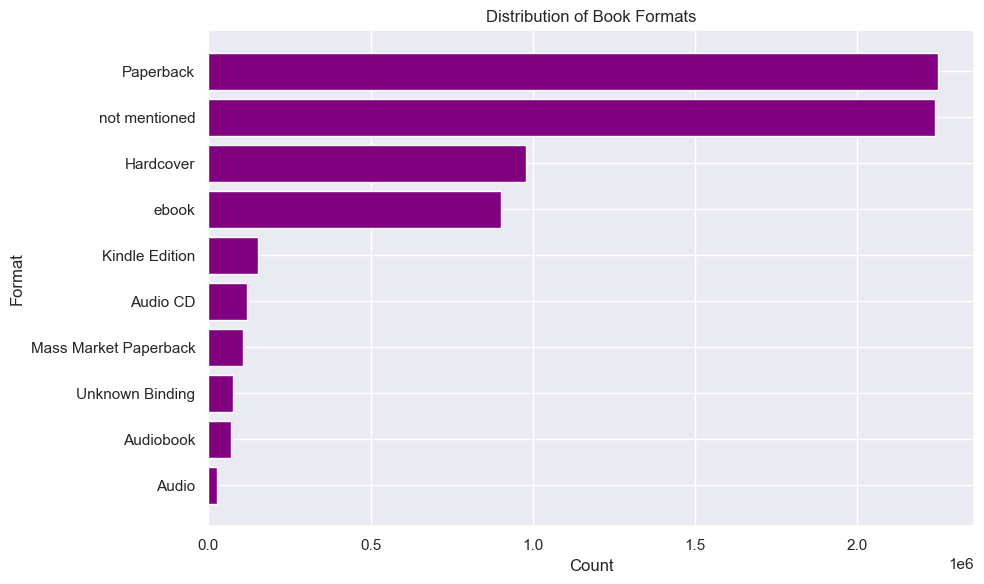

In [16]:
# Extractiong the top 10 formats based on their count
top_10_format_counts = sorted(format_counts.items(),  key=lambda x: x[1], reverse=True)[:10]

# X-axis
formats = [x[0] for x in top_10_format_counts]
# Y-axis
counts = [x[1] for x in top_10_format_counts]

# Replacing ' ' with 'not mentioned' for better understanding
formats[1] = 'not mentioned'

plt.figure(figsize=(10, 6))
plt.barh(formats, counts, color='purple')
plt.xlabel('Count')
plt.ylabel('Format')
plt.title('Distribution of Book Formats')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest count at the top
plt.tight_layout()
plt.show()


- The number of authors published in different format is 220631 out of 351767 authors.

- The number of formats in the dataset is 3693 which is too large and suitable for a histogram plot. 

- I chose to plot the top 10 formats based on their counts. I changed the formmat (' ') to not mentioned to be more readable.

- The Paperback format is the most common format in the dataset then comes Hardcover and ebook respectively.


### 4) Providing information about the general response from readers and identifying structural bias based on the author gender.

In [17]:
authors_updated = df_authors.copy()

# Adding a column called Popularity_index to the author's dataframe
authors_updated['Popularity index'] = (0.2 * authors_updated['fans_count'])+(0.7 * authors_updated['average_rating']) + (0.1 * authors_updated['text_reviews_count'])

# Normalizing the popularity index using the min max method to a [0-100] scale
authors_updated['Popularity index'] = (authors_updated['Popularity index'] - min(authors_updated['Popularity index'])) / (max(authors_updated['Popularity index']) - min(authors_updated['Popularity index']))*100

authors_updated.head()

ratings_count  average_rating  text_reviews_count  \
0        2862064            4.19               62681   
1        1417316            4.02               84176   
2          56159            4.53                 352   
3           3302            3.79                 480   
4           7979            3.60                 772   

                                            work_ids  \
0  [3078186, 135328, 1877624, 74123, 3078120, 104...   
1  [613469, 2305997, 940892, 2611786, 7800569, 31...   
2  [17150, 808427, 20487307, 90550, 25460625, 171...   
3  [4417, 14300808, 14780, 3796968, 44703121, 103...   
4  [13330815, 19109351, 42306244, 72694240, 26291...   

                                            book_ids  works_count  id  \
0  [386162, 13, 8695, 8694, 6091075, 365, 569429,...          106   4   
1  [9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...           75   7   
2  [349254, 15222, 14833682, 15221, 18126815, 152...           14  10   
3  [40, 9416484, 12482, 3753106, 26889789, 104764...           45  12   
4  [8466327, 15739968, 22756778, 51026133, 260451...           61  14   

                      name  gender  \
0            Douglas Adams    male   
1              Bill Bryson    male   
2              Jude Fisher  female   
3  James Hamilton-Paterson    male   
4              Mark Watson    male   

                                           image_url  \
0  https://images.gr-assets.com/authors/159137433...   
1  https://images.gr-assets.com/authors/157859752...   
2  https://images.gr-assets.com/authors/141145711...   
3  https://images.gr-assets.com/authors/127051738...   
4  https://images.gr-assets.com/authors/133175379...   

                                               about  fans_count  \
0  Douglas Noël Adams was an English author, comi...       19826   
1  William McGuire "Bill" Bryson, OBE, FRS was bo...       16144   
2  Jude Fisher is the pseudonym for <a href="http...          60   
3  James Hamilton-Paterson's work has been transl...          72   
4  Mark Andrew Watson (born 13 February 1980) is ...         179   

   Popularity index  
0          4.789469  
1          5.449356  
2          0.032491  
3          0.039348  
4          0.062917

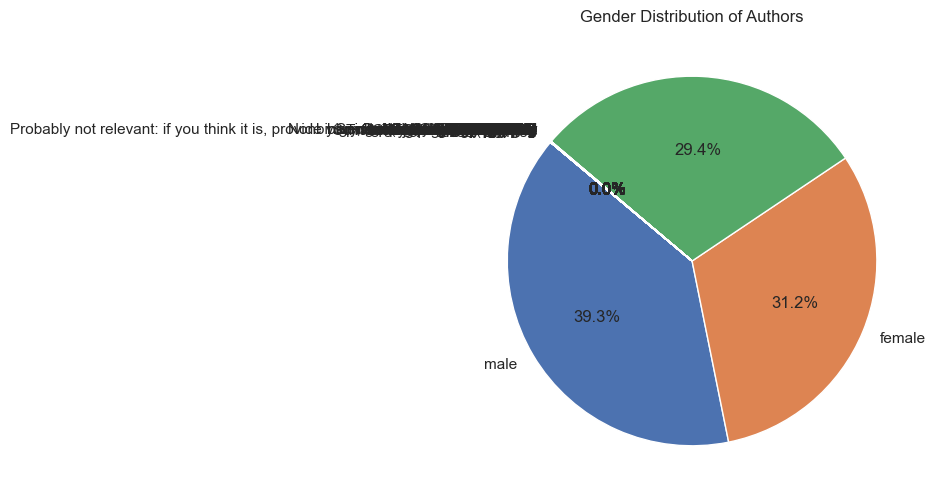

In [18]:
# Count the occurrences of each gender
gender_counts = df_authors['gender'].value_counts()

plt.figure(figsize=(6, 6))  
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution of Authors')

# Display the pie chart
plt.show()

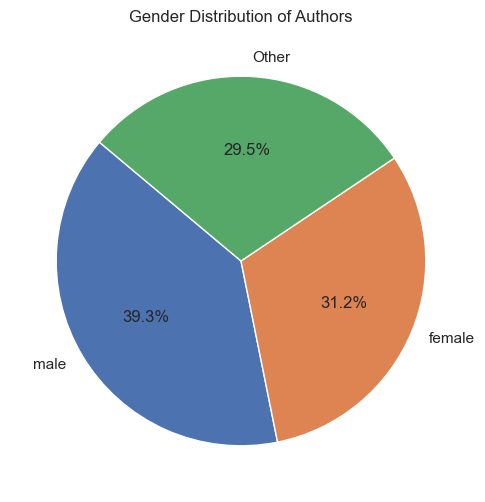

In [19]:
# Encoding the genders other than 'Male' and 'Female' to 'Other' so the Pie chart provides better insights
authors_gender_updated = df_authors.copy()
# Drop rows with null values in the 'Age' column
authors_gender_updated.dropna(subset=['gender'], inplace=True)
authors_gender_updated['gender'] = authors_gender_updated['gender'].apply(lambda x: 'Other' if x not in ['male', 'female'] else x)


# Count the occurrences of each gender
gender_counts = authors_gender_updated['gender'].value_counts()

plt.figure(figsize=(6, 6))  
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution of Authors')

# Display the pie chart
plt.show()


In [20]:
# Dropping rows in case nulls were found on the columns 'fans_count' and 'average_rating'
authors_gender_updated = authors_gender_updated.dropna(subset=['fans_count', 'average_rating']) 

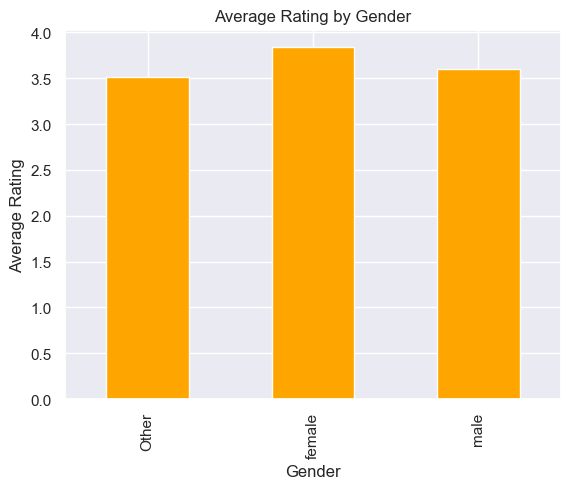

In [21]:
gender_avg_rating = authors_gender_updated.groupby('gender')['average_rating'].mean()

gender_avg_rating.plot(kind='bar', color='orange')

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Average Rating')
plt.title('Average Rating by Gender')

# Show the plot
plt.show()

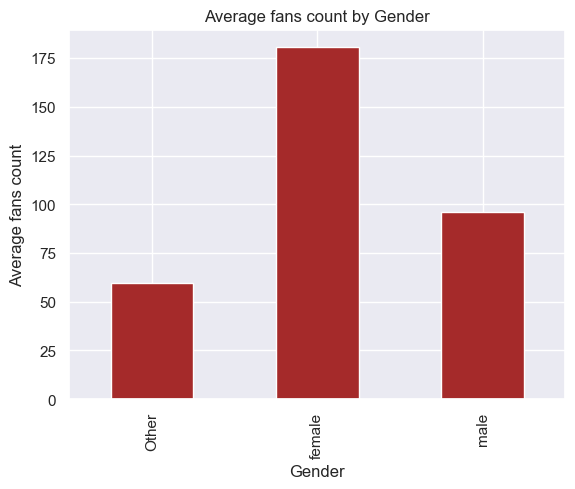

In [22]:
gender_avg_rating = authors_gender_updated.groupby('gender')['fans_count'].mean()

gender_avg_rating.plot(kind='bar', color='brown')

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Average fans count')
plt.title('Average fans count by Gender')

# Show the plot
plt.show()

- For more information about the response from the readers, a new metric called popularity index was created. 

- The metric is calculated by the following eqauation:
$$
\text{Popularity Index} = 0.2 \times \text{Fans Count} + 0.5 \times \text{Average Rating} + 0.1 \times \text{Text Reviews Count}
$$

- The metric is nomralized using the min-max method and scaled to 100. This metric is an indicator of how popular the author among the readers.

- After dividing the authors by gender there were 150 different genders.

- Genders that are not "Male" or "Female"  were labeled to "other" for better visualization and easier analysis.

- The Pie chart shows that the authors are 39.3 % Males, 31.2 % Females, and 29.5 % Other which implies that there is no structural bias 

  as the precentages can be considered close.

- The Males, Females, and Other almost have the same average rating with Females are slightly higher.

- Regarding the fans count, the Females have significantly higher fans count compared to Males and Other genders.

---

## #RQ6 -  Top 10 authors concerning the number of fans

### 1) Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

In [2]:
trunk_columns = ['title','author_name', 'author_id', 'work_id','language', 'average_rating', 'ratings_count', 'text_reviews_count', 'publication_date', 'original_publication_date', 'num_pages', 'series_id']
data_1= pd.DataFrame(columns=trunk_columns)

for chunk in pd.read_json('lighter_books.json', lines=True, chunksize=10000):
    chunk= chunk[trunk_columns]
    data_1 = pd.concat([data_1,chunk], ignore_index=True)

data_1.to_json('books_s.json', orient='records',lines=True)

In [3]:
datef = pd.read_json('lighter_authors.json',lines=True)
datef = datef.sort_values(by='fans_count', ascending=False)
top10 = datef['id'].iloc[:10].tolist()
df2 = pd.read_json('books_s.json',lines=True)
filtered_df = df2[df2['author_id'].isin(top10)]

b_series = pd.DataFrame(columns=filtered_df.columns)
b_single = pd.DataFrame(columns=filtered_df.columns)

non_series_rows = []
series_rows = []

for index, row in filtered_df.iterrows():
    if pd.isna(row['series_id']) or row['series_id'] == '':
        non_series_rows.append(row)
    else:
        series_rows.append(row)
b_single = pd.concat([b_single, pd.DataFrame(non_series_rows)])
b_series = pd.concat([b_series, pd.DataFrame(series_rows)])

In [4]:
b_single['Publication_year'] = b_single['original_publication_date'].apply(year_date)
b_single = b_single.sort_values(by='Publication_year', ascending=True)

In [5]:
b_series['Publication_year'] = b_series['original_publication_date'].apply(year_date)
b_series = b_series.sort_values(by='Publication_year', ascending=True)

In [6]:
b_single = b_single.sort_values(by='Publication_year')
b_single = b_single.reset_index(drop=True)

In [7]:
b_series = b_series.sort_values(by=['Publication_year','series_id'])
b_series = b_series.reset_index(drop=True)

In [8]:
f_ser = b_series.drop_duplicates(subset='work_id')
f_non = b_single.drop_duplicates(subset='work_id')

In [9]:
multip = f_non.groupby('author_name')
for series, series_books in multip:
   avg_time_diffs = []
   series_books = series_books.sort_values('Publication_year')

   # Convert the 'Publication_year' column to numeric
   series_books['Publication_year'] = pd.to_numeric(series_books['Publication_year'])

   # Calculate the time difference between each book's publication year within a series
   time_diff = series_books['Publication_year'].diff()

   # Calculate the average time difference for the series and append to the list
   avg_time_diff = time_diff.mean()
   avg_time_diffs.append((series, avg_time_diff))

   for series, avg_time_diff in avg_time_diffs:
       print(f"Author: {series}")
       print(f"Average Time Difference: {avg_time_diff}")
   print("\n")

Author: Bill  Gates
Average Time Difference: 4.0


Author: Cassandra Clare
Average Time Difference: 0.7777777777777778


Author: Colleen Hoover
Average Time Difference: 0.4


Author: James Patterson
Average Time Difference: 0.319672131147541


Author: John Green
Average Time Difference: 1.0909090909090908


Author: Mindy Kaling
Average Time Difference: 5.5


Author: Neil deGrasse Tyson
Average Time Difference: 2.5714285714285716


Author: Rick Riordan
Average Time Difference: 1.8333333333333333


Author: Stephen King
Average Time Difference: 0.20136518771331058


Author: Veronica Roth
Average Time Difference: 1.0




In [10]:
f_ser = f_ser.sort_values(by=['author_id','series_id'])
f_ser = f_ser.reset_index(drop=True)

In [11]:
f_ser['Publication_year'].replace(['', ' '], pd.NA, inplace=True)
f_ser.dropna(subset=['Publication_year'], inplace=True)
f_ser.reset_index(drop=True, inplace=True)

In [12]:
multip = f_ser.groupby('author_name')

for author, books in multip:
   print(f"Author: {author}")
   series_grouped = books.groupby('series_id')

   # Initialize a list to store average time differences for each series
   avg_time_diffs = []

   for series, series_books in series_grouped:
       series_books = series_books.sort_values('Publication_year')

       # Convert the 'Publication_year' column to numeric
       series_books['Publication_year'] = pd.to_numeric(series_books['Publication_year'])

       # Calculate the time difference between each book's publication year within a series
       time_diff = series_books['Publication_year'].diff()

       # Calculate the average time difference for the series and append to the list
       avg_time_diff = time_diff.mean()
       avg_time_diffs.append((series, avg_time_diff))

   for series, avg_time_diff in avg_time_diffs:
       print(f"Series: {series}, Average Time Difference: {avg_time_diff}")
   print("\n")

Author: Cassandra Clare
Series: 104049, Average Time Difference: 1.0
Series: 104133, Average Time Difference: 1.0
Series: 129925, Average Time Difference: 0.0
Series: 134303, Average Time Difference: nan
Series: 188826, Average Time Difference: 0.625
Series: 242806, Average Time Difference: 0.0
Series: 44457, Average Time Difference: 0.7
Series: 54144, Average Time Difference: 0.75
Series: 61437, Average Time Difference: nan
Series: 70693, Average Time Difference: 0.6666666666666666
Series: 76298, Average Time Difference: 2.0
Series: 92965, Average Time Difference: 0.09090909090909091


Author: Colleen Hoover
Series: 141294, Average Time Difference: 0.5
Series: 144357, Average Time Difference: 0.5
Series: 79569, Average Time Difference: 0.5
Series: 97061, Average Time Difference: 2.3333333333333335


Author: James Patterson
Series: 112695, Average Time Difference: 1.5
Series: 112891, Average Time Difference: 1.0
Series: 113257, Average Time Difference: 0.75
Series: 132156, Average Time

Regarding the average time gap between two subsequent publications for a series of books, I would have expected a longer period. Averaging at about two books per year, is not very resonable or realistic. We get this result because of the broad data set, with a large mix of authors publishing over different categories.

### 2) For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

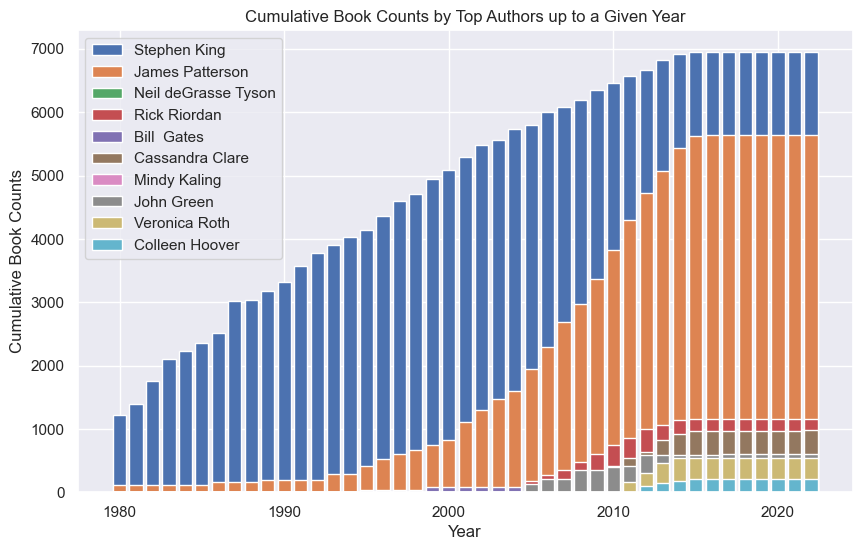

In [17]:
years = range(1980, 2023)

# Create a DataFrame to store cumulative book counts
cumulative_counts_df = pd.DataFrame(index=years)

# Filter out empty and missing publication dates
filtered_df2 = filtered_df[filtered_df['original_publication_date'].str.strip() != '']
filtered_df2 = filtered_df2.dropna(subset=['original_publication_date'])

# Convert 'original_publication_date' to a 4-digit year
filtered_df2['original_publication_date'] = pd.to_datetime(filtered_df2['original_publication_date'], errors='coerce').dt.strftime('%Y')
filtered_df2['original_publication_date'] = filtered_df2['original_publication_date'].astype(float)

# Calculate cumulative book counts for each author
for author_id, author_df in filtered_df2.groupby('author_id'):
    auth_cum_count = []

    for year in years:
        count = len(author_df[author_df['original_publication_date'] <= year])
        auth_cum_count.append(count)

    author_name = filtered_df2[filtered_df2["author_id"] == author_id]["author_name"].iloc[0]
    cumulative_counts_df[author_name] = auth_cum_count

# Create a bar graph
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
for column in cumulative_counts_df.columns:
    plt.bar(cumulative_counts_df.index, cumulative_counts_df[column], label=str(column))

plt.title('Cumulative Book Counts by Top Authors up to a Given Year')
plt.xlabel('Year')
plt.ylabel('Cumulative Book Counts')
plt.legend()
plt.show()

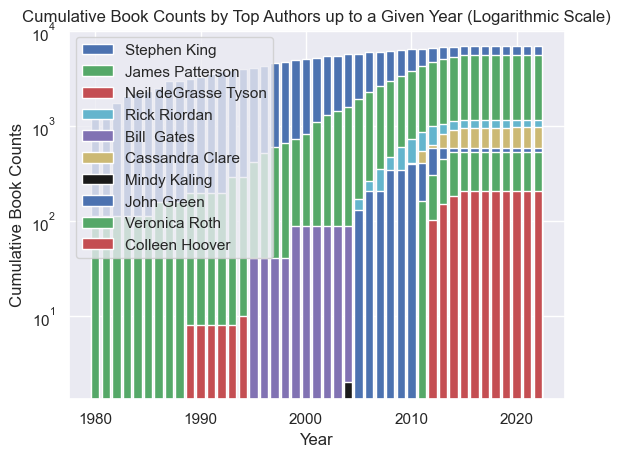

In [18]:
years = range(1980, 2023)
# Create a DataFrame to store cumulative book counts
cumulative_counts_df = pd.DataFrame(index=years)

# Filter out empty and missing publication dates
filtered_df2 = filtered_df[filtered_df['original_publication_date'].str.strip() != '']
filtered_df2 = filtered_df2.dropna(subset=['original_publication_date'])

# Convert 'original_publication_date' to a 4-digit year
filtered_df2['original_publication_date'] = pd.to_datetime(filtered_df2['original_publication_date'], errors='coerce').dt.strftime('%Y')
filtered_df2['original_publication_date'] = filtered_df2['original_publication_date'].astype(float)

# Use the original colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Calculate cumulative book counts for each author
for i, (author_id, author_df) in enumerate(filtered_df2.groupby('author_id')):
    auth_cum_count = []

    for year in years:
        count = len(author_df[author_df['original_publication_date'] <= year])
        auth_cum_count.append(count)

    author_name = filtered_df2[filtered_df2["author_id"] == author_id]["author_name"].iloc[0]
    cumulative_counts_df[author_name] = auth_cum_count

    # Plot the data using original colors
    plt.bar(cumulative_counts_df.index, cumulative_counts_df[author_name], label=str(author_name), color=colors[i % len(colors)])

sns.set(style="darkgrid")
plt.yscale('log')  # Use a logarithmic scale on the y-axis
plt.title('Cumulative Book Counts by Top Authors up to a Given Year (Logarithmic Scale)')
plt.xlabel('Year')
plt.ylabel('Cumulative Book Counts')
plt.legend()
plt.show()

The second graph is a closer view of the lower publishing authors.

The two graphs show that Stephen King has been publishing the longest out of the top 10 must prolific authors. Looking at the last part of the graph, we can see that James Patterson is the following publishing author and, by the end of the period, the two have a far larger amount of published books. James Patterson, Rick Riordan, Cassandra Clare and John Green can be considered to be contemporary with eachother because their publishing periods coincide as seen from the upward graph lines. Moreover, their stopping years look to be also similar. A range of years where the production rate was higher can be seen aproximately between 2005 and 2014.

---

## #RQ7 - Estimating probabilities

### 1) **Estimate the probability that a book has over 30% of the ratings above 4.**


In [3]:
Flag = True
if Flag:
    # extraction of the num_pages variable
    books_rating_dist = pd.DataFrame()
    rating_dist = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['rating_dist']]
        rating_dist.append(processed_chunk)

    books_rating_dist = pd.concat(rating_dist, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_rating_dist.to_json('books_rating_dist.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_rating_dist=pd.read_json('books_rating_dist.json',lines=True)

To calculate the probability that a book has at least $30\%$ of the ratings equal to or greater than $4$ we must take advantage of the definition of probability of an event which is equal to the ratio of favorable cases to total cases. 

In this case, the favourable cases are the number of books complying with this condition while the total cases are the total number of books, corresponding to the number of rows of the dataset. 

To extract the favorable cases we must analyze the distribution of the reviews for each book/row contained within the variable `rating_dist` and from it verify that the proportion of votes for that book equal to or greater than $4$ is greater than $0.3$. If this condition is verified then the book in question will be counted as a favorable case.

In [4]:
casi_favorevoli=0

for row in books_rating_dist.values:
    row= [i for i in row]
    row=row[0]
    #print(row)
    elements = row.split('|')
    #print(elements)
    ratings = {}

    for element in elements:
        key, value = element.split(':')
        ratings[key] = int(value)
    #print(ratings)
    if ratings['total'] ==0:
        continue
    if ((ratings['4']+ratings['5'])/ratings['total'])>0.3:
        casi_favorevoli +=1

print(f'"The probability that a book has over 30% of the ratings above 4 is: {round(casi_favorevoli/len(books_rating_dist),2)}')

"The probability that a book has over 30% of the ratings above 4 is: 0.81


### 2) Estimate the probability that an author publishes a new book within two years from its last work.

In [10]:
Flag = True
if Flag:
    # extraction of the original_publication_date variable
    books_publication = pd.DataFrame()
    publication = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['original_publication_date', 'author_id', 'work_id']]

        # cleaning condition
        processed_chunk['original_publication_date'] = pd.to_numeric(processed_chunk['original_publication_date'], errors='coerce')
        processed_chunk = processed_chunk[(processed_chunk['original_publication_date']>0) & (processed_chunk['original_publication_date']<2023)  ]
        processed_chunk.dropna(subset=['original_publication_date', 'author_id'])
        processed_chunk.drop_duplicates(subset='work_id',keep='first',inplace=True)
        
        #
        publication.append(processed_chunk)

    books_publication = pd.concat(publication, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books_publication.to_json('rq7_2.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books_publication=pd.read_json('rq7_2.json',lines=True)

Again, to calculate the probability that a book has an author published a new book whithin two years from its last work we must take advantage of the definition of probability of an event which is equal to the ratio of favorable cases to total cases. 

First, we need to take the dataset of the books and groupify them by each author that will be uniquely identified by the `author_id` variable. Secondly, we must order the publication dates of each author’s books in ascending order to facilitate comparison. Given the presence of both the variable `original_publication_date` and the variable `publication_date` we have chosen to consider as comparison parameter only the first of the two considering significant only the first publication of the work since the actual date of publication of a book in this dataset could be later than the original date in case it was a reprint of the book in question.

In [7]:
# firs we need to grupify the dataset for each author_id
books_publication_grouped = books_publication.groupby('author_id').agg(list)

# extract the number of total cases
casi_totali= len(books_publication_grouped) 

# now we sort the publication date variable already grupified by author
books_publication_grouped = books_publication_grouped.sort_values(by='original_publication_date')

# example of the grouped and ordered dataset
books_publication_grouped.head(10)

original_publication_date                         work_id
author_id                                                          
7338255                       [1.0]                      [44547968]
7097488                       [1.0]                      [41027828]
4721654                       [1.0]                      [24948778]
16982953                      [1.0]                      [42707690]
6520230                       [1.0]                      [42674692]
4491745                  [1.0, 1.0]            [14712022, 14712022]
6939496                  [1.0, 1.0]            [25331317, 25331317]
15648676                 [1.0, 1.0]                [436907, 436907]
7657363             [1.0, 1.0, 1.0]  [40754330, 40754330, 40754330]
335217        [1.0, 1997.0, 2007.0]    [6970411, 6970413, 17527479]

In order to speed up the verification of the publication dates of the works, all authors who have not published at least two books have been eliminated from the count, since automatically it cannot be a possible favorable case. 

After checking the publication dates we got a Boolean varibaile containing as many *True* or *False* for each author as the number of pairs of books compared. 

In [9]:
# drop the authors that have less than 2 books which automaticly can be excluded from the number of favorable cases
books_publication_grouped = books_publication_grouped[ (books_publication_grouped['original_publication_date'].str.len() > 1 )]

# now we calculated for each author if he has published a new book within two years from its last work
casi_favorevoli = books_publication_grouped.original_publication_date.apply(lambda row: [ ( (row[i] - row[i+1]) <= 2 ) for i in range(len(row)-1) ]) 

# example of the boolean variable
casi_favorevoli.head(5)

author_id
4491745           [True]
6939496           [True]
15648676          [True]
7657363     [True, True]
335217      [True, True]
Name: original_publication_date, dtype: object

Finally, to get the number of favorable cases, all *True* were summed up paying attention not to count more than one *True* per line since if an author has published more than one pair of books whithin two years from the previous this does not increase the number of favorable cases since they are the number of authors who check this condition and not the number of book pairs that check it.

In the end, to get the probability of the event we make the ratio between favorable cases and total cases.

In [8]:
# lastly we count the number of favorable cases considering each author only one time
count = [1 for x in casi_favorevoli if sum(x) > 1]

print(f'The probabbility that an author has published a new book within two years from its last work is: {sum(count) / casi_totali}')

The probabbility that an author has published a new book within two years from its last work is: 0.6073978708672322


### 3) In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.

In [104]:
Flag = True
if Flag:
    # extraction of the 'id' and 'num_pages' variable
    books = pd.DataFrame()
    id_pages = []
    for chunks in tqdm(pd.read_json('lighter_books.json',lines=True, chunksize=10000)):
        processed_chunk = chunks[['id', 'num_pages']]
        
        # cleaning condition
        processed_chunk['num_pages'] = pd.to_numeric(processed_chunk['num_pages'], errors='coerce')
        processed_chunk['id'] = pd.to_numeric(processed_chunk['id'], errors='coerce')
        processed_chunk = processed_chunk[ (processed_chunk['num_pages']  > 0)]
        processed_chunk.dropna(subset=['id', 'num_pages'])
        processed_chunk.drop_duplicates(subset='id',keep='first',inplace=True)
        
        #
        id_pages.append(processed_chunk)

    books = pd.concat(id_pages, ignore_index=True)

    # now i save the extracted variable in a new JSON file so in the future if i need it it's faster import it instead extract it again
    books.to_json('rq7_3.json',orient = 'records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books=pd.read_json('rq7_3.json',lines=True)

# import of the list DataFrame
df_list = pd.read_json('list.json',lines=True)

# example of the list Dataset
df_list.head(5)

id                                 title  \
0   2           The Worst Books of All Time   
1   3  Best Science Fiction & Fantasy Books   
2   4                    Best Books of 2008   
3   5       Best Books of the Decade: 2000s   
4   6        Best Books of the 20th Century   

                                         description  \
0  What do you think are the worst books ever wri...   
1  Anything in the science fiction or fantasy gen...   
2  The best books first published during 2008.See...   
3  The best books published during the 2000s deca...   
4  The best books published during the 20th centu...   

                                    description_html  num_pages  num_books  \
0  \n      What do you think are the worst books ...         74       7395   
1  \n      Anything in the science fiction or fan...         71       7023   
2  \n      The best books first published during ...         17       1678   
3  \n      The best books published during the 20...         70       6919   
4  \n      The best books published during the 20...         76       7600   

   num_voters    created_date  \
0       18260  May 20th, 2008   
1       21747  May 29th, 2008   
2        6939  May 29th, 2008   
3       28249  May 29th, 2008   
4       49437  May 29th, 2008   

                                                tags  num_likes  \
0  [abominable, abomination, awful, bad, disgusti...        175   
1  [best-fantasy, best-science-fiction, earliest-...       2989   
2  [2008, best, by-year, earliest-list, fiction, ...         59   
3  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...       1192   
4  [20th, 20th-century, best, by-century, by-year...       6083   

                                created_by  num_comments  \
0  {'name': 'Michael Economy', 'id': '73'}          2570   
1       {'name': 'deleted user', 'id': ''}           307   
2       {'name': 'deleted user', 'id': ''}           181   
3       {'name': 'deleted user', 'id': ''}           163   
4       {'name': 'deleted user', 'id': ''}           510   

                                               books  
0  [{'book_id': '41865', 'title': 'Twilight', 'au...  
1  [{'book_id': '375802', 'title': 'Ender's Game'...  
2  [{'book_id': '2767052', 'title': 'The Hunger G...  
3  [{'book_id': '136251', 'title': 'Harry Potter ...  
4  [{'book_id': '2657', 'title': 'To Kill a Mocki...

The list containing the worst books of all time in the opinion of voters is contained in the variable `books` in the first line of the dataset `list.json` so, first we have to extract this list where each book is saved in a *dictionary-type* format contained into a *list* with all the books-dictionary in order to convert this list into a *pandas-dataframe*, making sure that the `book_id` variable is in numeric format.

In [105]:
# format in which each ranked book is saved in the list
df_list.loc[0,'books'][0]

{'book_id': '41865',
 'title': 'Twilight',
 'author_id': '941441',
 'author': 'Stephenie Meyer',
 'position': {'ranking': 1, 'score': 527144, 'votes': 5303}}

In [106]:
# first we need to extract the list of wors book of all time which is the last colum of the first row and we convert it into a DataFrame
worst_books_list = pd.DataFrame(df_list.loc[0, 'books'])
worst_books_list['book_id'] = pd.to_numeric(worst_books_list['book_id'], errors='coerce')

# example of the Worst book dataset
worst_books_list.head(5)

book_id                 title author_id           author  \
0     41865              Twilight    941441  Stephenie Meyer   
1   1162543         Breaking Dawn    941441  Stephenie Meyer   
2     49041              New Moon    941441  Stephenie Meyer   
3    428263               Eclipse    941441  Stephenie Meyer   
4  10818853  Fifty Shades of Grey   4725841       E.L. James   

                                         position  
0  {'ranking': 1, 'score': 527144, 'votes': 5303}  
1  {'ranking': 2, 'score': 400813, 'votes': 4061}  
2  {'ranking': 3, 'score': 356742, 'votes': 3648}  
3  {'ranking': 4, 'score': 323657, 'votes': 3338}  
4  {'ranking': 5, 'score': 231106, 'votes': 2356}

Then, in order to have for each book in the ranking the number of pages of the book we must perform a *join* between this dataset and the one containing the complete list of books in which there is also the variable `num_pages` that interest us. The join between the two lists must be an *inner-join* because we are only interested in both dataset and will be made through the association 1 to 1 of the `id` variables present in `books` and `books_id` present in `worst_books`.

In [107]:
# second we need to merge the worst book list with the books DataFrame
# to obtain this result we perform a inner join on the variable 'books_id' which is unique for all rows and is inside both dataset
merged_df = pd.merge(books, worst_books_list, left_on='id', right_on='book_id', how='inner')

# example of the merged dataset
merged_df.head(5)

id  num_pages  book_id                                      title  \
0   2        870        2  Harry Potter and the Order of the Phoenix   
1   3        309        3      Harry Potter and the Sorcerer's Stone   
2   5        435        5   Harry Potter and the Prisoner of Azkaban   
3   6        734        6        Harry Potter and the Goblet of Fire   
4  10       3342       10                    Harry Potter Collection   

  author_id        author                                      position  
0   1077326  J.K. Rowling  {'ranking': 490, 'score': 1127, 'votes': 14}  
1   1077326  J.K. Rowling  {'ranking': 303, 'score': 2275, 'votes': 26}  
2   1077326  J.K. Rowling  {'ranking': 492, 'score': 1120, 'votes': 14}  
3   1077326  J.K. Rowling  {'ranking': 240, 'score': 3166, 'votes': 38}  
4   1077326  J.K. Rowling   {'ranking': 1480, 'score': 198, 'votes': 3}

Now we can calculate the number of favorable cases of the event as the number of books in the worst books of all time ranking having more than 700 pages while the total number of books having more than 700 pages in the datset books corresponds to the number of total cases. 

In [108]:
# now we calculated the favorable cases as the number of the worst book with more than 700 pages
casi_favorevoli = len(merged_df[merged_df['num_pages']>700])

# the total cases are the number of books with 700 pages
casi_totali = len(books[books['num_pages']>700])

p_xy = casi_favorevoli/casi_totali

print(f'The probability that a book with more than 700 pages is included in the worst book list is: {round(p_xy,3)}')

The probability that a book with more than 700 pages is included in the worst book list is: 0.002


### 4) Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

To verify in the two events $X$ and $Y$ are indipendent we could use the definition of indipendency between two events: 
$$X\perp Y \qquad \iff  \qquad P(X\cap Y)= P(X) \cdot P(Y) $$

But, from the previous request we have already calculate the probability of the conditional event $P(X|Y)$ so, using the definition $P(X|Y)=\frac{P(X\cap Y)}{P(Y)}$ we can rewrite the indipendency condition as: 

$$X\perp Y \qquad \iff \qquad P(X|Y)\cdot P(Y)=P(X\cap Y)= P(X) \cdot P(Y) \qquad \iff \qquad P(X|Y)=P(X)$$

In [111]:
# we calculate P[X]
p_x = len(worst_books_list)/len(books)

print(f'The probability of P(X|Y) is: {round(p_xy,3)}')
print(f'The probability of P(X) is: {round(p_x,3)}')


The probability of P(X|Y) is: 0.002
The probability of P(X) is: 0.002


Alternatively, if we can verify independence using the definition itself:

In [112]:
# P[Y]
p_y = len(books[books['num_pages']>700])/len(books)

print(f'The probability P(X,Y) is: {round(p_xy*p_y,3)}')
print(f'The probability P(X)*P(Y) is: {round(p_x*p_y,3)}')

The probability P(X,Y) is: 0.0
The probability P(X)*P(Y) is: 0.0


--- 

## #RQ8 - Charts, statistical tests, and analysis methods for the check of hypothesis

In [32]:
Flag= True

if Flag:
    # Intialize a new DataFrame for the reduced dataset
    books = pd.DataFrame()

    # Read the JSON file in chunks
    chunk_size = 10000  
    chunks = []

    for chunk in tqdm(pd.read_json('lighter_books.json', lines = True, chunksize = chunk_size)):
        processed_chunk = chunk[ ['language', 'num_pages', 'average_rating', 'rating_dist', 'ratings_count', 'text_reviews_count' ] ] # extract the needed columns
        
        #cleaning condition
        processed_chunk = processed_chunk[ (processed_chunk['average_rating'] > 0)]
        processed_chunk['num_pages'] = pd.to_numeric(processed_chunk['num_pages'], errors='coerce')
        processed_chunk = processed_chunk[ (processed_chunk['num_pages']  > 0)]
        processed_chunk = processed_chunk[ (processed_chunk['num_pages']  < 5000)]
        processed_chunk = processed_chunk[(processed_chunk['language'] != "")] 
        processed_chunk = processed_chunk.dropna(subset=['num_pages', 'average_rating'])

        chunks.append(processed_chunk)

    books = pd.concat(chunks, ignore_index=True)

    # save the dataset in a new JSON file
    books.to_json('books_rq8.json', orient='records', lines=True)
else:
    # if the JSON file with the single variable has already been created we can import it simply by reading it from here
    books = pd.read_json('books_rq8.json', lines=True)   

0it [00:00, ?it/s]

### 1) **Can you demonstrate that readers usually rate the longest books as the worst?**

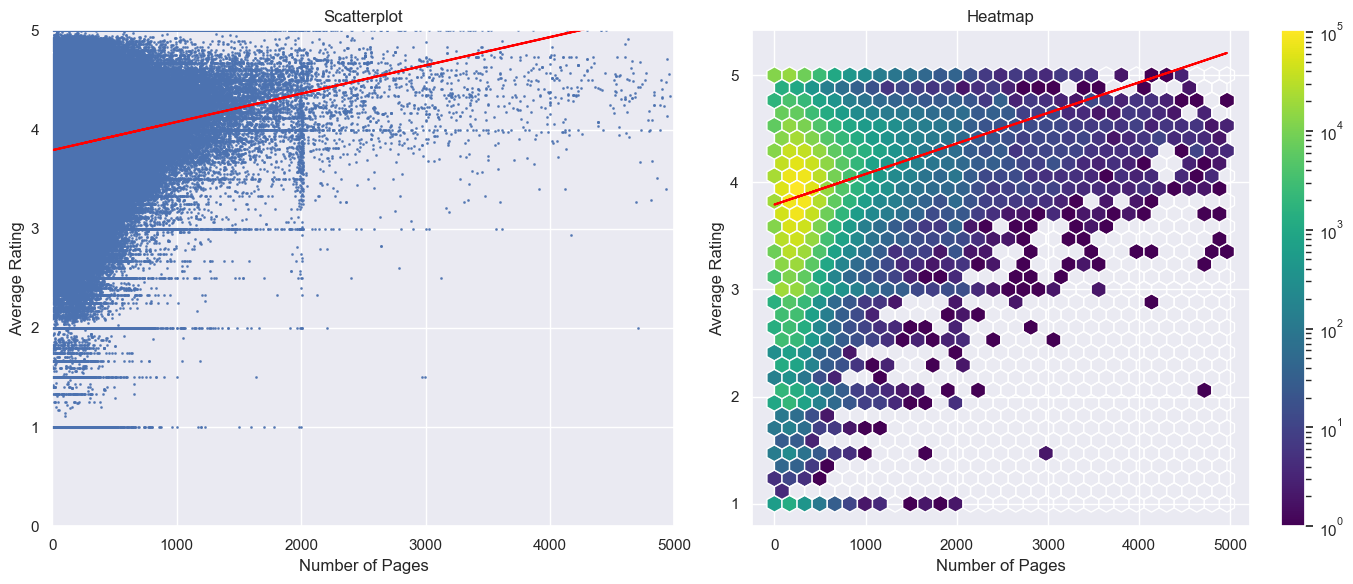

num_pages  average_rating
num_pages        1.000000        0.128227
average_rating   0.128227        1.000000

In [5]:
# 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scatterplot between 'num_pages' e 'average_rating'
sns.set(style="darkgrid")  
ax1.scatter(books['num_pages'], books['average_rating'], alpha=0.8, s=1)
ax1.set_xlabel('Number of Pages') 
ax1.set_ylabel('Average Rating')
ax1.set_xlim(0, 5000)                                           # the xlim is set equal to the condition cleaning of the dataset
ax1.set_ylim(0, 5)
ax1.set_title("Scatterplot")

# automatic linear regression
beta = np.polyfit(books['num_pages'], books['average_rating'], 1)
y_model = np.poly1d(beta)
ax1.plot(books['num_pages'], y_model(books['num_pages']), color='red')

# Heatmap between 'num_pages' e 'average_rating'
hb = ax2.hexbin(books['num_pages'], books['average_rating'], gridsize=30, bins='log', edgecolors='white', cmap='viridis')
ax2.set_xlabel("Number of Pages")
ax2.set_ylabel("Average Rating")
ax2.set_title("Heatmap")

# automatic linear regression
ax2.plot(books['num_pages'], y_model(books['num_pages']), color='red')

# add the colorbar at the heatmap
plt.colorbar(hb, ax=ax2)

plt.tight_layout()
plt.show()

# Calculate the correlation coefficient  
books[['num_pages','average_rating']].corr()  

The correlation coefficient is a statistical measure that indicates the degree of linear relationship between two variables. This coefficient can take values between -1 and 1 and provides information about the direction and intensity of the relationship between variables:

- Positive Value: If the correlation coefficient is positive (close to 1), it means that there is an positive relationship between the two variables. This means that when one variable increases *on average*, the other tends *on average* to increase or when one variable decrease *on average*, the other tends *on average* to decrease.

- Negative Value: If the correlation coefficient is negative (close to -1), it means that there is a negative relationship between the two variables. In other words, when one variable increases *on average*, the other tends to decrease *on average*.

- Zero Value: A correlation coefficient close to zero indicates that there is no significant linear relationship between the two variables. This means that the variables are not strongly influenced by each other in a linear way.

- Value in Modulus: The absolute value of the correlation coefficient represents the intensity of the relationship. The closer the value is to 1 (positive or negative), the stronger the linear relationship. A value close to 0 indicates a very weak or nonexistent relationship.

Since the correlation coefficient between the `number of pages` and the `average rating` of books is slightly positive but close to 0, we can say that there is no correlation between these attributes so, in contrast to what we have been asked, we can say that the number of pages does not linearly affect the average rating. Therefore, it's not correct that readers usually rate the longest books as the worst. 

If we want to forcibly look for a linear relationship between the two attribute we can see how badly it explains the variability of the phenomenon in the scatterplot or in the heatmap and that in case the number of pages would increase only the average evaluation rejecting again the hypothesis in the task.

### 2) **Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?**

In [33]:
books_avg_rating=pd.read_json('books_avg_rating.json',lines=True)
# creation of the dataframes of the conditional distribution 
english = books[( (books['language'] == "eng") | (books['language'] == "en-US") | (books['language'] == "US") | (books['language'] == "en-GB") )] 
no_english = books[( (books['language'] != "eng") & (books['language'] != "en-US") & (books['language'] != "US") & (books['language'] != "en-GB") )] 

In [37]:
average_rating_summary = statistic(books[['average_rating']])
avg_rating_english = statistic(english['average_rating'])
avg_rating_noenglish = statistic(no_english['average_rating'])

# skewness
skewness_books = round(books[['average_rating']].skew()[0],3)
skewness_english = round(no_english[['average_rating']].skew()[0],3)
skewness_noenglish = round(no_english[['average_rating']].skew()[0],3)

# Kurtosis
kurtosis_books = round(stats.kurtosis(books[['average_rating']])[0],3)
kurtosis_english = round(stats.kurtosis(english[['average_rating']])[0],3)
kurtosis_noenglish = round(stats.kurtosis(no_english[['average_rating']])[0],3)

Dist_compare = {'Variable': ['Average Ratings', 'Average Ratings - English books', 'Average Ratings - No English books'],
        'Count':  [average_rating_summary['Count'][0], avg_rating_english['Count'][0],avg_rating_noenglish['Count'][0]],
        'Mean': [average_rating_summary['Mean'][0], avg_rating_english['Mean'][0], avg_rating_noenglish['Mean'][0]],
        'Std': [average_rating_summary['Std'][0], avg_rating_english['Std'][0], avg_rating_noenglish['Std'][0] ],
        'Min': [average_rating_summary['Min'][0], avg_rating_english['Min'][0], avg_rating_noenglish['Min'][0] ],
        '25%': [average_rating_summary['25%'][0], avg_rating_english['25%'][0], avg_rating_noenglish['25%'][0] ],
        '50%': [average_rating_summary['50%'][0], avg_rating_english['50%'][0], avg_rating_noenglish['50%'][0] ],
        '75%': [average_rating_summary['75%'][0], avg_rating_english['75%'][0], avg_rating_noenglish['75%'][0] ],
        'Max': [average_rating_summary['Max'][0], avg_rating_english['Max'][0], avg_rating_noenglish['Max'][0] ],
        'CV': [average_rating_summary['CV'][0]  , avg_rating_english['CV'][0] , avg_rating_noenglish['CV'][0]  ],
        'Range': [average_rating_summary['Range'][0], avg_rating_english['Range'][0], avg_rating_noenglish['Range'][0] ],
        'IQ Range': [average_rating_summary['IQ Range'][0], avg_rating_english['IQ Range'][0], avg_rating_noenglish['IQ Range'][0] ],
        'Skewness':  [skewness_books, skewness_english,skewness_noenglish],
        'Kurtosis': [kurtosis_books, kurtosis_english , kurtosis_noenglish]  }

Dist_compare = pd.DataFrame(Dist_compare)
Dist_compare

Variable      Count  Mean   Std  Min   25%   50%  \
0                     Average Ratings  1742313.0  3.87  0.46  1.0  3.65  3.91   
1     Average Ratings - English books   882303.0  3.90  0.45  1.0  3.67  3.92   
2  Average Ratings - No English books   860010.0  3.84  0.46  1.0  3.63  3.89   

    75%  Max    CV  Range  IQ Range  Skewness  Kurtosis  
0  4.13  5.0  0.12    4.0      0.48    -0.825     3.884  
1  4.14  5.0  0.12    4.0      0.47    -0.974     3.800  
2  4.11  5.0  0.12    4.0      0.48    -0.974     3.951

From a first comparison of the conditional descriptive statistics we can say that the two conditional distribitution statistic do not differ in average from the values of the original attribute being the values of mean, median , standard deviation, range and IQR all very similar to each other. The skewness value tells us that the conditional distribution, like the original one, are negatively asymmetric and from the Kurtosis value we can say that all the three of them are a leptokurtic deviation from the normality distribution.

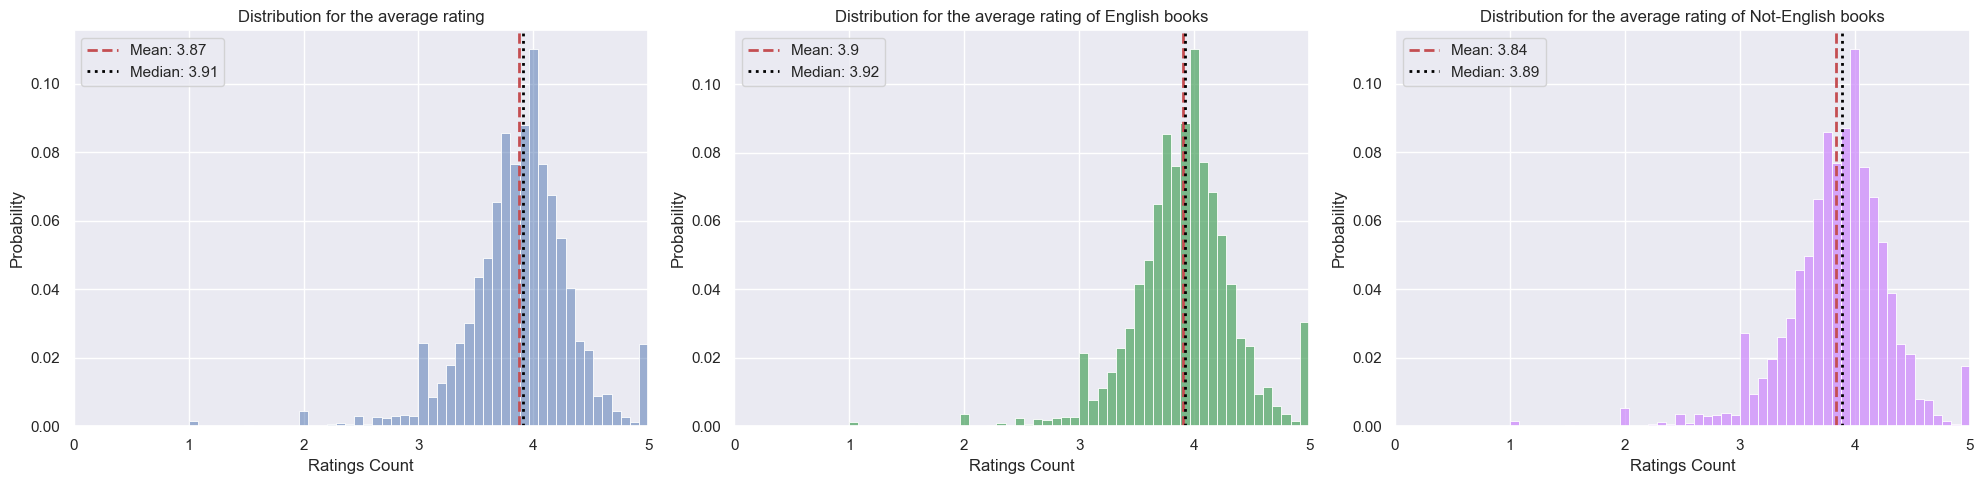

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# First plot: average rating distribution
sns.set(style="darkgrid")
sns.histplot(books[['average_rating']], bins=50, stat="probability", ax=axes[0])
axes[0].set_xlim(0, 5)
axes[0].set_xlabel("Ratings Count")
axes[0].set_ylabel("Probability")
axes[0].set_title("Distribution for the average rating")
axes[0].axvline(float(average_rating_summary['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {average_rating_summary["Mean"][0]}')
axes[0].axvline(float(average_rating_summary['50%'][0]), color='black', linestyle='dotted', linewidth=2, label=f'Median: {average_rating_summary["50%"][0]}')
axes[0].legend()

# Second plot: average rating distribution for english books
sns.set(style="darkgrid")
sns.histplot(english['average_rating'], bins=50, stat="probability", color='g', ax=axes[1])
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("Ratings Count")
axes[1].set_ylabel("Probability")
axes[1].set_title("Distribution for the average rating of English books")
axes[1].axvline(float(avg_rating_english['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {avg_rating_english["Mean"][0]}')
axes[1].axvline(float(avg_rating_english['50%'][0]), color='black', linestyle='dotted', linewidth=2, label=f'Median: {avg_rating_english["50%"][0]}')
axes[1].legend()

# Third plot: average rating distribution for not-english books
sns.set(style="darkgrid")
sns.histplot(no_english['average_rating'], bins=50, stat="probability", color=(0.807, 0.549, 0.988), ax=axes[2])
axes[2].set_xlim(0, 5)
axes[2].set_xlabel("Ratings Count")
axes[2].set_ylabel("Probability")
axes[2].set_title("Distribution for the average rating of Not-English books")
axes[2].axvline(float(avg_rating_noenglish['Mean'][0]), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {avg_rating_noenglish["Mean"][0]}')
axes[2].axvline(float(avg_rating_noenglish['50%'][0]), color='black', linestyle='dotted', linewidth=2, label=f'Median: {avg_rating_noenglish["50%"][0]}')
axes[2].legend()

# 
plt.tight_layout()
plt.show()

To check the normality of distributions we ran a Shapiro-Wilk test however this test suffers from a noticeable increase in sensitivity in the case of samples too large, but while it gave us the same result of the kurtosis index we can reiterate that the distribution are non normal.

In [22]:
# shapiro-wilk test
stat_avg, p_value_avg_rating = stats.shapiro(books['average_rating'])
stat_avg_eng, p_value_english = stats.shapiro(english['average_rating'])
stat_avg_no_eng, p_value_no_english = stats.shapiro(no_english['average_rating'])

Norm_test = {'Distribution': ['Average Ratings', 'Avg Ratings | English', 'Avg Rating | No-English'],
                'Statistic': [stat_avg, stat_avg_eng, stat_avg_no_eng],
                'p-Value':  [p_value_avg_rating, p_value_english, p_value_no_english],}

Norm_test = pd.DataFrame(Norm_test)
Norm_test

Distribution  Statistic  p-Value
0          Average Ratings   0.946465      0.0
1    Avg Ratings | English   0.950237      0.0
2  Avg Rating | No-English   0.941560      0.0

Since normal hypotheses are not verified we cannot implement parametric statistical tests for the comparison of distributions such as the t-test(or z-test for large sample) and the f-test therefore we can only use the non-parametric tests like the Kolmogorov-Smirnov (KS test) and the Mann-Whitney test.

The first has a null hypotesis that the two samples come from the same distribution whatever it is. This test is performed by comparing the empirical distribution functions (CDF) of the two distributions by calculating the maximum absolute difference between the CDFs and comparing it with a critical value. 

$$ D_{n,m} > c(\alpha)\sqrt{\frac{n+m}{n \cdot m}}$$

Where $ \ D_{n,m}= sup_x | F_{1,n}(x) - F_{2,m}(x) \ $ and $ \ c(\alpha) = \sqrt{-ln(\frac{\alpha}{2}) \cdot \frac{1}{2}}$

However, for very large samples it would be preferable to use the Mann-Whitney test under the assumption that the two samples are independent and with the same null hypotesis.

In [32]:
# Mann-Whitney test
U_statistic, u_value = mannwhitneyu(english['average_rating'], no_english['average_rating'])

# Kolmogorov-Smirnov test (KS test)
ks_statistic, ks_value = ks_2samp(english['average_rating'], no_english['average_rating'])

dist_test = {'Distribution Compared': ['Avg Ratings|English with Avg Rating|No-English'],
                'KS-Statistic': [ks_statistic],
                'ks-value': [ks_value],
                'U-Statistic': [U_statistic],
                'u-Value':  [u_value] }

dist_test = pd.DataFrame(dist_test)
dist_test

Distribution Compared  KS-Statistic  ks-value  \
0  Avg Ratings|English with Avg Rating|No-English      0.038147       0.0   

    U-Statistic  u-Value  
0  4.031595e+11      0.0

From the p-values of both tests we can reject the null hypothesis that the two samples come from the same distribution although the descriptive statistics and the histograms made to think the opposite.

### 3) **About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.**

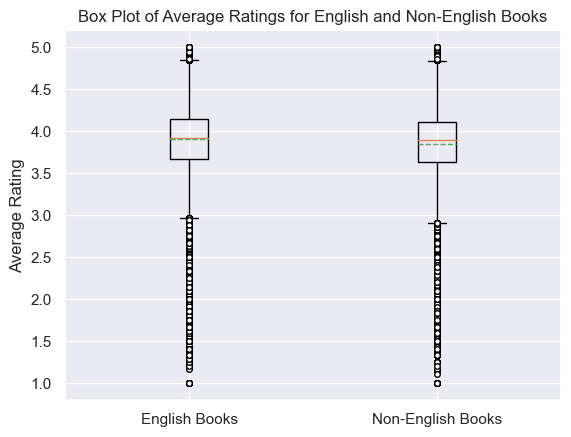

In [39]:
# split the dataset into 2 groups, one for English and one for non-English books
english = books[(books['language'] == "eng") | (books['language'] == "en-US") | (books['language'] == "US") | (books['language'] == "en-GB")]
no_english = books[(books['language'] != "eng") & (books['language'] != "en-US") & (books['language'] != "US") & (books['language'] != "en-GB")]

# extract the average ratings for each group
avg_rating_english = english['average_rating']
avg_rating_no_english = no_english['average_rating']

# Create a Box Plot for English and no-English books
sns.set(style="darkgrid")  
flier_marker = dict(marker='o', markerfacecolor='white', markersize=4, linestyle='none')
plt.boxplot([avg_rating_english, avg_rating_no_english], labels=['English Books', 'Non-English Books'], flierprops=flier_marker, meanline=True, showmeans=True)
plt.title('Box Plot of Average Ratings for English and Non-English Books')
plt.ylabel('Average Rating')
plt.show()

In [36]:
avg_rating_english = statistic(english['average_rating'])
avg_rating_noenglish = statistic(no_english['average_rating'])

Dist_compare = {'Variable': ['Average Ratings - English books', 'Average Ratings - No English books'],
        'Count':  [avg_rating_english['Count'][0],avg_rating_noenglish['Count'][0]],
        'Mean': [avg_rating_english['Mean'][0], avg_rating_noenglish['Mean'][0]],
        'Std': [avg_rating_english['Std'][0], avg_rating_noenglish['Std'][0] ],
        'Min': [avg_rating_english['Min'][0], avg_rating_noenglish['Min'][0] ],
        '25%': [avg_rating_english['25%'][0], avg_rating_noenglish['25%'][0] ],
        '50%': [avg_rating_english['50%'][0], avg_rating_noenglish['50%'][0] ],
        '75%': [avg_rating_english['75%'][0], avg_rating_noenglish['75%'][0] ],
        'Max': [avg_rating_english['Max'][0], avg_rating_noenglish['Max'][0] ],
        'CV': [avg_rating_english['CV'][0] , avg_rating_noenglish['CV'][0]  ],
        'Range': [avg_rating_english['Range'][0], avg_rating_noenglish['Range'][0] ],
        'IQ Range': [avg_rating_english['IQ Range'][0], avg_rating_noenglish['IQ Range'][0] ]}

Dist_compare = pd.DataFrame(Dist_compare)
Dist_compare

Variable     Count  Mean   Std  Min   25%   50%  \
0     Average Ratings - English books  882303.0  3.90  0.45  1.0  3.67  3.92   
1  Average Ratings - No English books  860010.0  3.84  0.46  1.0  3.63  3.89   

    75%  Max    CV  Range  IQ Range  
0  4.14  5.0  0.12    4.0      0.47  
1  4.11  5.0  0.12    4.0      0.48

A Box Plot is a graphical representation used to visualize the distribution of a dataset. It provides a visual summary of statistical measures, including the median, quartiles, and potential outliers:

- Box: The primary element of a Box Plot is the rectangular box. This box represents the Interquartile Range (IQR), which is the range between the 1st quartile and the 3rd quartile. The length of the box indicates the spread of the middle 50% of the data. A longer box indicates that the data in this range is more spread out.

- Yellow line inside the Box: This horizontal line inside the box represents the median (2nd quartile) of the dataset. The median is the middle value when the data is sorted in ascending or descending order. The median separates the data into two halves, with half of the values falling above and half below it.

- Green line: This horizontal line rapresent the mean of the distribution. Its position is variable and can be found anywhere in the distribution both inside and outside the box. The reciprocal position between mean and median gives us a first idea about the symmetry of the function. If the two indicators coincide or are very close to each other then the distribution is symmetrical while, on the contrary, the greather the distance that separates them and the greater will be the asymmetry. This discrepancy occurs because the average is not a robust index and is therefore susceptible to the presence of outliers.

- Whiskers: The whiskers extend from the edges of the box to the (Q1-1.5IQR) and (Q3+1.5IQR) and represent a slight adjustment of the range in order to identify potential outliers. The whiskers indicate the data's spread and are a first indication of the variability of the phenomenon although it is also not a robust index.

- Outliers: Individual data points outside the whiskers are considered potential outliers who are identified by all those values that exceed the threshold given by Q1-1.5IQR for the lower whisker and by Q3+1.5IQR for the upper whisker. The outliers are values that are unusually high or low compared to the rest of the data.

Based on this index analysis, we can conclude that there does not appear to be a strong difference in average between the average rating of books and the language in which they are written.

### 4) **It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.**

In [6]:
# extraction of the data we need
df_authors = pd.read_json('lighter_authors.json', lines=True)
df_regression = df_authors[['ratings_count', 'fans_count']]

First we suppose that the variable `raings_count` is linearly linked with the attribute `fans_count` and we verify this hypothesis first by looking at the linear correlation between the two variables.

In [7]:
round(df_regression.corr(),3)

ratings_count  fans_count
ratings_count          1.000       0.581
fans_count             0.581       1.000

Given the result of $0.58$ we can say that the two variables are linearly linked and that the increase *in average* of one corresponds to an increase *in average* of the other and vice versa. 

Now we proceed as mentioned in the task assuming that `ratings_count` ($Y$) is the response variable of a simple linear regressive model with a single indipendent variable `fans_count` ($X$) or, in other word, we are assuming that the ratings count is a linear combination of the number of fans plus an error:
$$ \widehat{y}= \beta_{0} + \beta_{1}X + e $$
Defined the model we will proceed with the following assessments:

1) Evaluation of the significance of the model through the *Fisher test* that:
    -  has as a null hypothesis that all regression coefficients are simultaneously equal to zero 
\begin{equation*}
    \begin{cases}
    H_0: \beta_1=...=\beta_k=0 \\
    H_1: \exists j :  B_j \ne 0
    \end{cases}
\end{equation*}

    - a test statistic equal to the ratio between the deviation of the model and the deviation of the errors 
    $$ \ F=\frac{Var(R)}{Var(E)} \ \underset{H_0}{\sim}\ F_{k, (n-k-1)} \ \ \ \text{where} \ \ n = \text{number of rows} \ \ \ \text{and} \ \ \ k = \text{number of indipendent variable}$$


2) Evaluation of the significance of every regression coefficients of the model through the *t-Test* that:
    - has as a null hypothesis that on regression coefficients is equal to zero 
\begin{equation*}
    \begin{cases}
    H_0: \beta_i=0 \\
    H_1: \beta_i \ne 0
    \end{cases}
\end{equation*}   

    - a test statistic equal to 
    $$ t=\frac{\widehat{{\beta_i}}}{\sigma_{\beta_i}^2} \ \underset{H_0}{\sim} \ N(0,1) \qquad \text{with} \qquad n>>0 $$

    - and a confidence interval with a width of $1-\alpha$ equal to
    $$\mathbb{P}[\widehat{{\beta_i}}- z_{\frac{\alpha}{2}}\sigma_{\widehat{{\beta_i}}}^2 \le \beta_i \le \widehat{{\beta_i}}^2+ z_{\frac{\alpha}{2}}\sigma_{\widehat{{\beta_i}}}^2]=1-\alpha$$


3) Evaluation of the goodness of the regression model with the $R^2$ index which indicate the proportion of variability that the regressive model explains respect to the total variability of the phenomenon. 
    $$0\le R^2=\frac{dev(R)}{dev(T)}\le1$$ 
    This index is increasing as the number of samples and indipendent variable increases so if can be adjusted with the index $\ \ R^2_{adj}$
    $$ R_{adj}^2= R^2- \frac{k}{n-k-1}(1-R^2) \le R^2 \qquad \text{and if} \qquad n \to +\infty \qquad R_{a}^2= R^2$$

In [17]:
model = ols('ratings_count ~ fans_count', data=df_regression).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ratings_count   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                 1.788e+05
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:15:46   Log-Likelihood:            -4.4685e+06
No. Observations:              351767   AIC:                         8.937e+06
Df Residuals:                  351765   BIC:                         8.937e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2391.5638    134.233     17.816      0.0

Given the results of the various tests on the regressive model we can conclude that the model is significant ($f-value = 0.00$) with all the regression coefficients significant ($ p-value =0.0$) but it explains an extremely low proportion of variability ($R^2=0.337$) to adequately predict the values of the response variable. In addition the Omnibus test tells us that the errors doesn't follow a normal distribution and the high value of the Skewness tells us that the data are strongly asymmetric. In the end the condition number suggests there are other numerical problems in the data that we assume are the fact that the distributions of the two variables are all concentrated in one point (see fans_count and ratings_count EDA for other details). 

All these considerations about how badly the linear regression perform can be checked graphically in the underlying scatterplot and its heatmap.

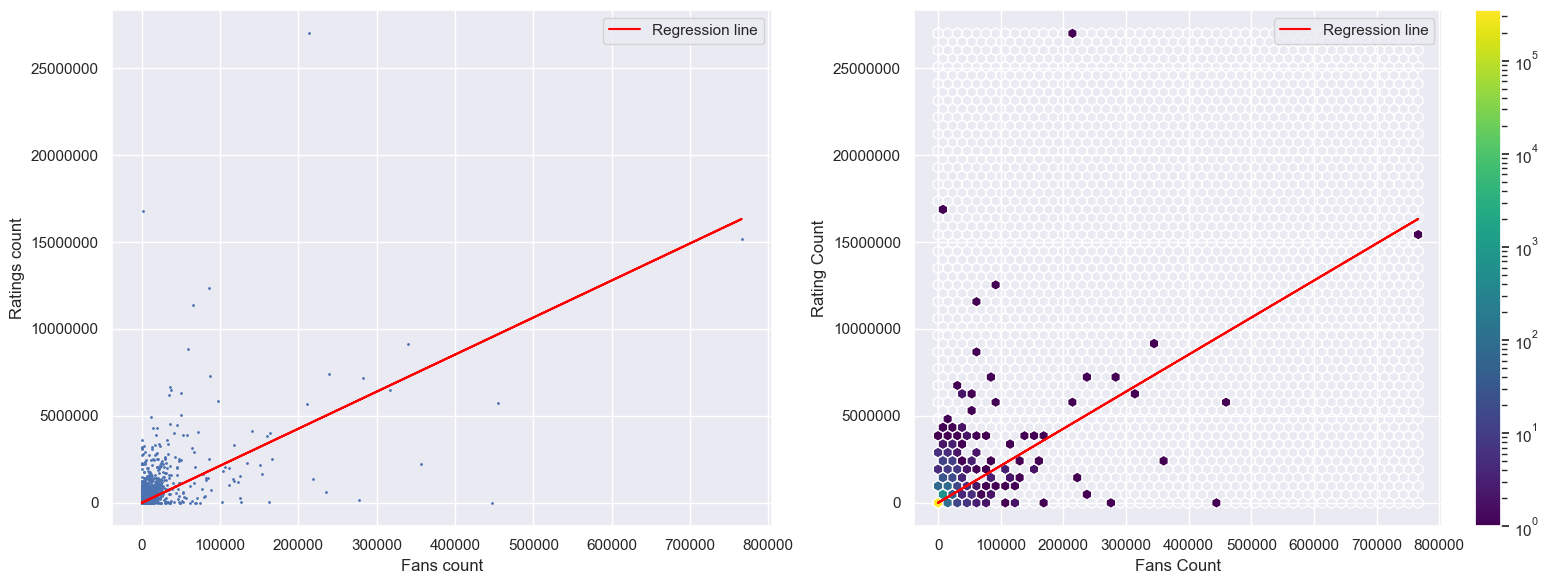

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.set_style('darkgrid')

# Grafico di dispersione (Scatterplot)
ax1.scatter(df_regression['fans_count'], df_regression['ratings_count'], s=1)

# Estrai i coefficienti del modello
coefficients = model.params['fans_count']
intercept = model.params['Intercept']

# Calcola la retta di regressione
regression_line = intercept + coefficients * df_regression['fans_count']

# Traccia la retta di regressione sul primo grafico
ax1.plot(df_regression['fans_count'], regression_line, color='red', label="Regression line")
ax1.ticklabel_format(axis='y', style='plain')

# Aggiungi etichette agli assi
ax1.set_xlabel('Fans count')
ax1.set_ylabel('Ratings count')
ax1.legend()

# Heatmap
hb = ax2.hexbin(df_regression['fans_count'], df_regression['ratings_count'], gridsize=50, bins='log', edgecolors='white', cmap='viridis')

# Traccia la retta di regressione sulla heatmap
ax2.plot(df_regression['fans_count'], regression_line, color='red', label="Regression line")

ax2.set_xlabel("Fans Count")
ax2.set_ylabel("Rating Count")
ax2.ticklabel_format(axis='y', style='plain')

# Aggiungi una barra del colore
cb = plt.colorbar(hb, ax=ax2)

# Mostra la legenda
ax2.legend()

# Mostra la figura
plt.tight_layout()
plt.show()

### 5) **Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.**

A statistical test is a procedure based on sample data used in statistics to assess whether a hypothesis or a statement concerning one or more parameters of the population or several populations may be not rejected or rejected on the basis of the collected sample data.

It usually consists of a null hypothesis ($H_{0}$) that we want to verify and a contrary alternative hypothesis ($H_{1}$). To each statistical test is associated a statistical test function of the sample data that associates to each sample a numerical value that may belong either to the acceptation region of the test or to the rejection region. Both of them are partitions of the sample space having empty intersection and union equal to the sample space itself. However the acceptance/rejection regions are not unique but depend on a $\alpha$ parameter which corresponds to the nominal test width or the probability of error of the first type equal to the probability that, in the case of $H_{0}$ is true it is wrongly rejected by the sample. On the contrary it is called the power of a test the probability of rejecting the null hypothesis when this is false.

To not reject or reject the null hypothesis of a test is usually used the p-value which is the probability, under the null hypothesis, of sampling a test statistic at least as extreme as that which was observed. If this value is under the $\alpha$ threshold we chose a priori then we reject the null hypothesis.

Statistical tests can also be divided into two types: parametric tests and non parametric tests. They differ in that the former require strong assumptions about data distributions such as their normality, independence or homogeneity of variability. The latter, on the contrary, do not suffer from these limitations on the distribution of data (also allowing to make tests on ordinal variables) that in practice may not always be true and are generally more robust acontro abnormal values or other anomalies. However, paramentric tests, when applicable, are generally preferred to non-parametric tests because of the greater power (probability of rejecting the null hypothesis when this is false).

In general there is no real rule on which of these two types of tests is preferable to perform, it all depends on the type of sample data available to us. 

In data analysis and data minig some useful parametric and non parametric statistical test are:

- `Student's t-Test`$\to$ used to compare the means of two groups to see if there are significant differences between them.

- `Analysis of Variance` (ANOVA) $\to$ used to compare the means of three or more groups and determine if there are significant differences among them.

- `Chi-Square Test` $\to$ used to check the association between two categorical variables and determine if the association is significant.

- `Wilcoxon and/or Mann-Whitney Test` $\to$ used to compare two independent unpaired samples and determine if there are significant differences between them, especially when the data does not follow a normal distribution.

- `Univariate/Multivariate Regression` $\to$ used to analyzing relationships between multiple variables

- `Logistic/Probit Regression` $\to$ used to model and understand the relationships between binary or categorical dependent variables and one or more quantitative independent variables.

- `Shapiro-Wilk Test` $\to$ used to check if a variable follow a normal distribution

- `Kolmogorov-Smirnov (KS) Test` $\to$  used to check if two sample comes from the same distribution

---

## #Bonus Point

### 1.1) Finding the authors with at least 100 reviews

In [32]:
# Reading the data using the Dask library

dd_authors = dd.read_json('lighter_authors.json', lines=True)
dd_authors.head()

ratings_count  average_rating  text_reviews_count  \
0        2862064            4.19               62681   
1        1417316            4.02               84176   
2          56159            4.53                 352   
3           3302            3.79                 480   
4           7979            3.60                 772   

                                            work_ids  \
0  [3078186, 135328, 1877624, 74123, 3078120, 104...   
1  [613469, 2305997, 940892, 2611786, 7800569, 31...   
2  [17150, 808427, 20487307, 90550, 25460625, 171...   
3  [4417, 14300808, 14780, 3796968, 44703121, 103...   
4  [13330815, 19109351, 42306244, 72694240, 26291...   

                                            book_ids  works_count  id  \
0  [386162, 13, 8695, 8694, 6091075, 365, 569429,...          106   4   
1  [9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...           75   7   
2  [349254, 15222, 14833682, 15221, 18126815, 152...           14  10   
3  [40, 9416484, 12482, 3753106, 26889789, 104764...           45  12   
4  [8466327, 15739968, 22756778, 51026133, 260451...           61  14   

                      name  gender  \
0            Douglas Adams    male   
1              Bill Bryson    male   
2              Jude Fisher  female   
3  James Hamilton-Paterson    male   
4              Mark Watson    male   

                                           image_url  \
0  https://images.gr-assets.com/authors/159137433...   
1  https://images.gr-assets.com/authors/157859752...   
2  https://images.gr-assets.com/authors/141145711...   
3  https://images.gr-assets.com/authors/127051738...   
4  https://images.gr-assets.com/authors/133175379...   

                                               about  fans_count  
0  Douglas Noël Adams was an English author, comi...       19826  
1  William McGuire "Bill" Bryson, OBE, FRS was bo...       16144  
2  Jude Fisher is the pseudonym for <a href="http...          60  
3  James Hamilton-Paterson's work has been transl...          72  
4  Mark Andrew Watson (born 13 February 1980) is ...         179

In [23]:
# Finding the authors with at least 100 reviews using Dask

start_time = time.time()

filtered_authors_dd = dd_authors.loc[dd_authors['text_reviews_count'] >= 100, 'name']
filtered_authors_dd = filtered_authors_dd.compute()

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} ms".format(execution_time * 1000))

Execution time: 8894.99 ms


In [24]:
filtered_authors_dd

0                   Douglas Adams
1                     Bill Bryson
2                     Jude Fisher
3         James Hamilton-Paterson
4                     Mark Watson
                   ...           
351702             Holly Castillo
351711               Noah Barnett
351712              Danielle Town
351724           Kathleen Valenti
351736                 Emma Glass
Name: name, Length: 64565, dtype: object

In [25]:
# Finding the authors with at least 100 reviews using Pandas
start_time = time.time()

filtered_authors_df = df_authors.loc[df_authors['text_reviews_count'] >= 100, 'name']

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} ms".format(execution_time * 1000))

Execution time: 16.71 ms


In [26]:
filtered_authors_df

0                   Douglas Adams
1                     Bill Bryson
2                     Jude Fisher
3         James Hamilton-Paterson
4                     Mark Watson
                   ...           
351702             Holly Castillo
351711               Noah Barnett
351712              Danielle Town
351724           Kathleen Valenti
351736                 Emma Glass
Name: name, Length: 64565, dtype: object

The Execution time using Dask is **8894.99 ms** while the Execution time for pandas is **16.71 ms** which makes pandas much faster compared to dask.

### 1.2) Joining authors and Books Json using the User_ID 

In [33]:
# Rename the column 'id' to 'author_id' in the authors DataFrame
df_authors_renamed = df_authors.copy()
df_authors_renamed = df_authors_renamed.rename(columns={'id': 'author_id'})

In [37]:
# number of books that was matched with an author ID
books_matched = 0
books_df = pd.read_json('lighter_books.json', lines=True, chunksize=10000)

# Iterate over blocks and merge each block with the 'df_authors_renamed' DataFrame
for chunk in books_df:
    # Create a DataFrame from the partition
    block = pd.DataFrame(chunk)
    # Merge the block with authors based on 'author_id'
    merged_block = pd.merge(block, df_authors_renamed, on='author_id', how='inner')
    books_matched += len(merged_block)

books_matched

7027431

In [29]:
books_df = pd.read_json('lighter_books.json', lines=True, chunksize=10000)

number_of_books = 0
# Iterate over blocks and merge each block with the 'df_authors_renamed' DataFrame
for chunk in books_df:
    # Create a DataFrame from the partition
    block = pd.DataFrame(chunk)

    number_of_books += len(block)

print(books_matched, 'books were matched out of', number_of_books, 'books')

7027431 books were matched out of 7027431 books


In [30]:
books_df = pd.read_json('lighter_books.json', lines=True, chunksize=10000)

books_no_authors = 0

for chunk in books_df:
    # Create a DataFrame from the partition
    block = pd.DataFrame(chunk)
    books_with_null_author = block[block['author_id'].isnull()]

    books_no_authors += len(books_with_null_author)

print( 'There are', books_no_authors, 'books with no authors')

There are 0 books with no authors


- The authors dataframe was merged with the books dataframe based on the "author ID" and all the books were matched with authors from the authors dataframe.

- To double-check, no books were found with null as a value in the "author_id" column which validates the previous result.

- the number of matched books is 7027431 out of 7027431 books. 

### 2) Labeling authors into genres based on the "about" column

In [25]:
# Copy the authors DataFrame
authors_clustered = df_authors.copy()

# Function to classify authors based on keywords
def classify_author(row):

    keywords = {
    "Fiction": ["novel", "literary", "prose", "storytelling", "narration"],
    "Science Fiction": ["sci-fi", "futuristic", "space", "technology", "extraterrestrial"],
    "Mystery/Thriller": ["suspense", "detective", "crime", "whodunit", "investigation"],
    "Fantasy": ["magic", "mythical", "magical creatures", "enchantment", "quest"],
    "Horror": ["terror", "supernatural", "haunting", "suspense", "fear"],
    "Romance": ["love", "relationships", "passion", "heartfelt", "romantic"],
    "Historical Fiction": ["past", "historical events", "period piece", "authenticity", "time period"],
    "Non-Fiction (Science)": ["scientific", "facts", "research", "knowledge", "discovery"],
    "Biography": ["life story", "autobiography", "memoir", "personal journey", "history"],
    "Self-Help": ["personal development", "motivation", "well-being", "improvement", "growth"],
    "Poetry": ["verse", "rhyme", "poetic", "metaphor", "stanza"],
    "Children's Literature": ["kids", "child", "bedtime stories", "picture books", "imagination"],
    "Young Adult Fiction": ["adolescents", "coming of age", "teenagers", "youth", "young adult"],
    "Fantasy (Young Adult)": ["magic", "teens", "mythical creatures", "adventure", "enchantment"],
    "Science": ["scientific", "research", "discovery", "knowledge", "facts"],
    "Mystery (Young Adult)": ["teen detectives", "suspense", "young investigators", "mystery-solving", "whodunit"],
    "Crime Fiction": ["detective", "crime", "investigation", "suspense", "criminal"],
    "Travel Writing": ["journey", "exploration", "adventure", "destination", "cultural"],
    "Graphic Novels": ["visual storytelling", "comics", "illustrations", "panels", "graphic format"],
    "Philosophy": ["thought", "ethics", "existentialism", "philosophical", "metaphysical"]
}
    about_text = row["about"].lower()
    for category, category_keywords in keywords.items():
        if any(keyword in about_text for keyword in category_keywords):
            return category
    return "Other"

# Apply the classification function to create the "genre" column
authors_clustered["genre"] = authors_clustered.apply(classify_author, axis=1)

authors_clustered[['name', 'about', 'genre']]

name  \
0                 Douglas Adams   
1                   Bill Bryson   
2                   Jude Fisher   
3       James Hamilton-Paterson   
4                   Mark Watson   
...                         ...   
351762               Lyon Gamer   
351763             Brian  Hatch   
351764            Nicholas Baer   
351765        James Ketron Ross   
351766     James           Ross   

                                                    about      genre  
0       Douglas Noël Adams was an English author, comi...    Fiction  
1       William McGuire "Bill" Bryson, OBE, FRS was bo...  Biography  
2       Jude Fisher is the pseudonym for <a href="http...    Fiction  
3       James Hamilton-Paterson's work has been transl...    Fiction  
4       Mark Andrew Watson (born 13 February 1980) is ...    Fiction  
...                                                   ...        ...  
351762  Lyon Gamer<br />nickname sotto cui si nasconde...      Other  
351763  Brian was born, he lived a little, and he has ...      Other  
351764  Nicholas Baer is Visiting Assistant Professor ...  Biography  
351765  James Ross was a physician, winemaker, artist,...    Fiction  
351766  <i>Librarian Note: There is more than one auth...      Other  

[351767 rows x 3 columns]

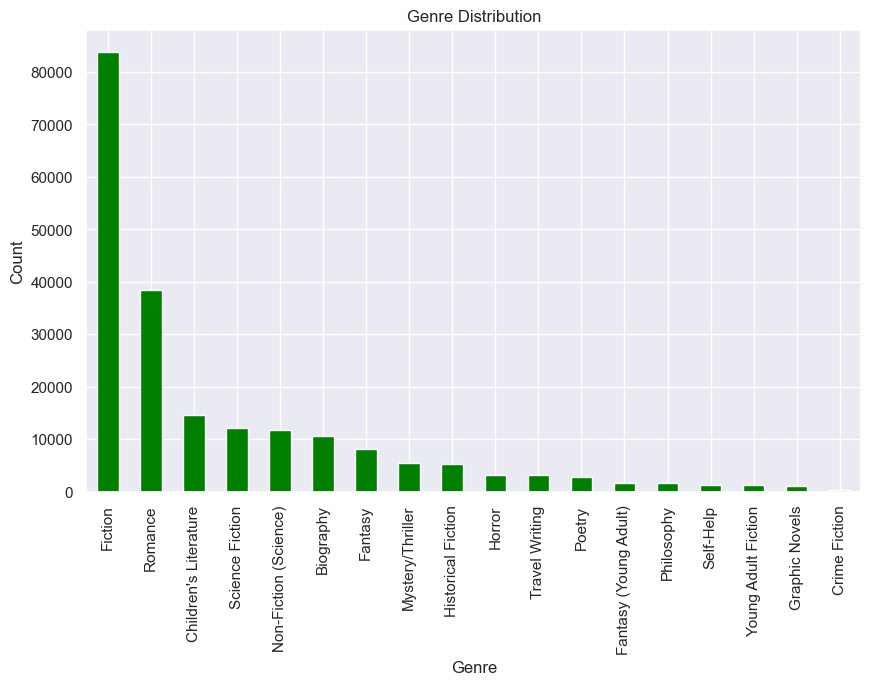

In [26]:
# Count the occurrences of each genre
genre_counts = authors_clustered['genre'].value_counts()
genre_counts.pop('Other')

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='green')
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

- In this part, the authors are being the classified into genres based on the "about" column in the authors dataset.

- The classification works as follows:

    1. Identify the genres.

    2. for each genres, identify a set of unique words. The genres and the key words are as follows:

        - Fiction: novel, literary, prose, storytelling, narration
        
        - Science Fiction: sci-fi, futuristic, space, technology, extraterrestrial
        - Mystery/Thriller: suspense, detective, crime, whodunit, investigation
        - Fantasy: magic, mythical, magical creatures, enchantment, quest
        - Horror: terror, supernatural, haunting, suspense, fear
        - Romance: love, relationships, passion, heartfelt, romantic
        - Historical Fiction: past, historical events, period piece, authenticity, time period
        - Non-Fiction (Science): scientific, facts, research, knowledge, discovery
        - Biography: life story, autobiography, memoir, personal journey, history
        - Self-Help: personal development, motivation, well-being, improvement, growth
        - Poetry: verse, rhyme, poetic, metaphor, stanza
        - Children's Literature: kids, child, bedtime stories, picture books, imagination
        - Young Adult Fiction: adolescents, coming of age, teenagers, youth, young adult
        - Fantasy (Young Adult): magic, teens, mythical creatures, adventure, enchantment
        - Science: scientific, research, discovery, knowledge, facts
        - Mystery (Young Adult): teen detectives, suspense, young investigators, mystery-solving, whodunit
        - Crime Fiction: detective, crime, investigation, suspense, criminal
        - Travel Writing: journey, exploration, adventure, destination, cultural
        - Graphic Novels: visual storytelling, comics, illustrations, panels, graphic format
        - Philosophy: thought, ethics, existentialism, philosophical, metaphysical

    3. Loop over the about column of the authors and match the each author to a genre using the list of keywords above.

    4. If no matching was found the author is mapped as "other".

- A histogram of the authors distribution was drawn based on the genre and the top 3 genres were Fiction, Romance, and Children Literature.


---

## #Command line question (CLQ)

To obtain the code contained in the 'commandline_LLM.sh' script, I engaged the ChatGPT chatbot in a multi-step process. It began with my request to create a shell script for the specific task assignment, I also provided the chatbot with the 'commandline_original.sh' script, which I had previously implemented, requesting its assistance in optimizing the code for greater compactness. 
In addition to the script and the request, I supplied a concise description of the expected outcome and shared a portion of the 'series.json' file, thereby providing contextual information for understanding the JSON structure.

The initial result provided by ChatGPT did not meet the functional requirements, resulting in the need for additional clarification. I explained that the task involved iterating through each row of the dataset, summing the books_count values within the works field and identify and present the top 5 series, including their ID, title, and the total count of books.
Finally, after getting a working code, I modified it a bit so as to get proper formatting by aligning the values in columns.

The script generated by ChatGPT is slightly faster than mine when run, but both correctly compute the desired result:
to verify the accuracy and correctness of the result provided by ChatGPT, I compared the output of the "commandline_LLM.SH" script with the output of my original script. My original script's output matched the expected result provided on the GitHub repository, indicating that the ChatGPT generated code was correct.

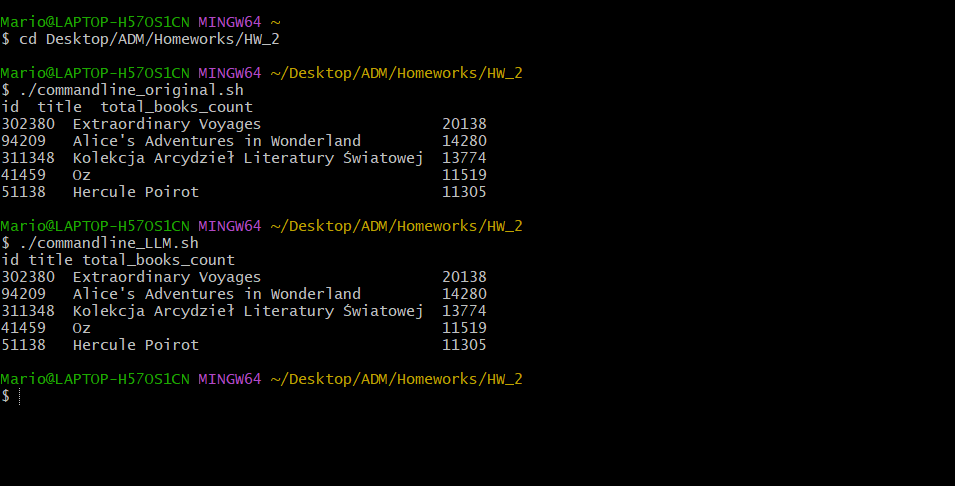

---

## #AWS Question (AWSQ)

In [10]:
# This is the code within the 'aws.py' script. Please test it by executing this cell.

start_time = time.time()  # Record the start time

tag_counter = Counter()  # Initialize a Counter to keep track of number of tags

chunk_size = 200
for chunk in pd.read_json('list.json', lines=True, chunksize = chunk_size): # read the list.json file in chunks
    for _, row in chunk.iterrows():                                         # Iterate over DataFrame rows as (index, Series) pairs, we use "_" to ignore the indexes
        tags = row['tags']                                                  # extract tags and check if it's a list of values
        if isinstance(tags, list):                                        
            tag_counter.update(tags)                                        # update the counter of each tag contained in the tags list

# Find the top 5 most common tags
top5_tags = tag_counter.most_common(5)
top5_tags_df = pd.DataFrame(top5_tags, columns=['tag', '#usage'])   # Create dataframe with the 5 most common tags

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the elapsed time
print(top5_tags_df)
print("\n")
print('The execution time is', execution_time, 'seconds')

               tag  #usage
0          romance    6001
1          fiction    5291
2      young-adult    5016
3          fantasy    3666
4  science-fiction    2779


The execution time is 29.346018075942993 seconds


- Firstly, an EC2 instance was created on AWS using the configuration in the images belows:

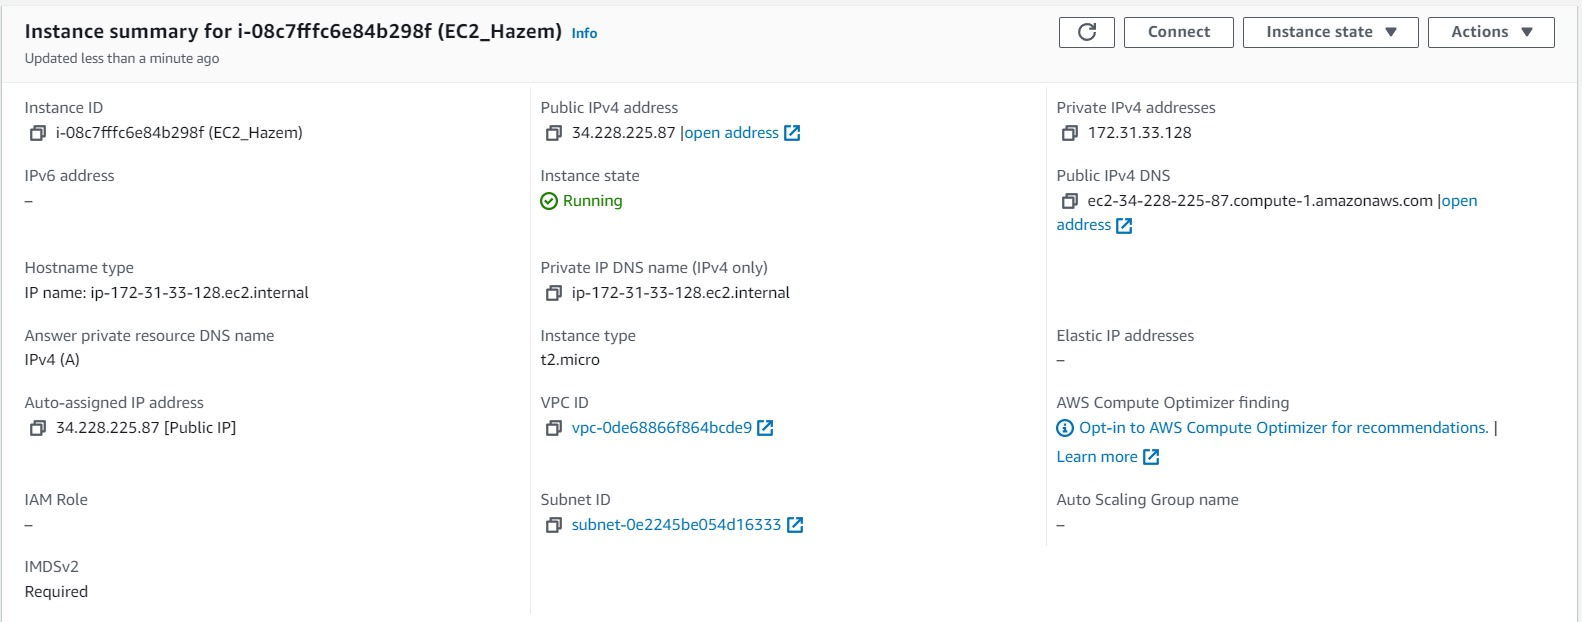
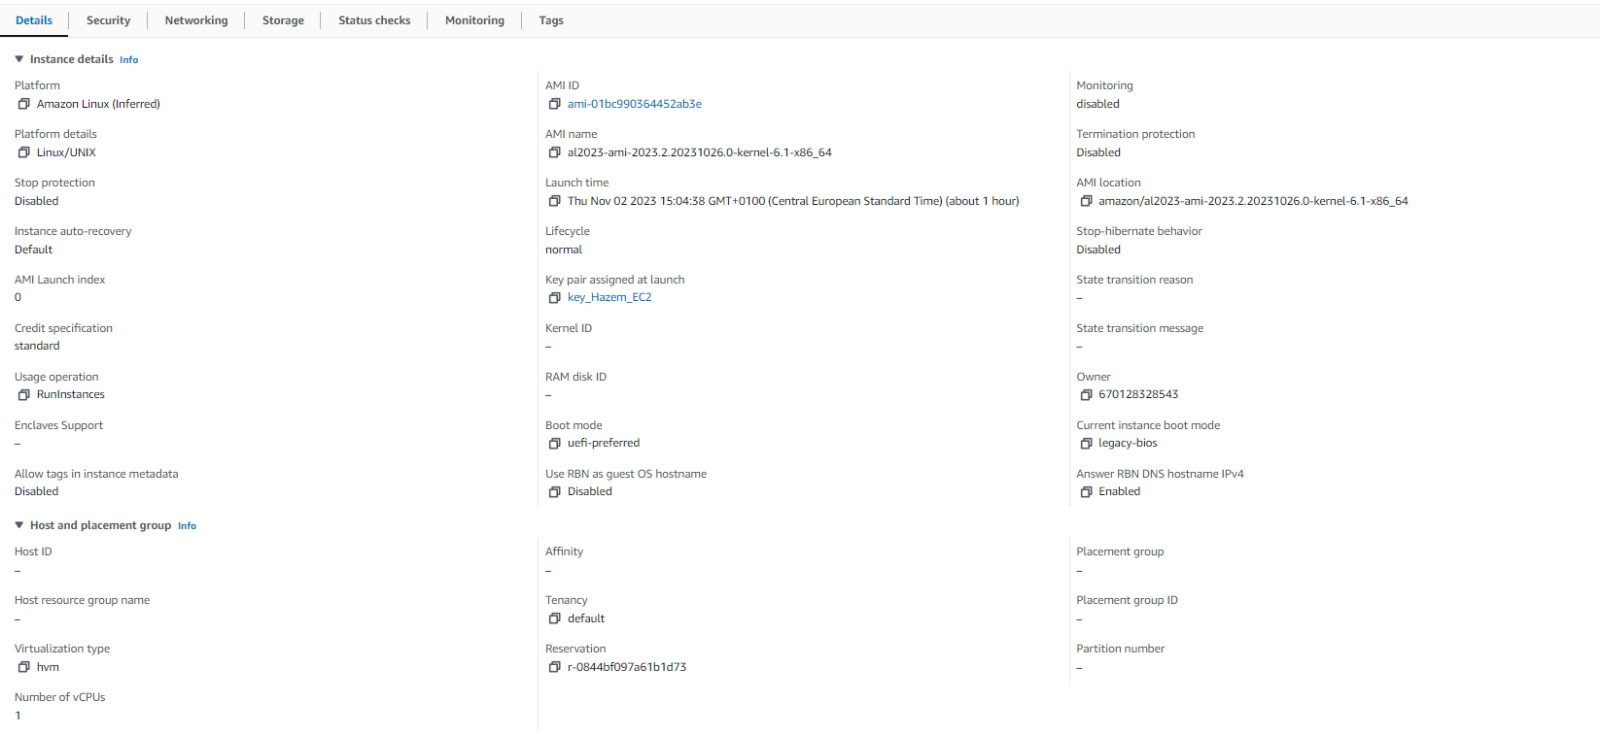

- Establish a connection with the EC2 instance using this command in a powershell terminal: **ssh -i key_Hazem_EC2.pem ec2-user@ec2-34-228-225-87.compute-1.amazonaws.com**

- Create a directory called 'localfiles' using the command: **mkdir localfiles**

- upload the list.json and the aws.py files to the EC2 instance running the following commands in another powershell terminal:

   - **scp -i .\key_Hazem_EC2.pem .\list.json ec2-user@ec2-34-228-225-87.compute-1.amazonaws.com:localfiles** 

   - **scp -i .\key_Hazem_EC2.pem .\aws.py ec2-user@ec2-34-228-225-87.compute-1.amazonaws.com:localfiles**

- Install pip using the command: **sudo yum install python3-pip**

- install pandas using the command: **pip3 install pandas**

- Update the permission for the file aws.py using the command: **chmod +x aws.py**

- run the file using the commmand: **python3 aws.py**

- The following image shows the output and the running time for both the local machine and the EC2 instance:

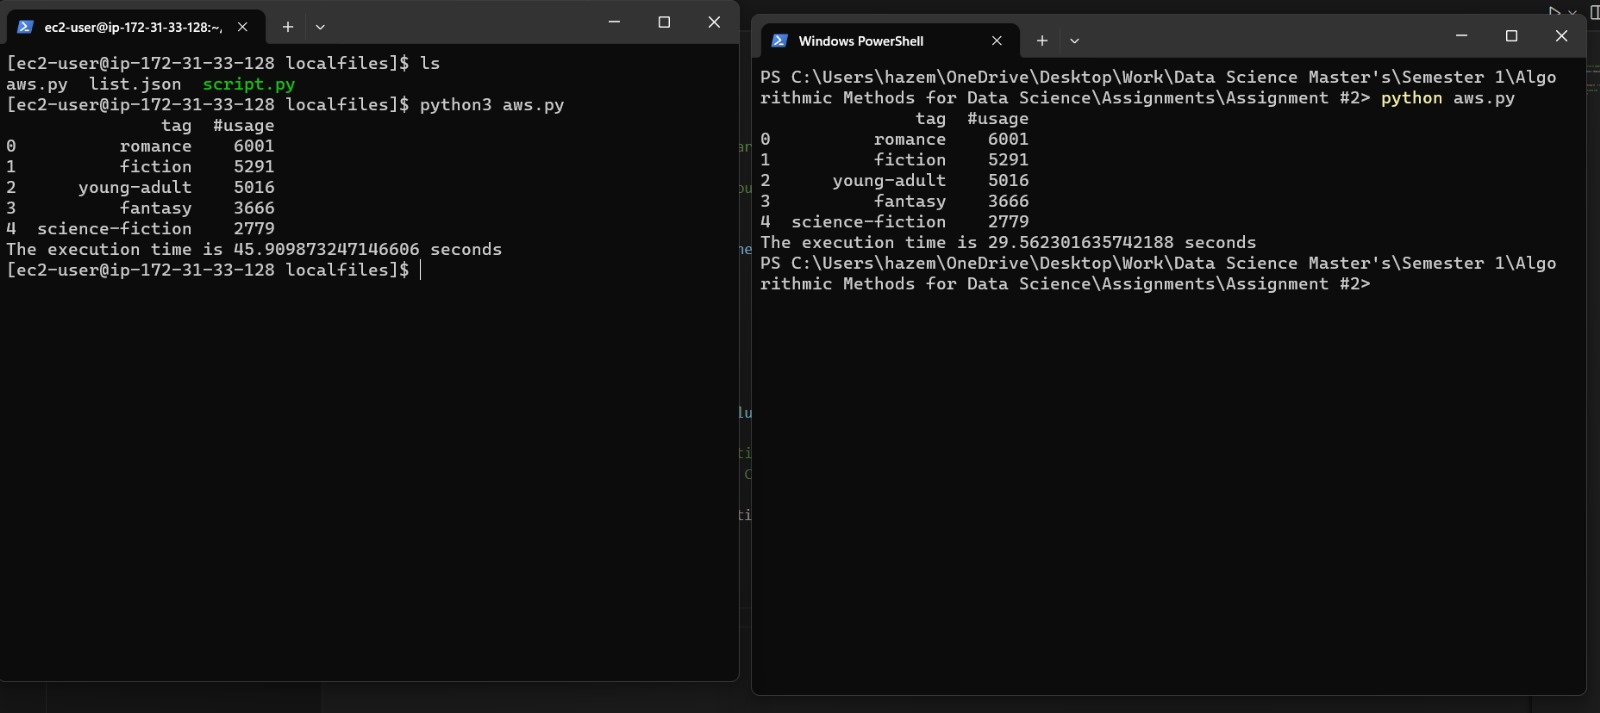

- The execution time for the local machine was less compared to the EC2 instance. The reason for this is that my machine has higher resources (CPU, Memory) compared to the default resources of the EC2 instance I used.



---

## #Algorithmis Question (AQ)

In [11]:
def myFunction():
    
    user_input = input("Enter Number of Commands: ")

    n = int(user_input) # read the number of instructions
    shelf = deque() # create a deque to push or append books depending on the instruction  

    for _ in range(n):

        user_input = input("Enter a Valid Command: ")
        instruction = user_input.split() # split the instruction to obtain the command to perform

        if instruction[0] == 'L':
            shelf.appendleft(instruction[1]) # add the book in the leftmost position

        elif instruction[0] == 'R':
            shelf.append(instruction[1]) # add the book in the rightmost position
        
        else:   
            book_id = instruction[1]
            left_books = shelf.index(book_id) # number of books on the left
            right_books = len(shelf) - left_books - 1 # number of books on the right

            if left_books <= right_books:
                print(left_books)
            else:
                print(right_books)

1) Computational Cost (with ChatGpt)

    The time complexity of your algorithm depends on the specific operations being performed. Let's break it down step by step:

    Reading n as input: This operation takes constant time O(1).

    Creating a deque shelf: Creating a deque takes constant time O(1).

    Iterating through the loop for _ in range(n): This loop runs for n iterations, and the operations inside the loop depend on the type of instruction. So, let's analyze the operations for each type of instruction.

    a. If instruction is 'L' or 'R': Appending an element to a deque takes constant time O(1).

    b. If instruction is not 'L' or 'R':

    Finding the index of a specific element in a deque using shelf.index(book_id) takes O(n) time in the worst case because it might need to search through all elements in the deque.
    Calculating right_books as len(shelf) - left_books - 1  takes O(1) time.
    Printing the result takes constant time O(1).

    Since the shelf.index(book_id) and the calculation of right_books both depend on the size of the deque shelf, the overall time complexity of your algorithm is O(n^2) in the worst case due to the nested linear search operations. The worst-case scenario is when you have to search through the entire deque to find the index of the specified book.



2) The answer provided by ChatGPT is correct. In the worst-case scenario, the computational cost of our function is O(n^2) due to the n iterations and the linear cost of the 'else' statement; in fact, the 'else' statement searches for the index of an element in the deque, so it iterates through the deque until it finds the index corrisponding to the book_id, which in the worst case is the last element of the deque, resulting in a linear cost O(n), where n represents the number of elements in the deque.

    As the algorithm's description suggests, when asked to find the number of books to remove in order to place a book in the leftmost or rightmost position, it implies that the book has already been added to the shelf. Therefore, in practice, the majority of operations should involve book insertions, which have a constant cost O(1).

    The efficiency of the algorithm depends on the sequence of operations and when the search operations are performed. Specifically, there are a few key considerations:
    - The algorithm's efficiency is greatly influenced by the ratio of search instructions to insertion instructions. If there are significantly more insertions than searches, the algorithm tends to be efficient. This is because inserting a book into the deque has a constant time complexity of O(1). If most of the operations involve adding books to the shelf, the overall performance is better.

    - When search operations are performed can impact the algorithm's efficiency: If we search for a book when the deque is relatively small, the cost will be lower compared to searching when there are many books in the deque. This is because the cost of the search operation depends on both the number of elements in the deque and the position of the book we're searching for. In the worst case, when the book is at the last position, the search can take longer, especially if the deque is large.



3) To optimize the search operation, we could use a dictionary (or a hash table) to maintain a record of each book's position. This approach enables swift look-ups for a book's position using its ID, resulting in a constant-time search operation with a time complexity of O(1). Additionally, insertions to the right are also achieved in constant time.

    However, it's important to note that the "L" instruction presents a bottleneck in this algorithm. When adding a new book to the left, not only we must insert the book's ID into our dictionary but we also need to shift the positions of all the other books to the right. This update step carries a linear cost of O(n), where n represents the number of elements in the dictionary or hash table.
    The overall time complexity of the code remains relatively efficient, especially when the number of books added to the left is not significantly larger than the number added to the right, so it's efficient for most practical use cases.